# Regional field hyperparameters
The gravity misfit in *Invert4Geom* refers to the difference between the observed gravity anomaly and the forward calculated gravity effect of a topographic surface represented by a layer of prisms. The component of this misfit we are interested in is that which results from the difference between the true topography and the starting topographic model. This is referred to as the `residual misfit`, while the remaining misfit is the `regional misfit`. Prior to the inversion, we need to estimate this `regional misfit` and remove it to isolate the `residual misfit`. 

Here we will present several methods we provide for estimating the regional component of gravity misfit. We will calculate the forward gravity effect of two topographic surfaces, the basement and Moho, from the **Bishop model**. Combined, these will make a synthetic observed gravity dataset. In this scenario, we are interested in inverting for the basement topography, and therefore need to estimate and remove the gravity effects of the Moho. To start, we will create a starting model for the basement topography from a series of known basement elevations. We will forward calculate the gravity of this starting model, and subtract it from the observed gravity to get a `gravity misfit`. From this misfit, we will then showcase several methods for estimated the regional component of the misfit.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    optimization,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement. The gravity effect from the Moho will represent the **regional** which we are aiming to isolate. We will forward model the gravity effects of both layers, and add some noise, to create an observed gravity dataset. We will then use a series of point where we know the basement topography to create a starting model, forward calculate its gravity effect, and remove it from the observed gravity to get a gravity misfit. We will then demonstrate the range of techniques implemented within *Invert4Geom* for isolated the regional component of this gravity misfit.

In [3]:
grav_df = pd.read_csv("../tutorial/tmp/regional_sep_grav_df.csv", index_col=0)
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000  
mean    101.157045       101.157045     2.0          1.548275    -1.245492  
std       9.701881         9.918000     0.0         24.921606     9.332421  
min      75.622259        70.865584     2.0        -36.407174   -39.690986  
25%      96.219224        96.092694     2.0        -17.405060    -6.457196  
50%     102.149393       102.057121     2.0         -3.039717    -0.024313  
75%     106.786022       107.005035     2.0         19.819674     4.762689  
max     126.324788       129.731888     2.0         59.686931    23.112321

In [6]:
constraint_points = pd.read_csv(
    "../tutorial/tmp/regional_sep_constraint_points.csv", index_col=0
)
constraint_points.describe()

easting       northing  true_upward       upward      uncert  \
count      15.000000      15.000000    15.000000    15.000000   15.000000   
mean   176074.067983  374901.920809 -5347.056802 -5377.150137  106.941136   
std     93521.094221  105430.197097  2146.323675  2193.119014   42.926474   
min     27437.029770  165086.148419 -8882.480862 -9295.521690   27.675267   
25%     95949.329071  307923.492200 -6589.406942 -6598.243116   77.771252   
50%    165200.779866  407905.723662 -5230.910817 -5244.731393  104.618216   
75%    265171.796613  437026.517185 -3888.562584 -3840.304455  131.788139   
max    312585.151503  514943.513495 -1383.763355 -1401.012642  177.649617   

          weight  
count  15.000000  
mean    0.000192  
std     0.000320  
min     0.000032  
25%     0.000058  
50%     0.000091  
75%     0.000166  
max     0.001306

In [9]:
grids = xr.load_dataset("../tutorial/tmp/regional_sep_grids.nc")
basement_topo = grids.basement
moho_topo = grids.moho
starting_topography = grids.starting

# get necessary parameters
spacing = utils.get_spacing(grav_df)
print(f"spacing: {spacing}")

region = vd.get_region((grav_df.easting, grav_df.northing))
print(f"region: {region}")

spacing: 4000.0
region: (np.float64(23900.0), np.float64(359900.0), np.float64(162900.0), np.float64(518900.0))


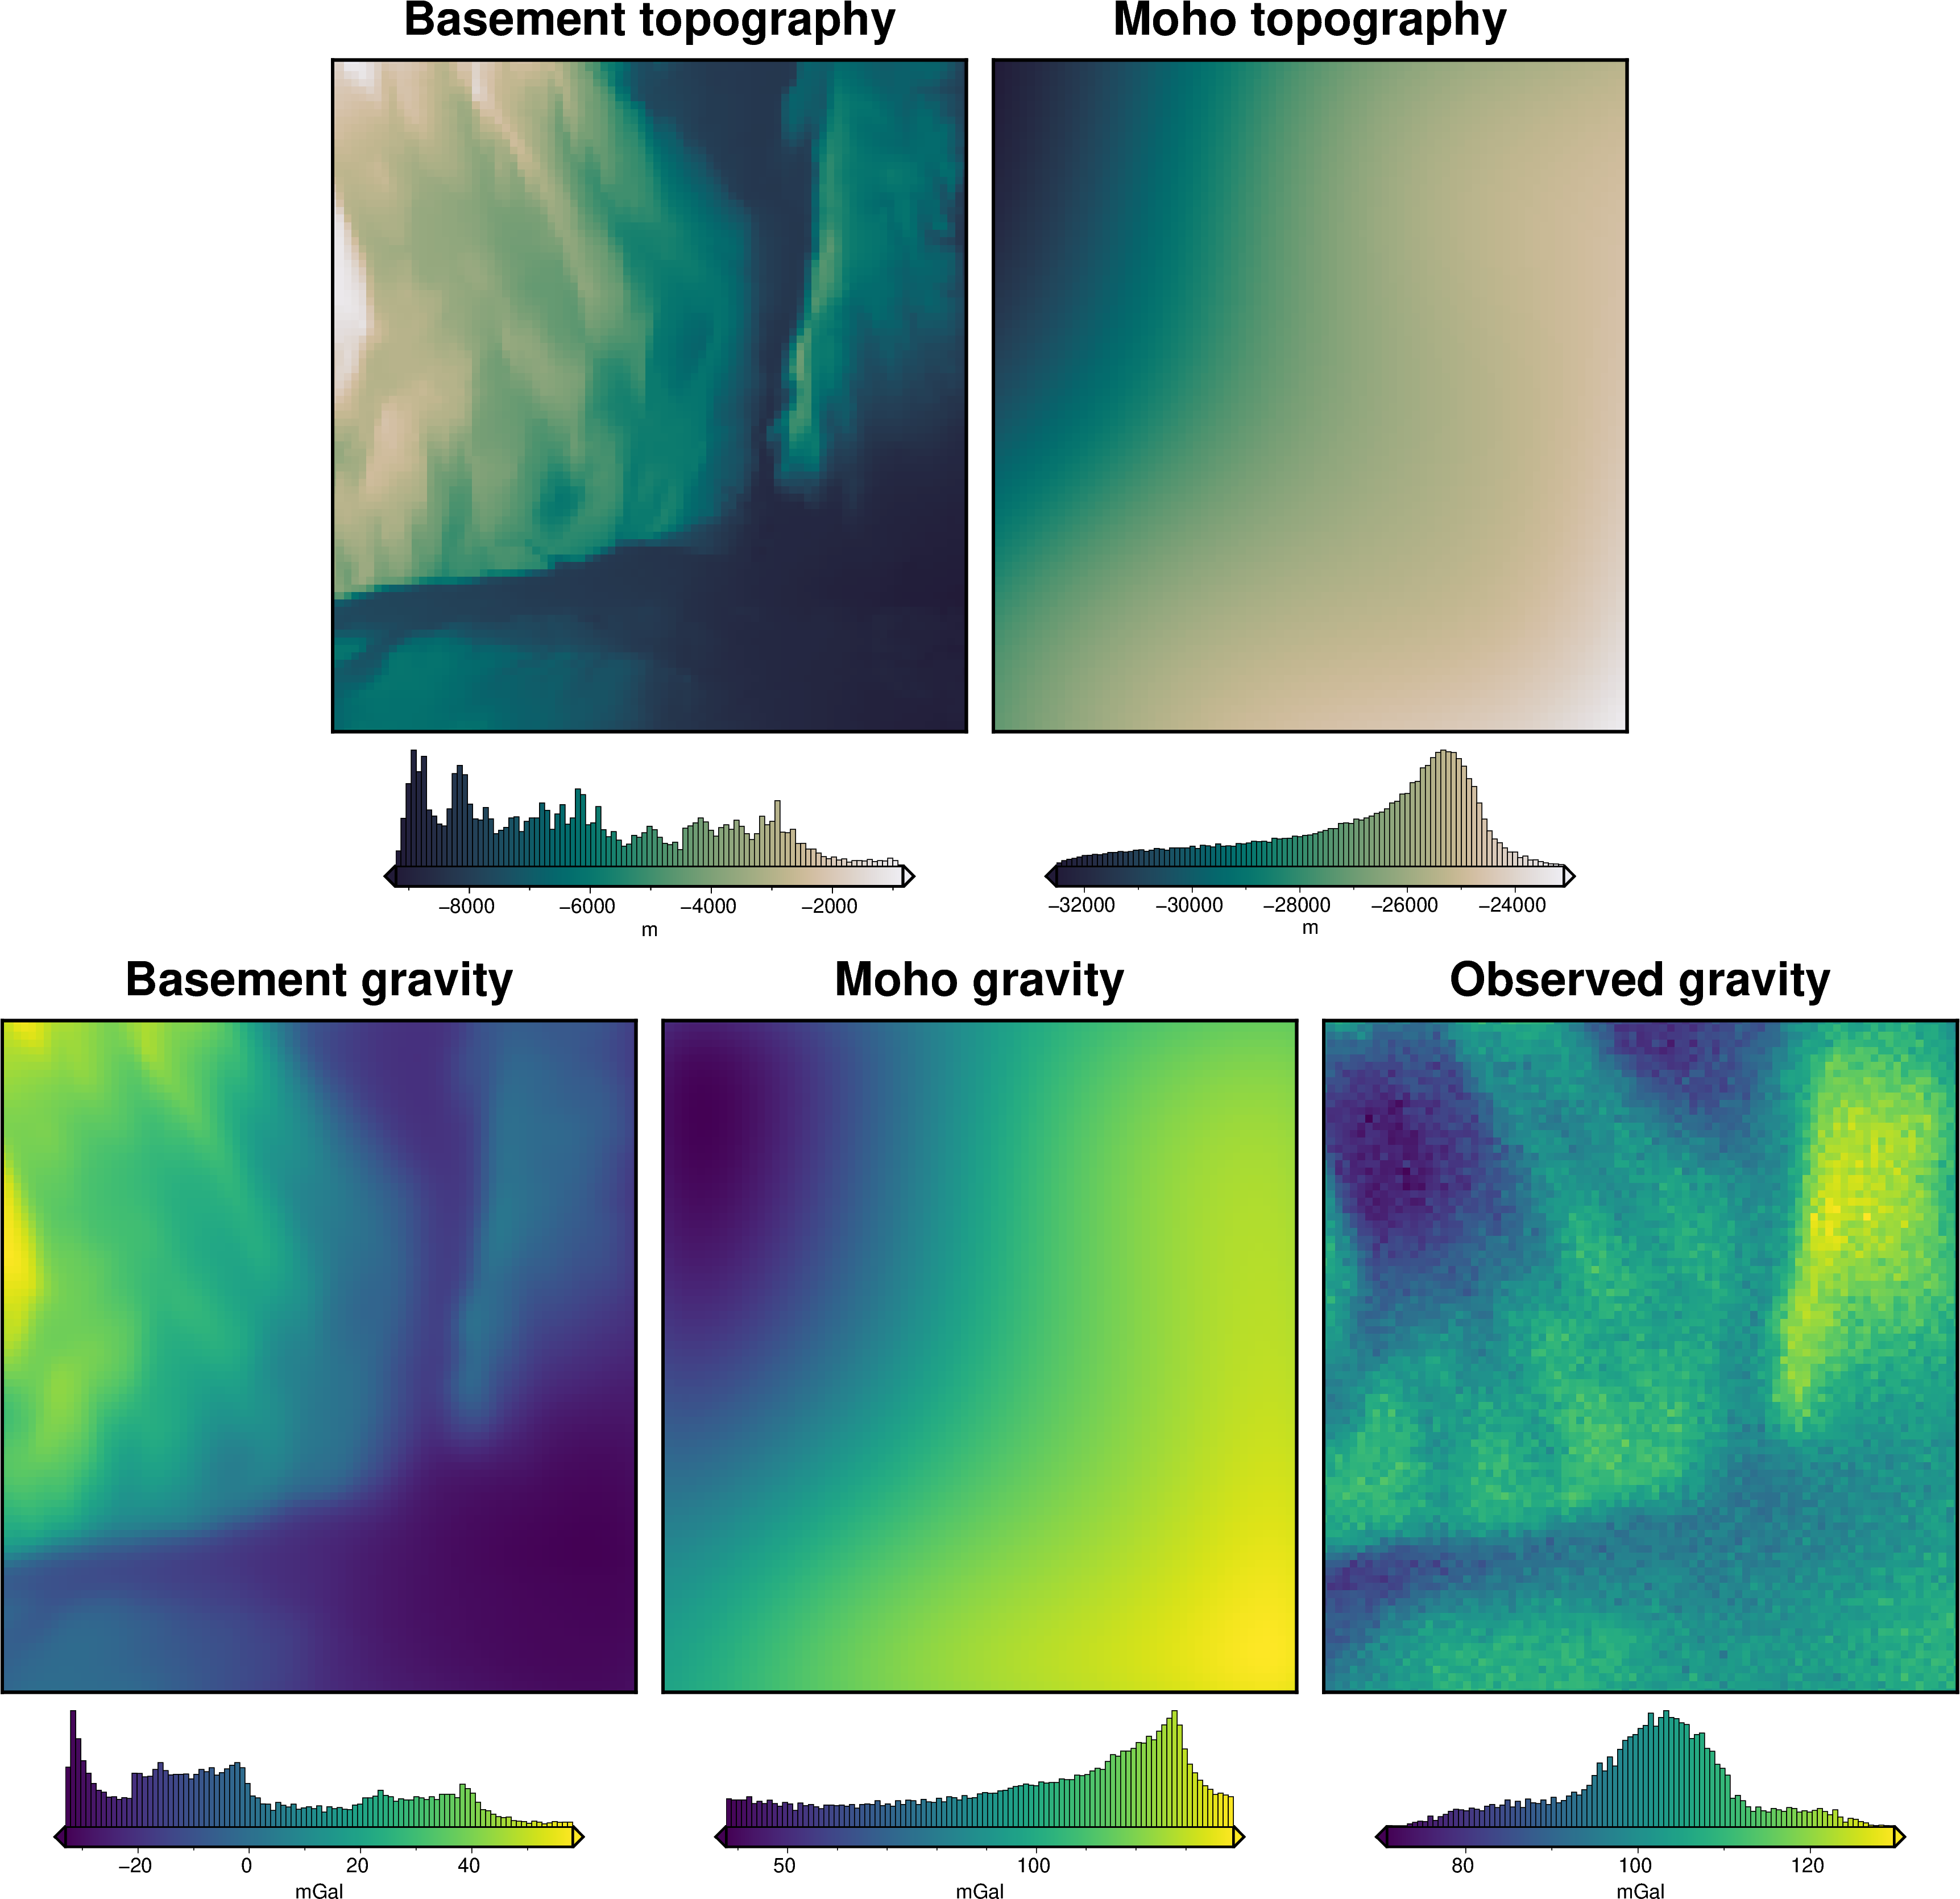

In [10]:
fig = maps.plot_grd(
    basement_topo,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    moho_topo,
    region=region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.basement_grav,
    fig=fig,
    origin_shift="both_shift",
    xshift_amount=-1.5,
    yshift_amount=-1.1,
    fig_height=10,
    title="Basement gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig.show()

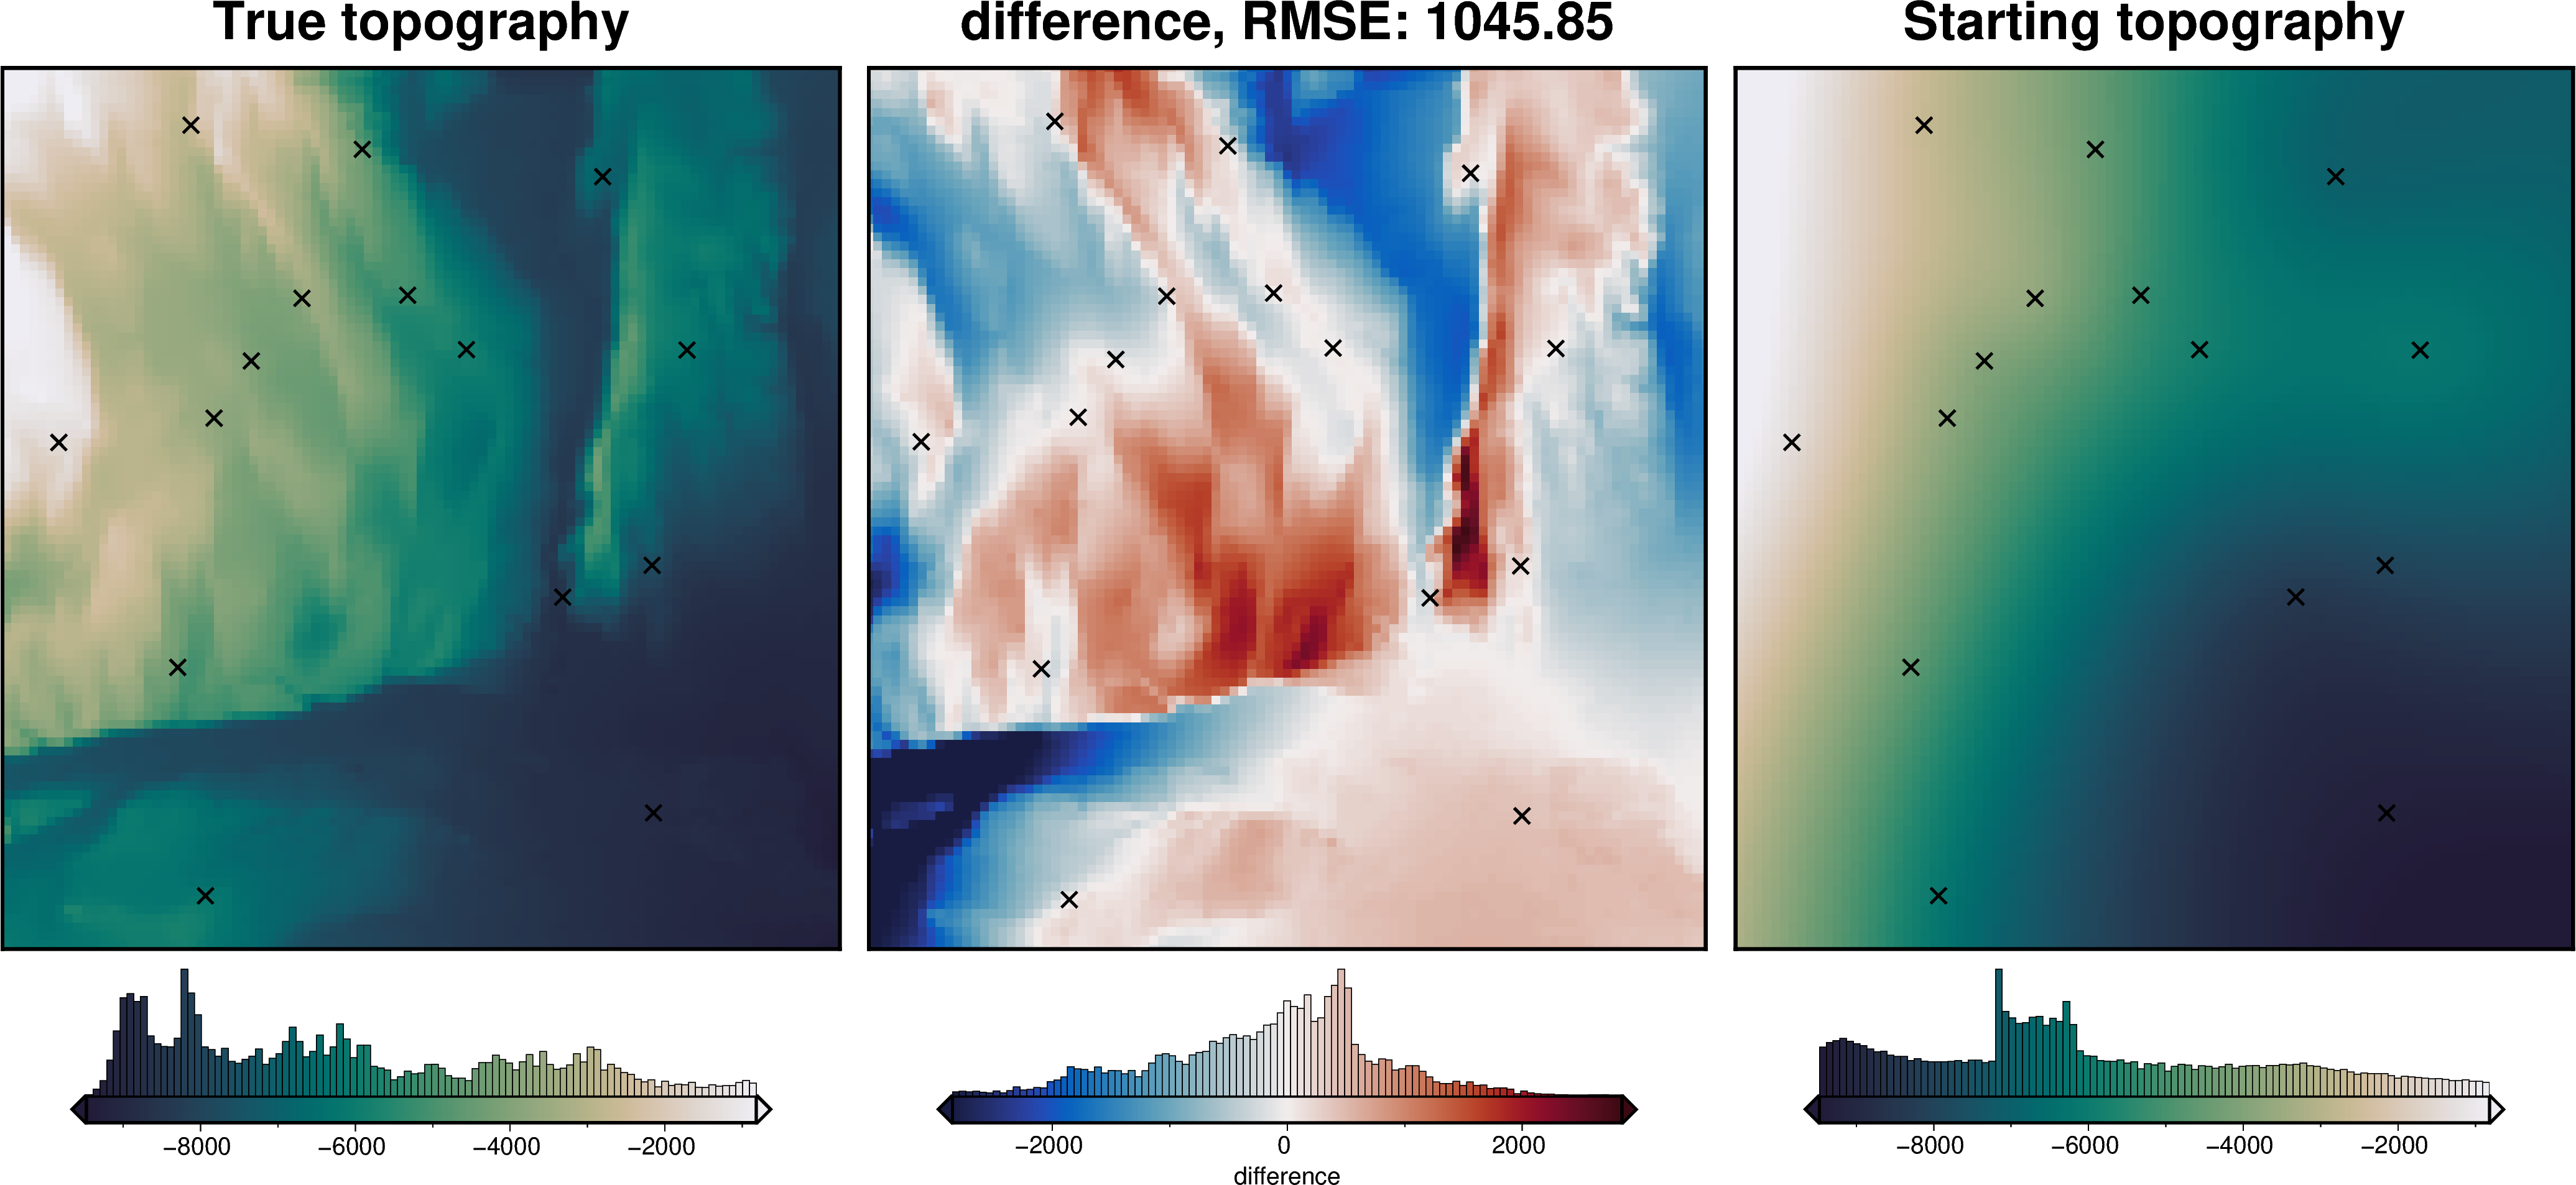

In [11]:
_ = polar_utils.grd_compare(
    basement_topo,
    starting_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

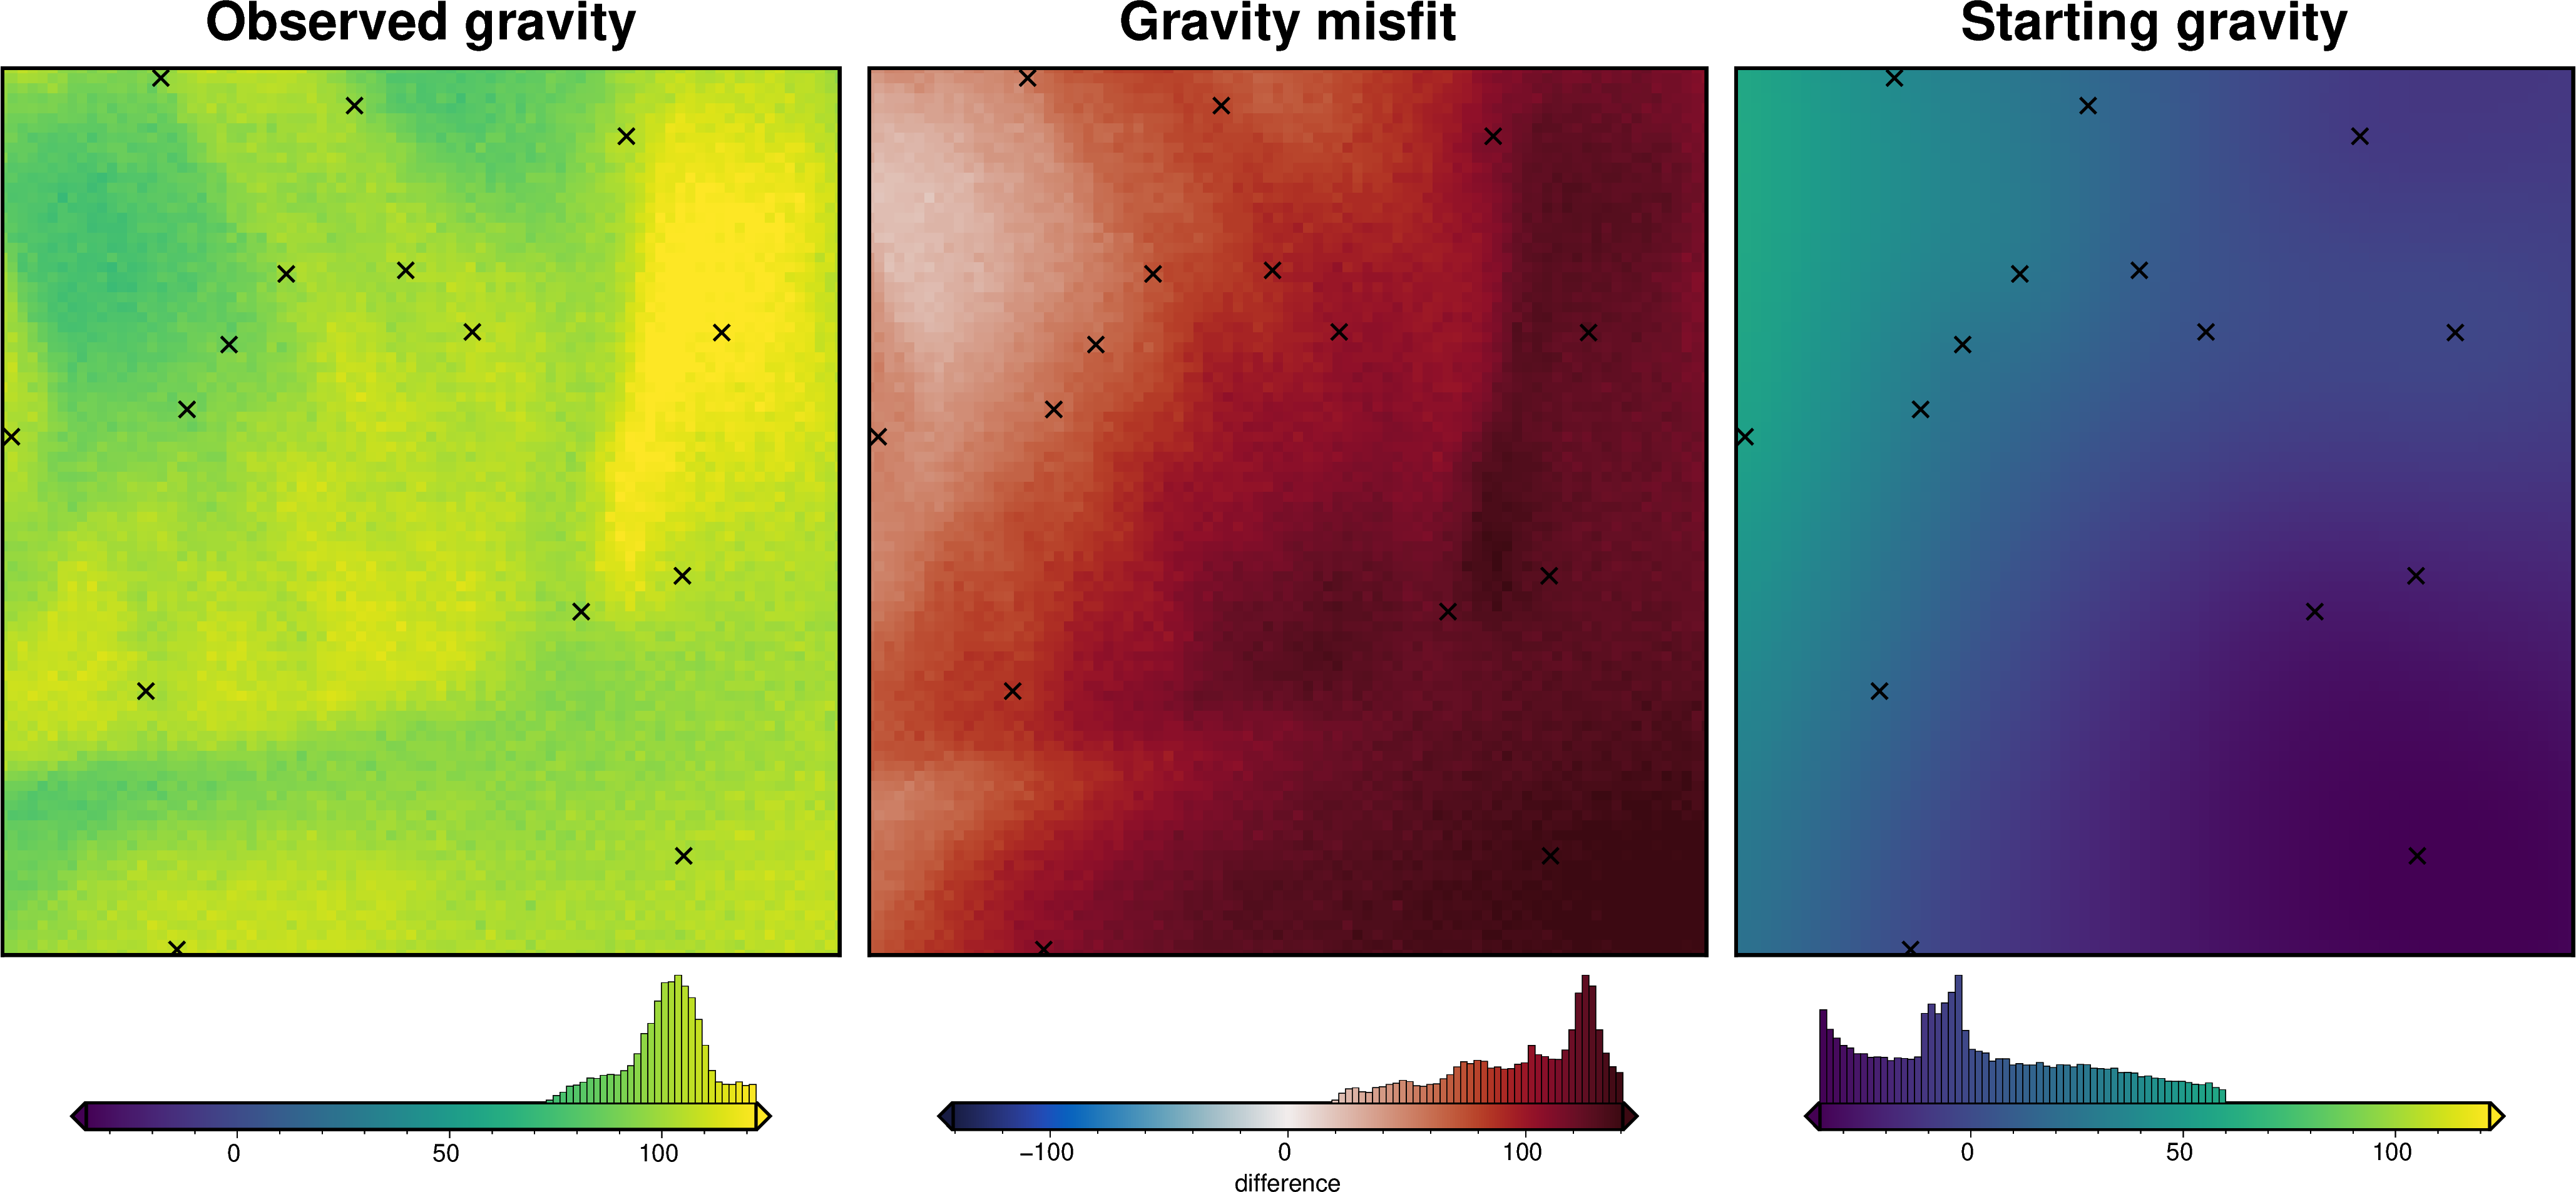

In [12]:
_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

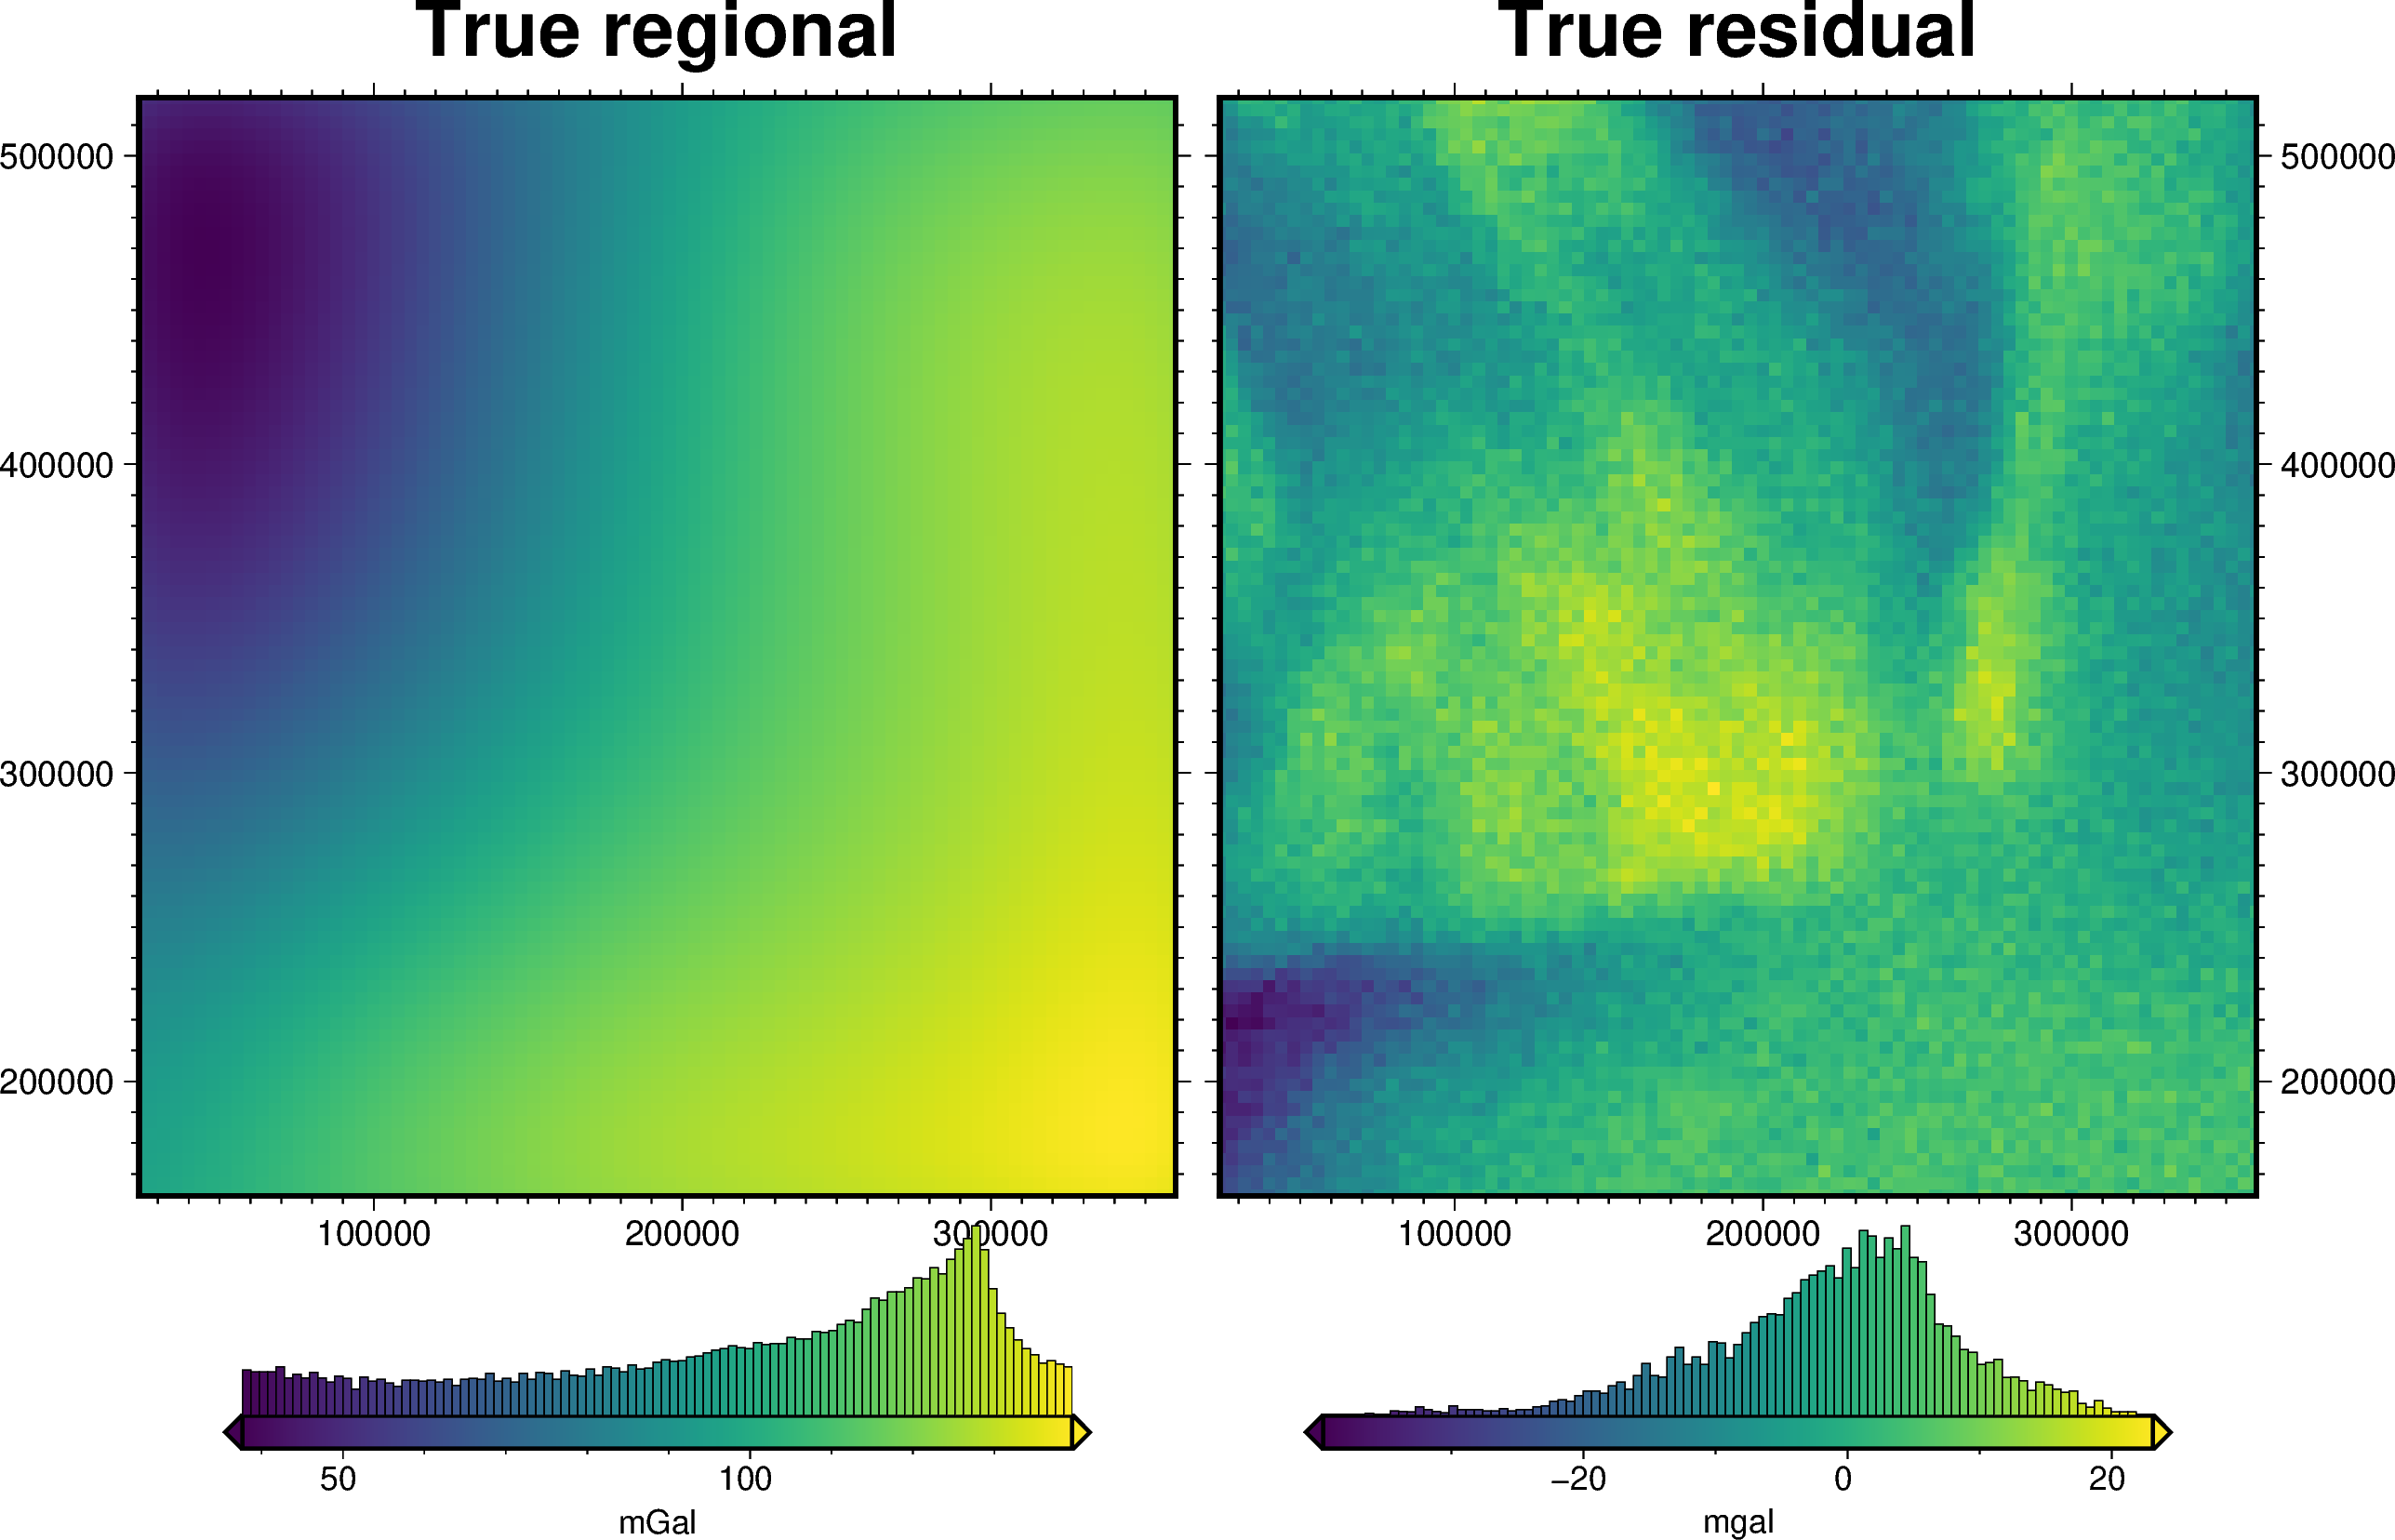

In [13]:
fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig_height=10,
    title="True regional",
    cbar_label="mGal",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.true_res,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="True residual",
    cbar_label="mgal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

# True-Estimated regional plotting function

In [14]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.moho_grav,
        grav_grid.reg,
        robust=True,
        plot=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        grav_grid.true_res,
        grav_grid.res,
        robust=True,
        plot=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

Each of these regional separation techniques requires the user input to pick the value of a certain parameter, each of which has a large effect on the outcome. Below these `hyperparameters` for each technique are explained:

**Filter technique**: the width of the gaussian filter

**Trend technique**: the degree-order of the trend fit to the data

**Equivalent Sources technique**: the source depth and optionally a damping parameter and cell-size for a block reduction

**Constraint Point Minimization technique**: the tension factor if using minimum curvature gridding, the damping value if using bi-harmonic spline gridding, or the source depth and damping parameters if using equivalent sources gridding.

# Hyperparameter estimation
In the [estimating a regional field](estimating_regional_field.ipynb) notebook we just picked these hyperparameter values arbitrarily. Below we show a more informed technique for choosing these hyperparameter values. This technique relies on having _a priori_ information  on the topography of interest to the inversion, in this case the basement topography. Therefore, we need to know the elevation of the basement at some locations to use these hyperparameter estimation techniques. These are referred to as **constraints**, and they would typically come from outcrops, boreholes, or other geophysical techniques such as seismic surveys. At the top of this notebook we sampled the basement topography at a series of random locations to simulate this constraints. 

Recall the the gravity misfit can be divided into regional and residual components: `misfit = regional + residual`.

In theory, the optimal `regional misfit` should result in `residual misfit` which is 0 at constraint points (we know the topography at constraints, so the starting model is exactly equal to the true topography and therefore the `residual misfit` should be very small at these points). This is achieved with a `regional misfit` equal to the full `misfit` at the constraints. This can obviously be achieved by setting the `regional misfit` entirely equal to the `total misfit` (i.e. the `residual misfit` is 0), but this would result in no change in the topography during this inversion. Therefore, the optimal `regional misfit` is the model which 1) **minimizes** the `residual misfit` at constraint points, while **maximizing** the overall amplitude of the `residual misfit`. 

This optimization can be performed as a multi-objective optimization (minimizing score 1 and maximizing score 2), or the scores can be combined (score1/score2) and the new resulting metric is optimized as a single-objective optimization. 

We will only show this hyperparameter optimization for the **constraint point minimization** technique. 

**Constraint point minimization**, uses the **constraints** to estimate the regional field, and therefore we can't use the constraint points to determine the optimal hyperparameter values. For this, we must use a cross-validation scheme, where some of the constraint points are omitted, and these are used to evaluate the effectiveness of the regional estimation. This works by 1) splitting the constraints into _testing_ and _training_ sets, 2) using only the _testing_ set to performing the **constraint point minimization** regional estimation for a range of possible hyperparameter values, and 3) assigning **scores** to each hyperparameter value. The hyperparameter value which produces the lowest value for the first score, and the highest values for the second score is the optimal one.

## Constraint point minimization hyperparameters

### Split constraint points into testing and training sets
There are a few methods we can use to split the constraints into testing and training sets:

#### 1) Random Splitting
We can randomly split the constraints into testing and training with the function `cross_validation.random_split_test_train()`, but certain constraints are likely very important and greatly effect the **constraint point minimization** technique. This is normally not the optimal technique. 

#### 2) Leave One Out
Instead of a single split, we can perform many sets of splits, each called a **Fold**. A simple technique for this is to create 1 fold per number of constraint points, where each fold leaves one point out of the training set to make up the testing set. If you have many points, this results in a lot of folds which can be very computationally demanding since we will need to perform a hyperparameter cross-validation for each fold. You can use function `cross_validation.split_test_train` with `method="LeaveOneOut"` for this.

#### 3) Block K-Fold 
The third, and in most circumstances best approach is a **Block K-Fold**. For this the constraints are split into testing and training sets **K** times, and the cross-validation is performed for each of these **K** folds. Since spatial data is common auto-correlated (nearby points have similar values), to ensure we don't overestimate cross-validation scores, it is best to split the data into spatial blocks, then split the data within these blocks into the *training* and *testing* sets. 

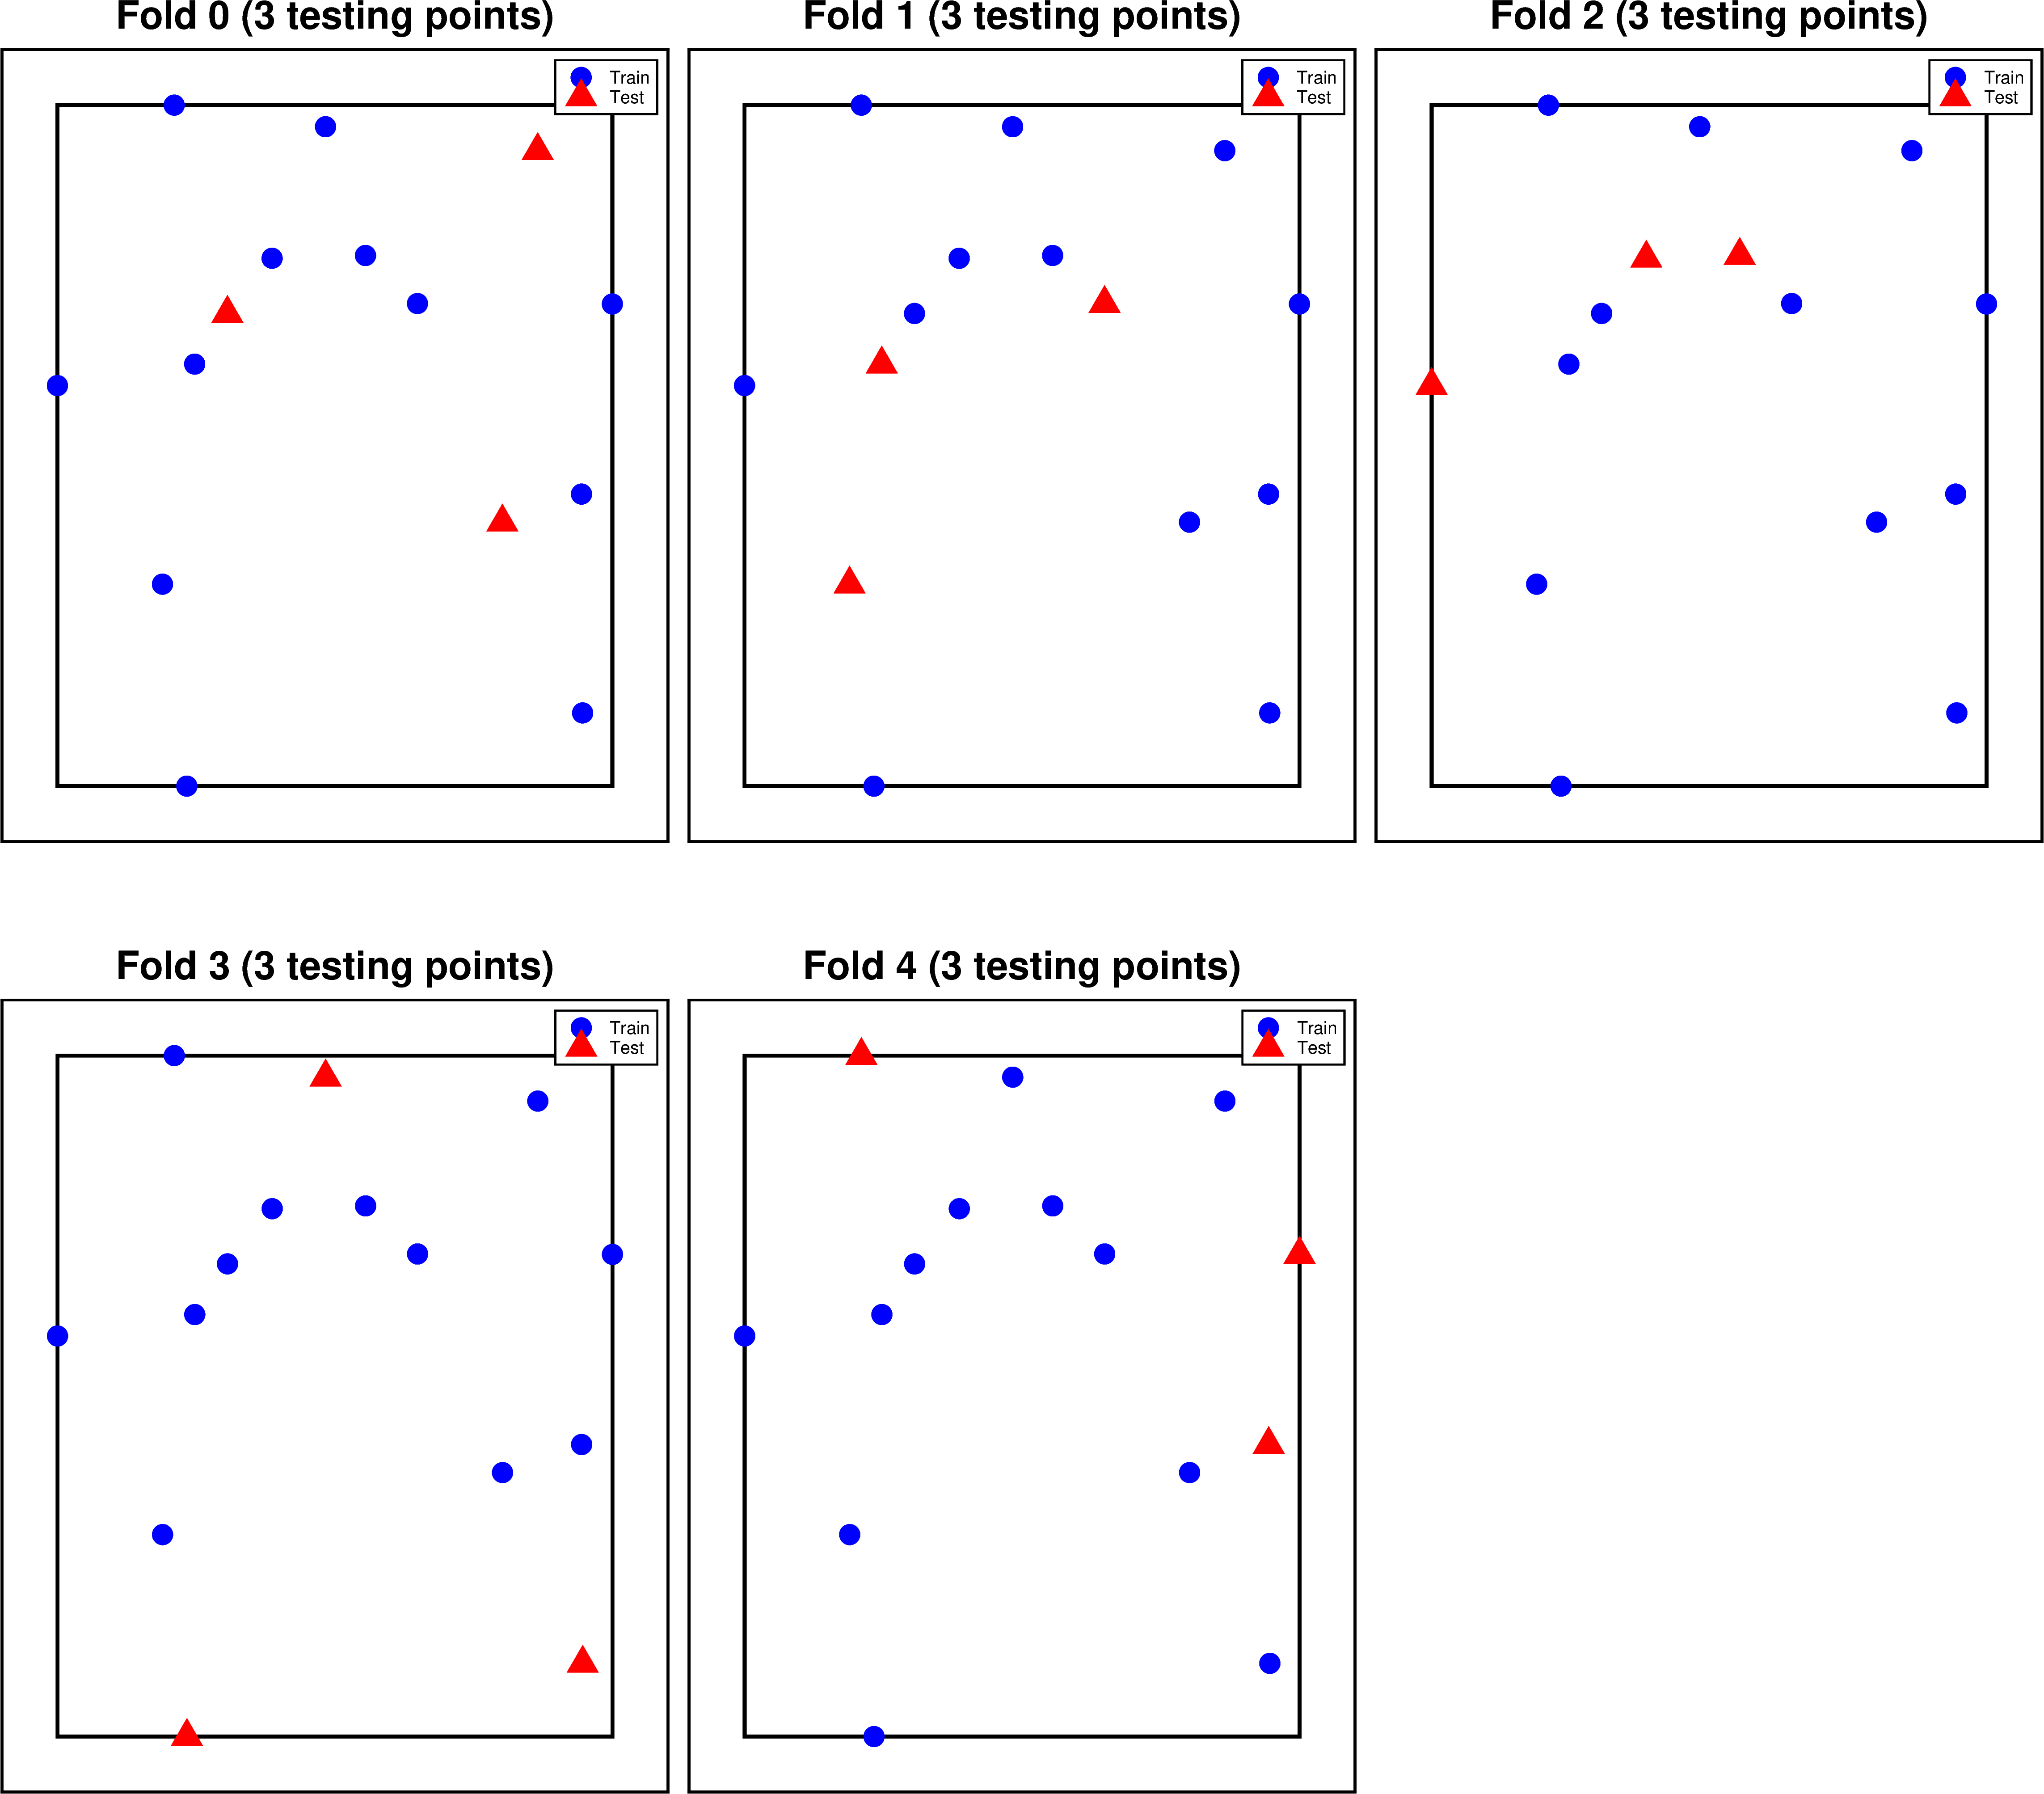

In [15]:
block_kfold_split_df = cross_validation.split_test_train(
    constraint_points,
    method="KFold",
    # spacing=spacing,
    shape=(20, 20),
    plot=True,
)

In [16]:
block_kfold_split_df

easting       northing  true_upward       upward      uncert  \
0    93942.740553  165086.148419 -6166.691339 -6151.184549  123.333827   
1   185744.836752  437747.618234 -5230.910817 -5244.731393  104.618216   
2   165200.779866  503888.251841 -4551.466895 -4493.169645   91.029338   
3   312585.151503  412789.886738 -6178.090981 -6165.129332  123.561820   
4    81410.282014  268837.863004 -4562.000830 -4610.875312   91.240017   
5   137758.290763  436305.416136 -3739.300871 -3712.258617   74.786017   
6   114799.031988  407905.723662 -4037.824297 -3932.517835   80.756486   
7   256089.893751  300737.319016 -8556.923537 -8394.841550  171.138471   
8    97955.917590  381913.273733 -3696.069980 -3748.091074   73.921400   
9   296715.509301  315109.665385 -7771.865470 -7968.559179  155.437309   
10   27437.029770  370907.112964 -1383.763355 -1401.012642   27.675267   
11  212464.442079  413038.244716 -5835.762415 -5830.939043  116.715248   
12  297311.998972  202734.681191 -8882.480862 -9295.521690  177.649617   
13  274253.699476  491584.093601 -7000.722903 -7031.356900  140.014458   
14   87441.415368  514943.513495 -2611.977474 -2677.063300   52.239549   

      weight fold_0 fold_1 fold_2 fold_3 fold_4  
0   0.000066  train  train  train   test  train  
1   0.000091  train  train   test  train  train  
2   0.000121  train  train  train   test  train  
3   0.000065  train  train  train  train   test  
4   0.000120  train   test  train  train  train  
5   0.000179  train  train   test  train  train  
6   0.000153   test  train  train  train  train  
7   0.000034   test  train  train  train  train  
8   0.000183  train   test  train  train  train  
9   0.000041  train  train  train  train   test  
10  0.001306  train  train   test  train  train  
11  0.000073  train   test  train  train  train  
12  0.000032  train  train  train   test  train  
13  0.000051   test  train  train  train  train  
14  0.000366  train  train  train  train   test

### Report the scores for constraint point minimization

Now that the constraint points are split into *testing* and *training* sets, we can perform a constrain point minimization regional field estimation and calculate the scores for how well it performed.

The constraint point minimization technique works by sampling the gravity misfit values at the constraints points, interpolating across the entire grid region with just the points to create the regional misfit grid, then subtracting this from the total misfit grid to get the residual misfit grid. 

Once the gravity misfit values are sampled, there are 3 methods for how to perform the interpolation: 
1) gridding with **tensioned minimum curvature** using PyGMT. This includes a hyperparameter of the tension factor (0-1).
2) gridding with **bi-harmonic splines** using Verde. This includes the hyperparameter of the damping factor. 
3) gridding with **equivalent sources** using Harmonica. This includes several hyperparameters; source depth, damping factor, block size, and synthetic gravity observation elevation.

In the `regional_separation_score` function, the argument `constraints_df` is used for the constraint point minimization, while the argument `testing_df` is used for calculating the scores.

In [17]:
# values needed in all the regional separation techniques
kwargs = {
    "grav_df": grav_df,
    # "score_as_median":True,
    "true_regional": grav_grid.moho_grav,
    "constraints_weights_column": "weight",
}

kwargs2 = {k: v for k, v in kwargs.items() if k not in ["true_regional"]}

In [18]:
# get just a single fold of the splits
training_df = block_kfold_split_df[block_kfold_split_df.fold_0 == "train"]
testing_df = block_kfold_split_df[block_kfold_split_df.fold_0 == "test"]

constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="pygmt",
        tension_factor=0.3,
        constraints_df=training_df,
        testing_df=testing_df,
        **kwargs,
    )
)
print(
    "Scores with tensioned minimum curvature gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="verde",
        spline_dampings=0.1,
        constraints_df=training_df,
        testing_df=testing_df,
        **kwargs,
    )
)
print(
    "Scores with bi-harmonic splines gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="eq_sources",
        damping=10,
        block_size=10e3,
        depth=10e3,
        grav_obs_height=1e3,
        constraints_df=training_df,
        testing_df=testing_df,
        **kwargs,
    )
)
print(
    "Scores with equivalent sources gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

Scores with tensioned minimum curvature gridding:
	RMS of residual at constraint points: 5.914557510534943
 	RMS of residual everywhere: 10.367725624417478
Scores with bi-harmonic splines gridding:
	RMS of residual at constraint points: 84.08761042426144
 	RMS of residual everywhere: 84.72279848623107
Scores with equivalent sources gridding:
	RMS of residual at constraint points: 101.75165647718488
 	RMS of residual everywhere: 104.16410272961889


### Optimization for hyperparameter values

We can also run the optimization on the constraints which have been split into several folds of *testing* and *training* data. Each fold will require it's own optimization, and the results from each fold will be merged to see which hyperparameter values are optimal across all the folds.We are just using the Block K-Folds approach here. Since we are working with synthetic data which we know the true regional field for, for each method we first optimize on minimizing the error between the**true regional** and the estimated regional. Then we perform the optimization with now knowledge of the true regional to see how the optimizations performed.

For each method below we have plot *Slice Plots* which show parameter values on the x axis and scores on the y axis. The scores shown on the y axis are the RMSE between the true and estimated regional fields (blue dots), the RMS of the residual at constraint points (red dots) and the RMS of the residual amplitude (greed dots).

For each method we also show create and ensemble of regional fields using a range or parameter values and calculate a cell-wise standard deviation to give an idea of the possible variation (uncertainty) each of these methods has.

##### Tensioned Minimum Curvature with PyGMT

INFO:invert4geom:optimizing on minimizing the true regional misfit
INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 18
INFO:invert4geom:	parameter: {'tension_factor': 0.007738624884515514}
INFO:invert4geom:	scores: [5.269624864905089]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


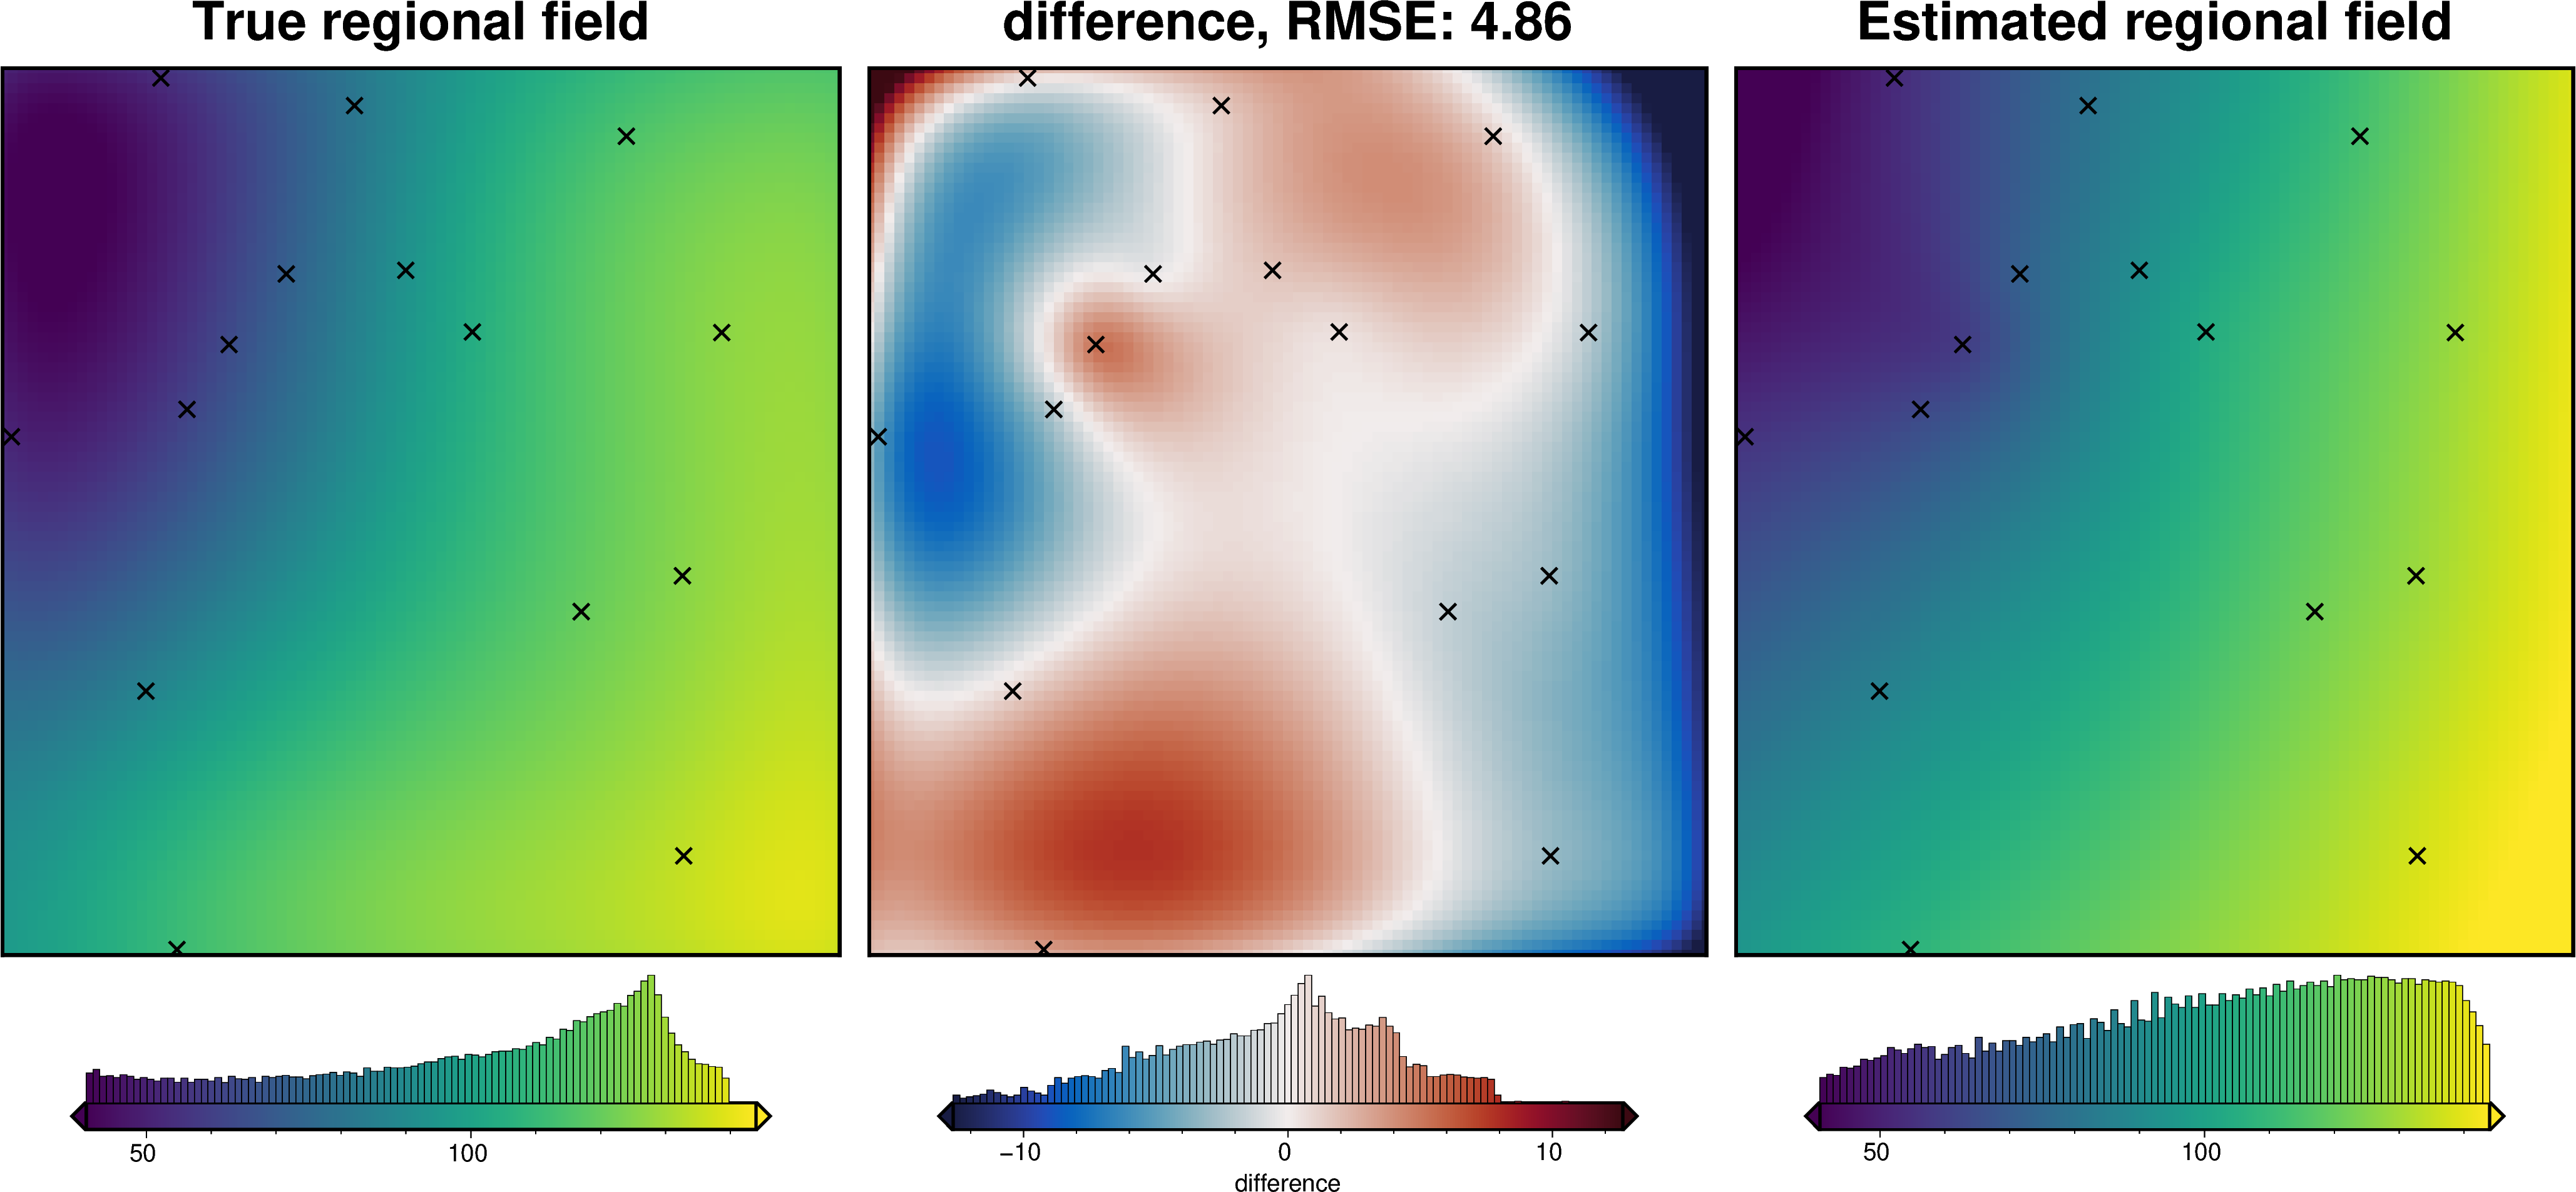

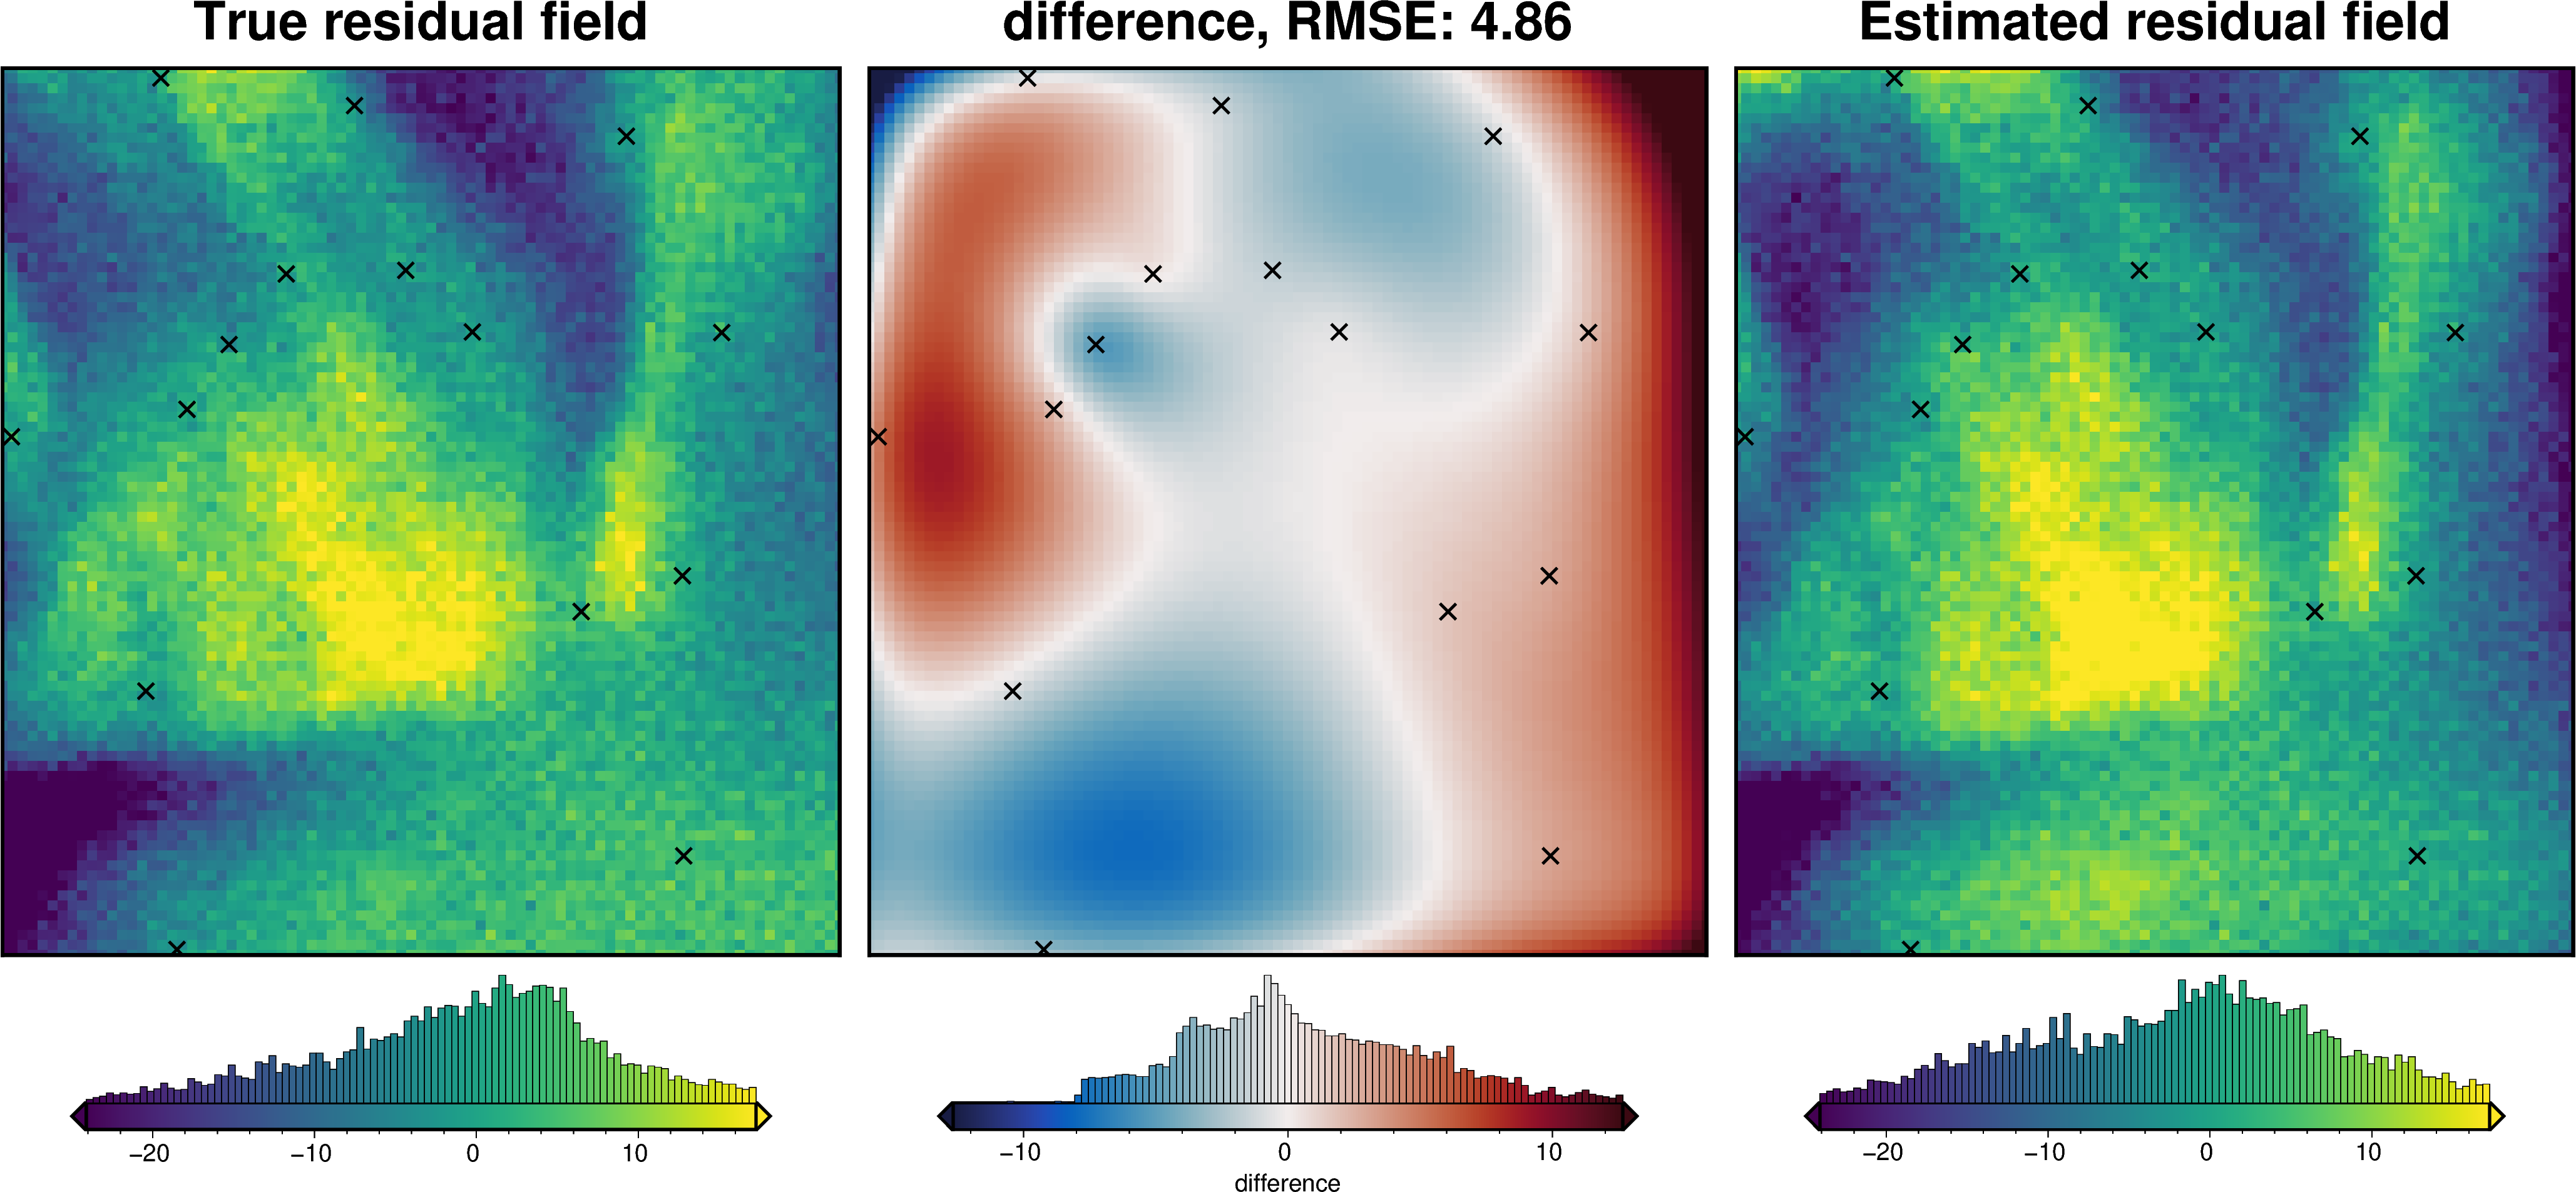

In [19]:
test_dfs, train_dfs = cross_validation.kfold_df_to_lists(block_kfold_split_df)

study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="pygmt",
        tension_factor_limits=[0, 1],
        n_trials=20,
        plot=True,
        fname="tmp/study",
        optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Number of trials on the Pareto front: 10
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 10
INFO:invert4geom:	parameter: {'tension_factor': 0.12054708428782679}
INFO:invert4geom:	scores: [4.228806645431851, 10.348730906768425]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


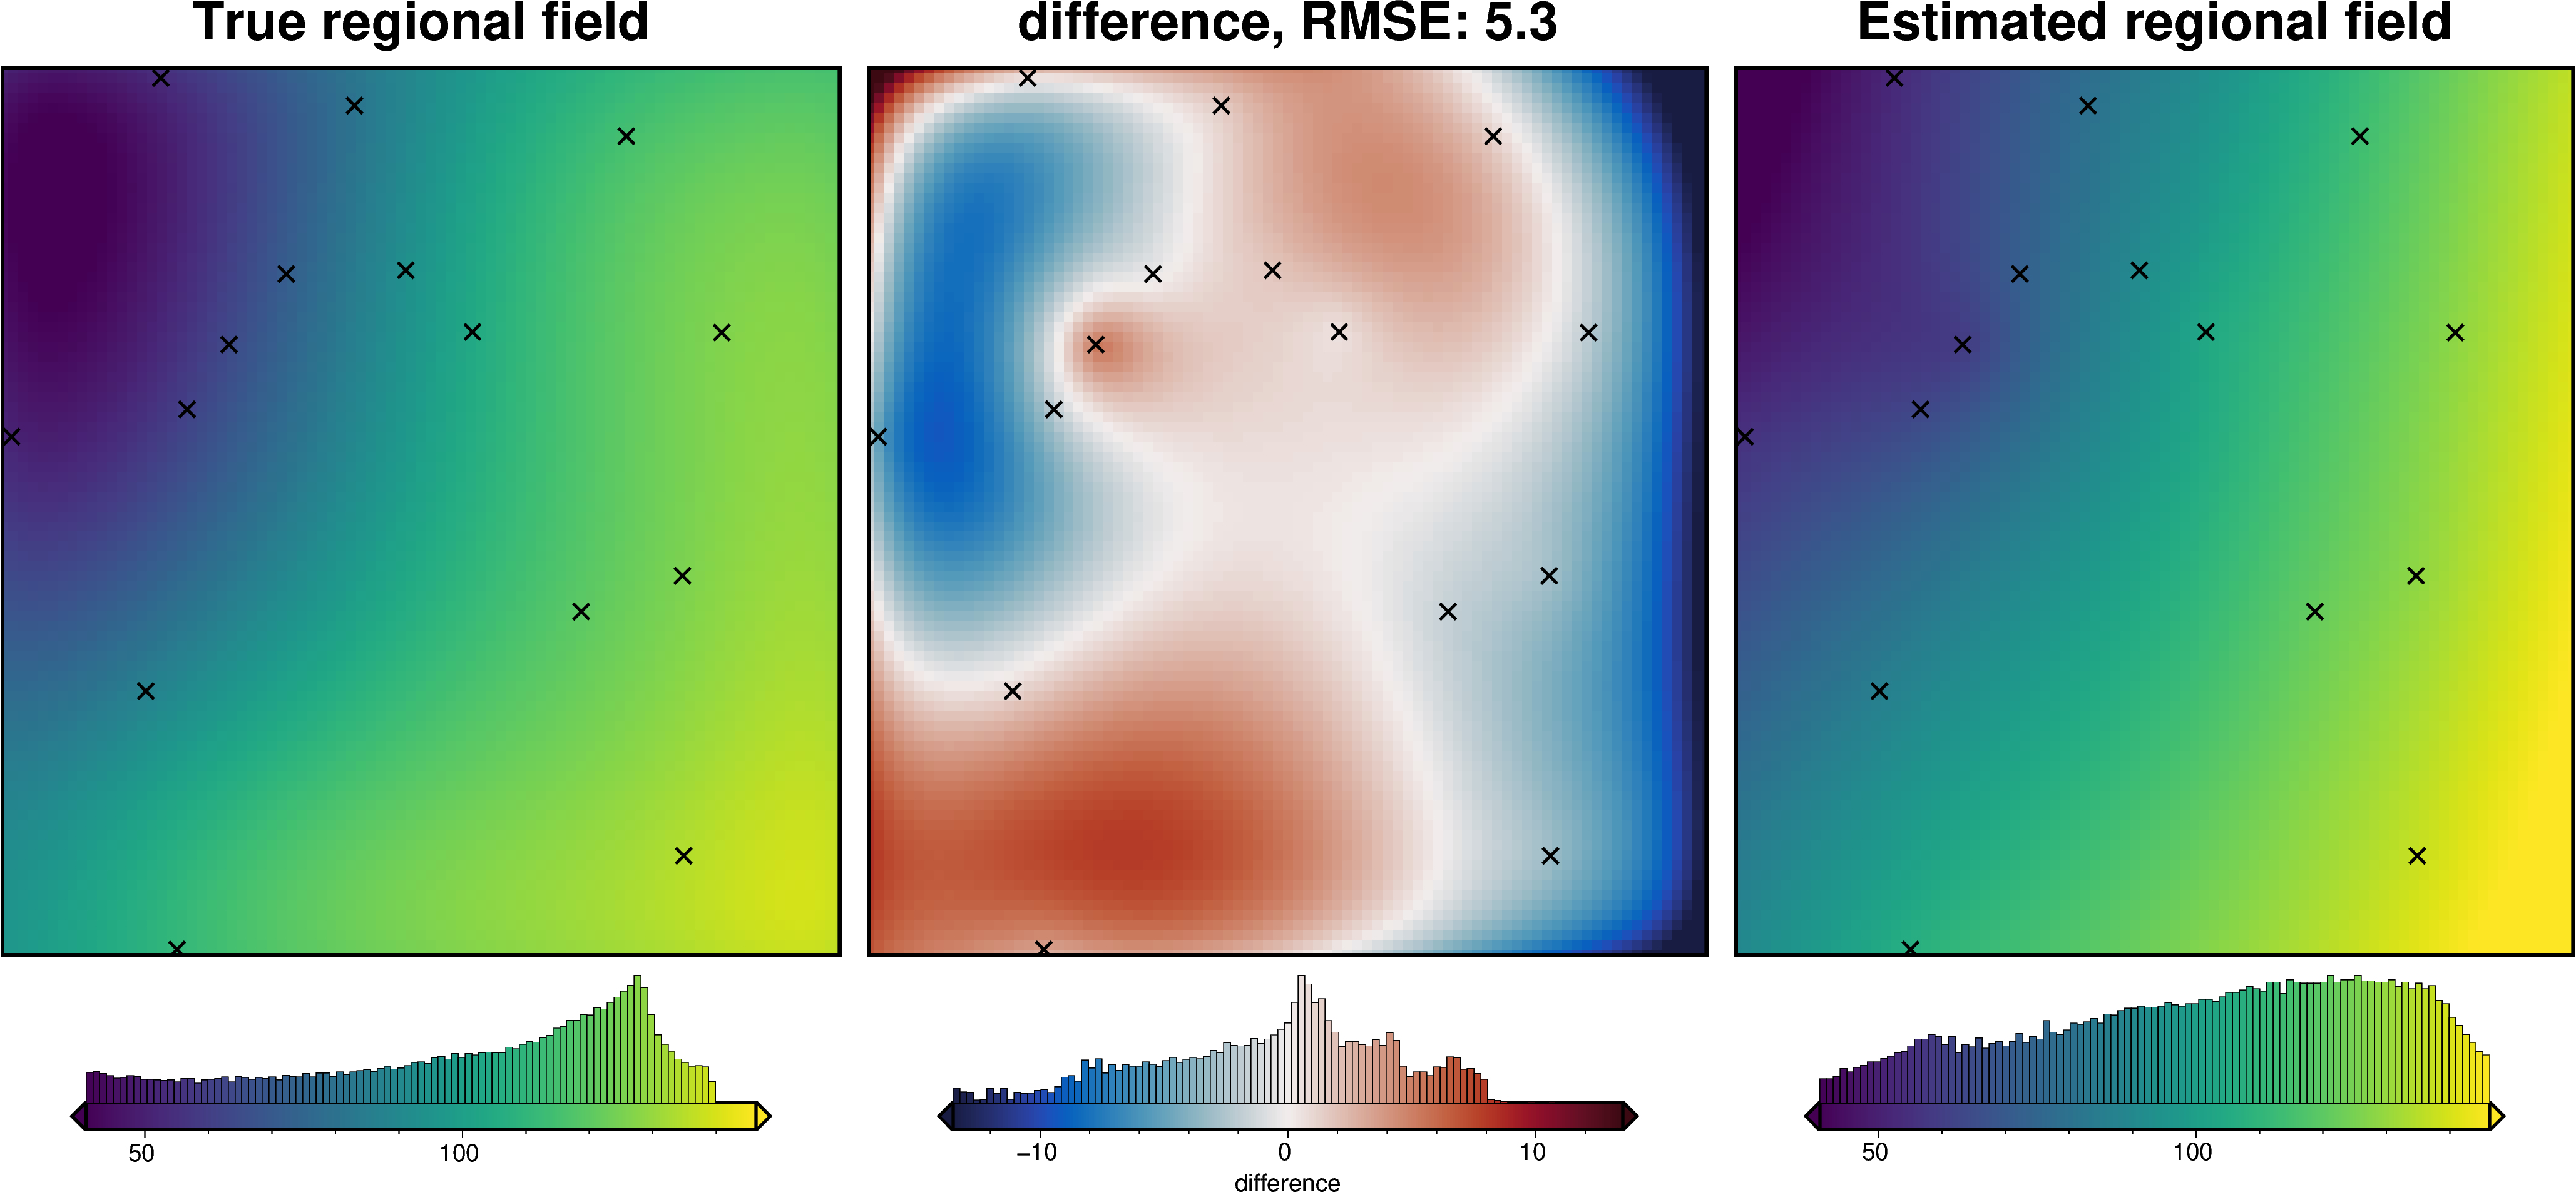

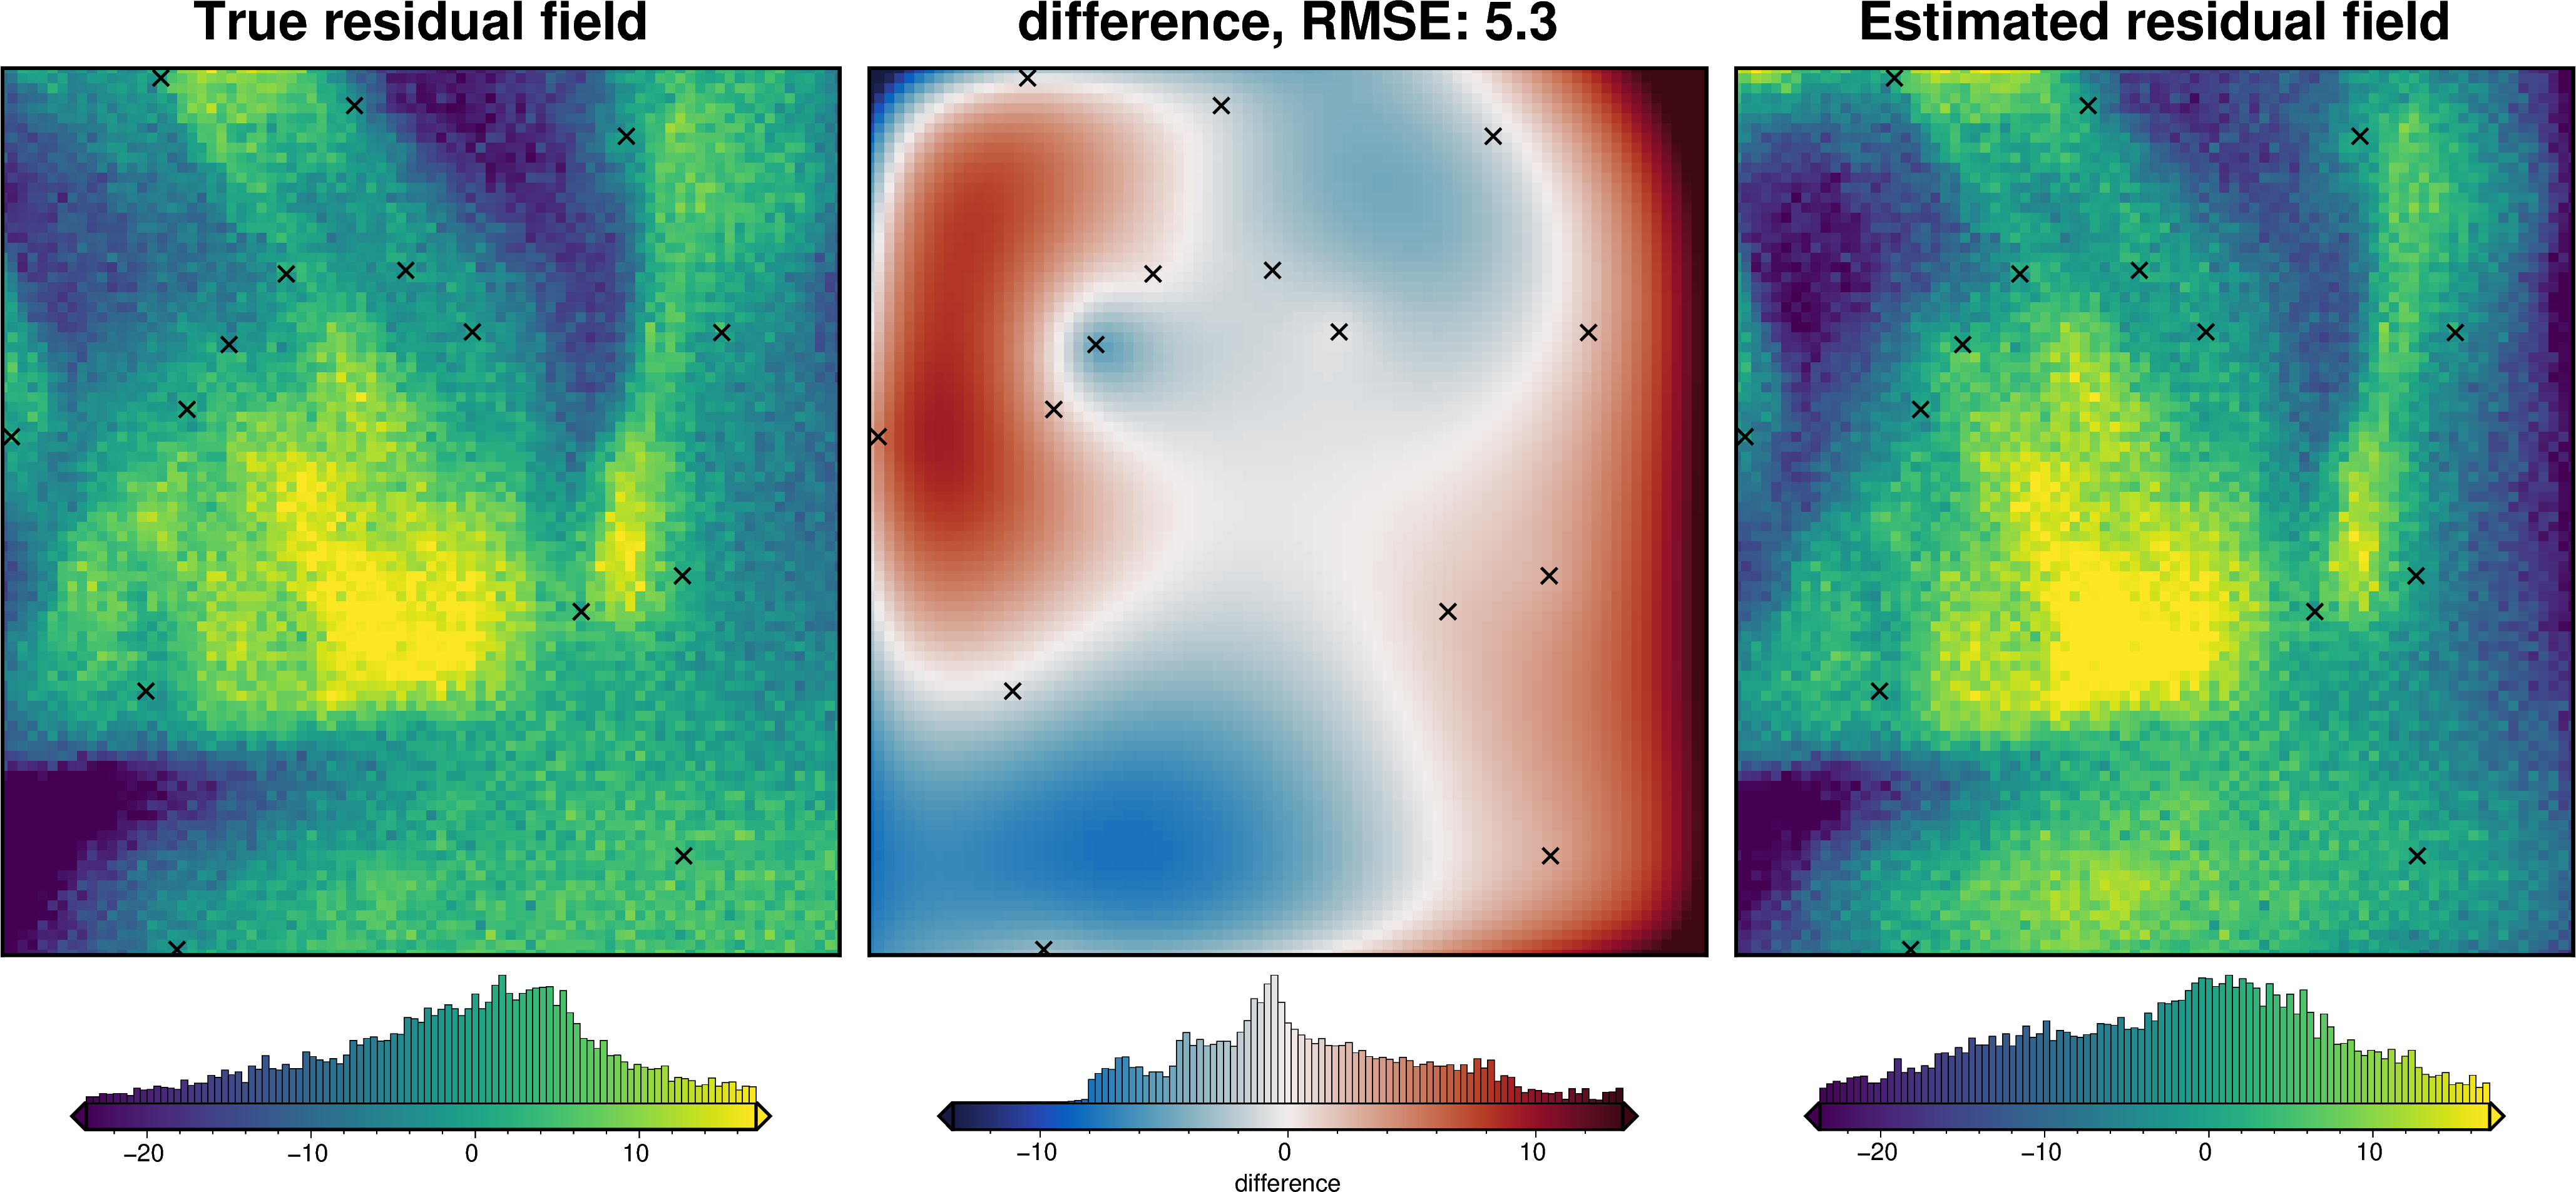

In [20]:
test_dfs, train_dfs = cross_validation.kfold_df_to_lists(block_kfold_split_df)

study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="pygmt",
        tension_factor_limits=[0, 1],
        n_trials=20,
        plot=True,
        fname="tmp/study",
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

INFO:invert4geom:Sampled 'tension_factor' parameter values; mean: 0.5, min: 0.0125, max: 0.9875


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

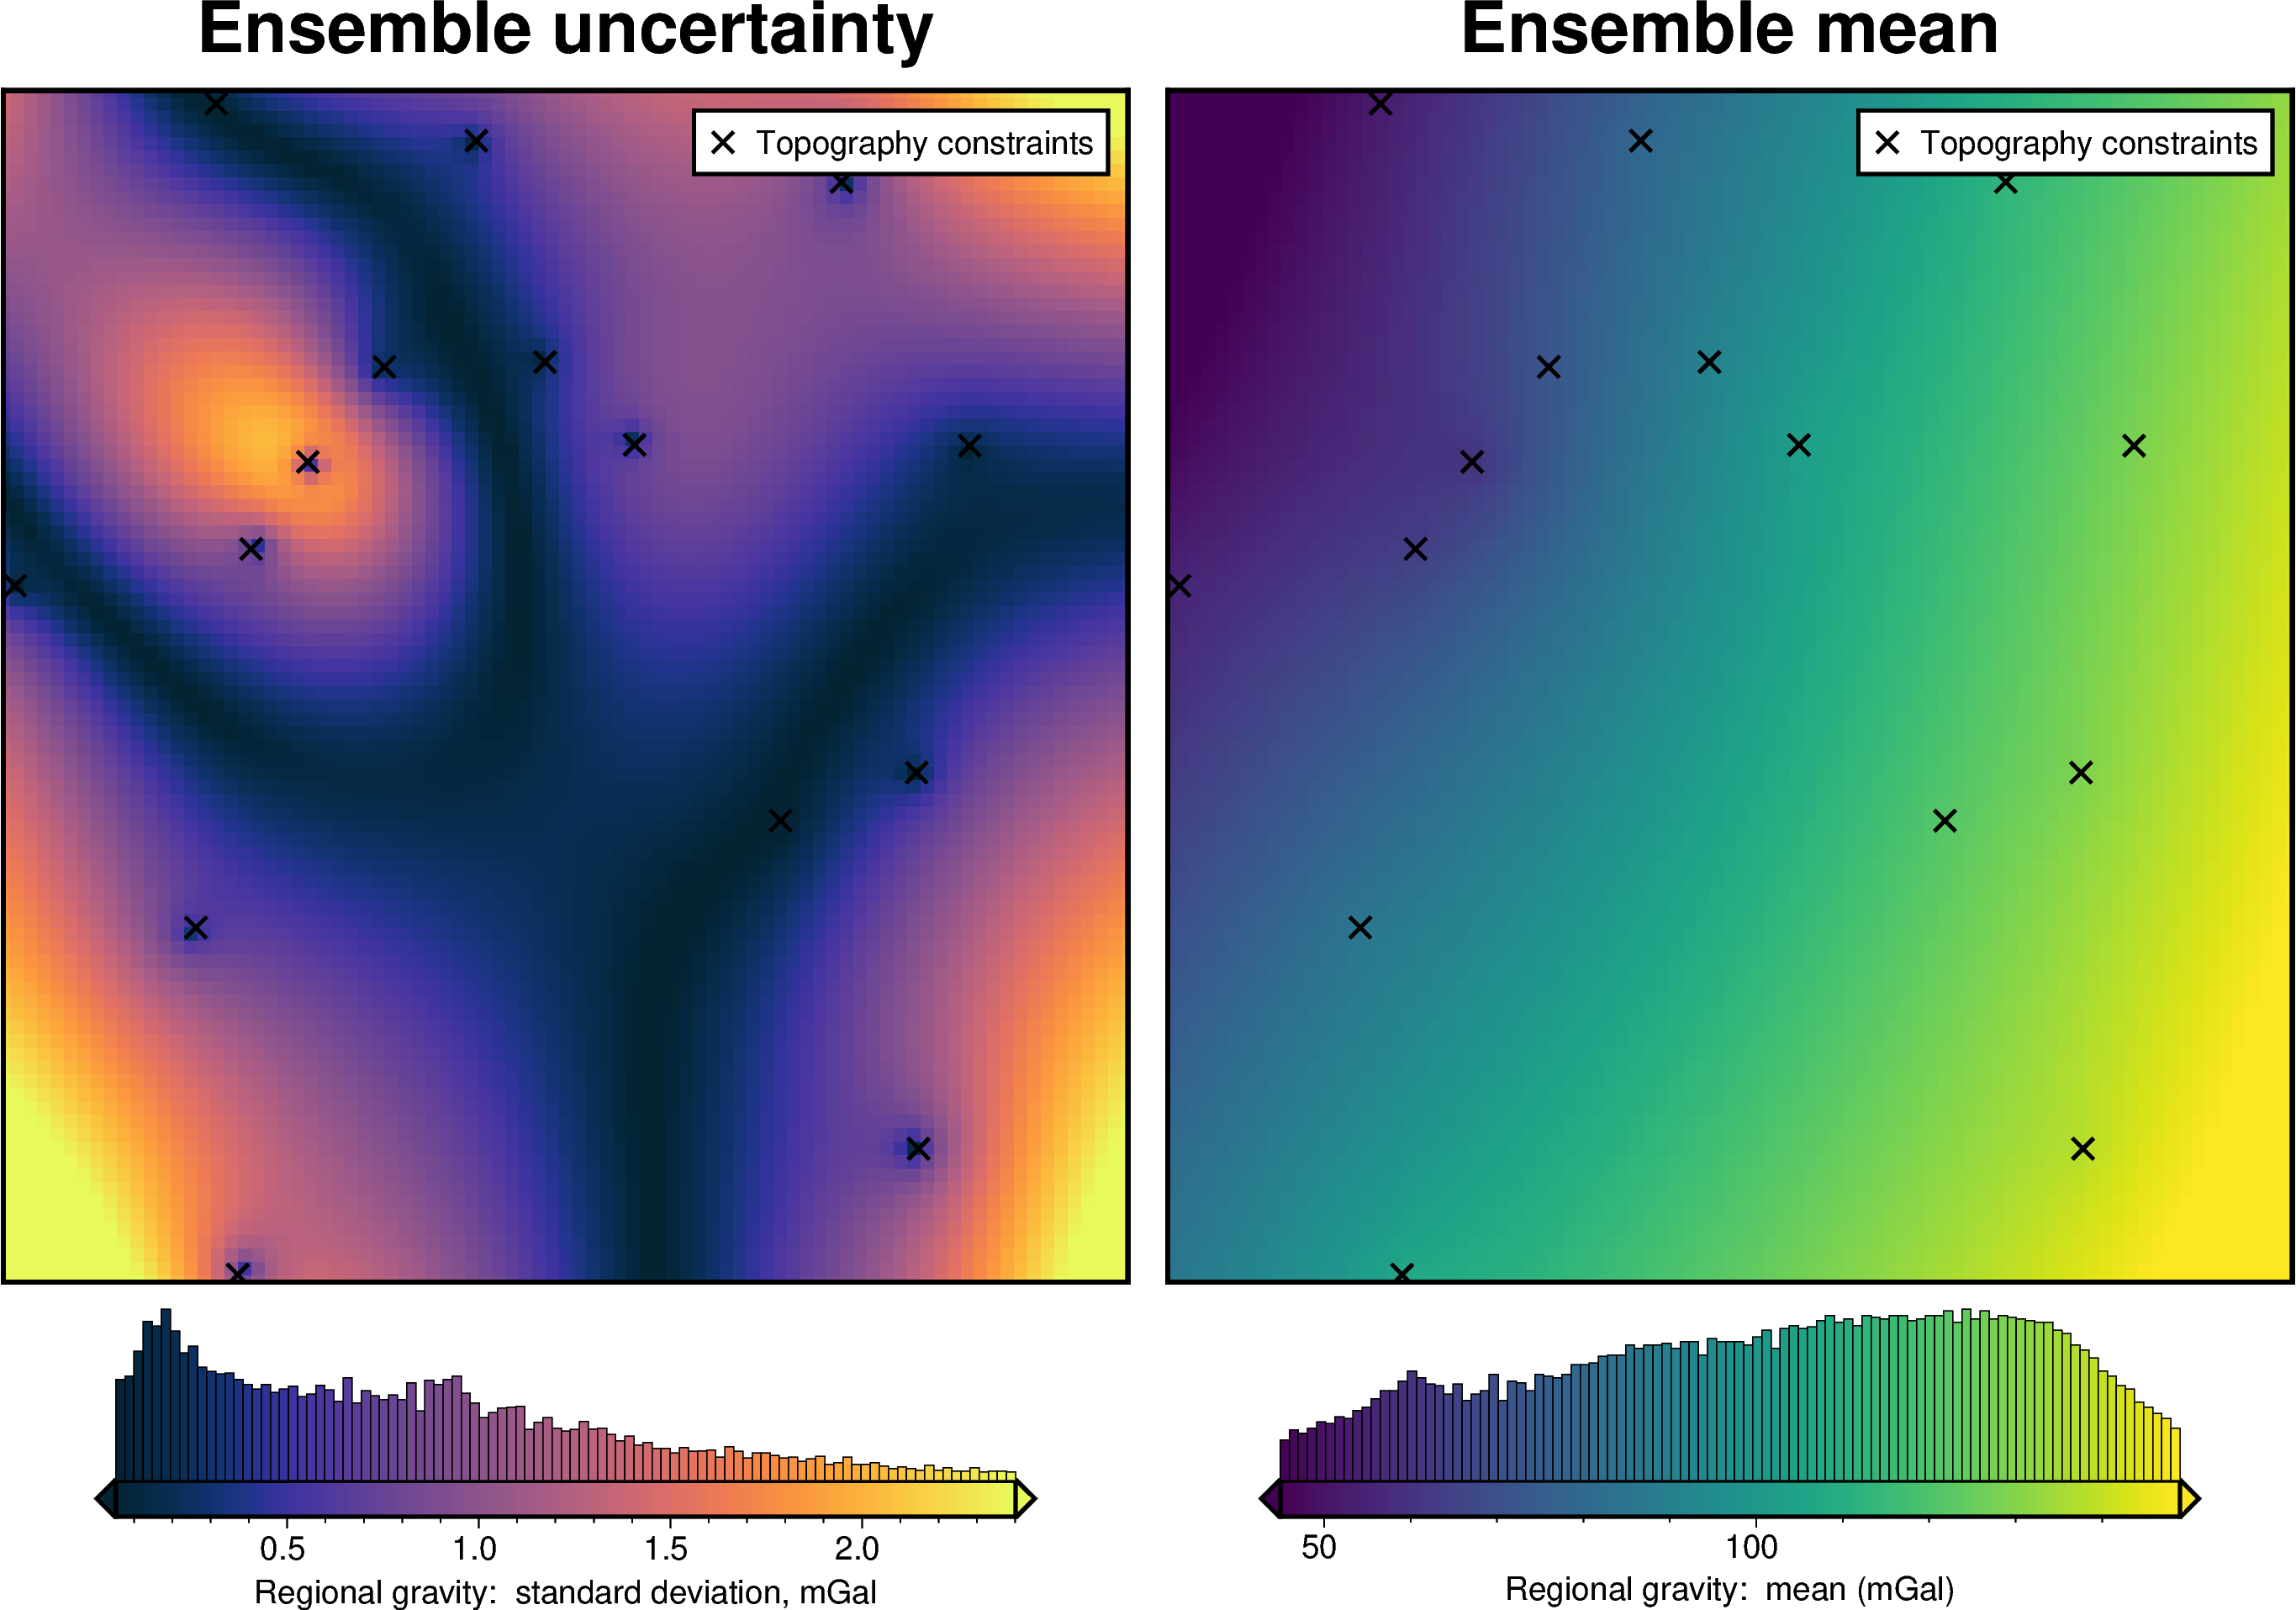

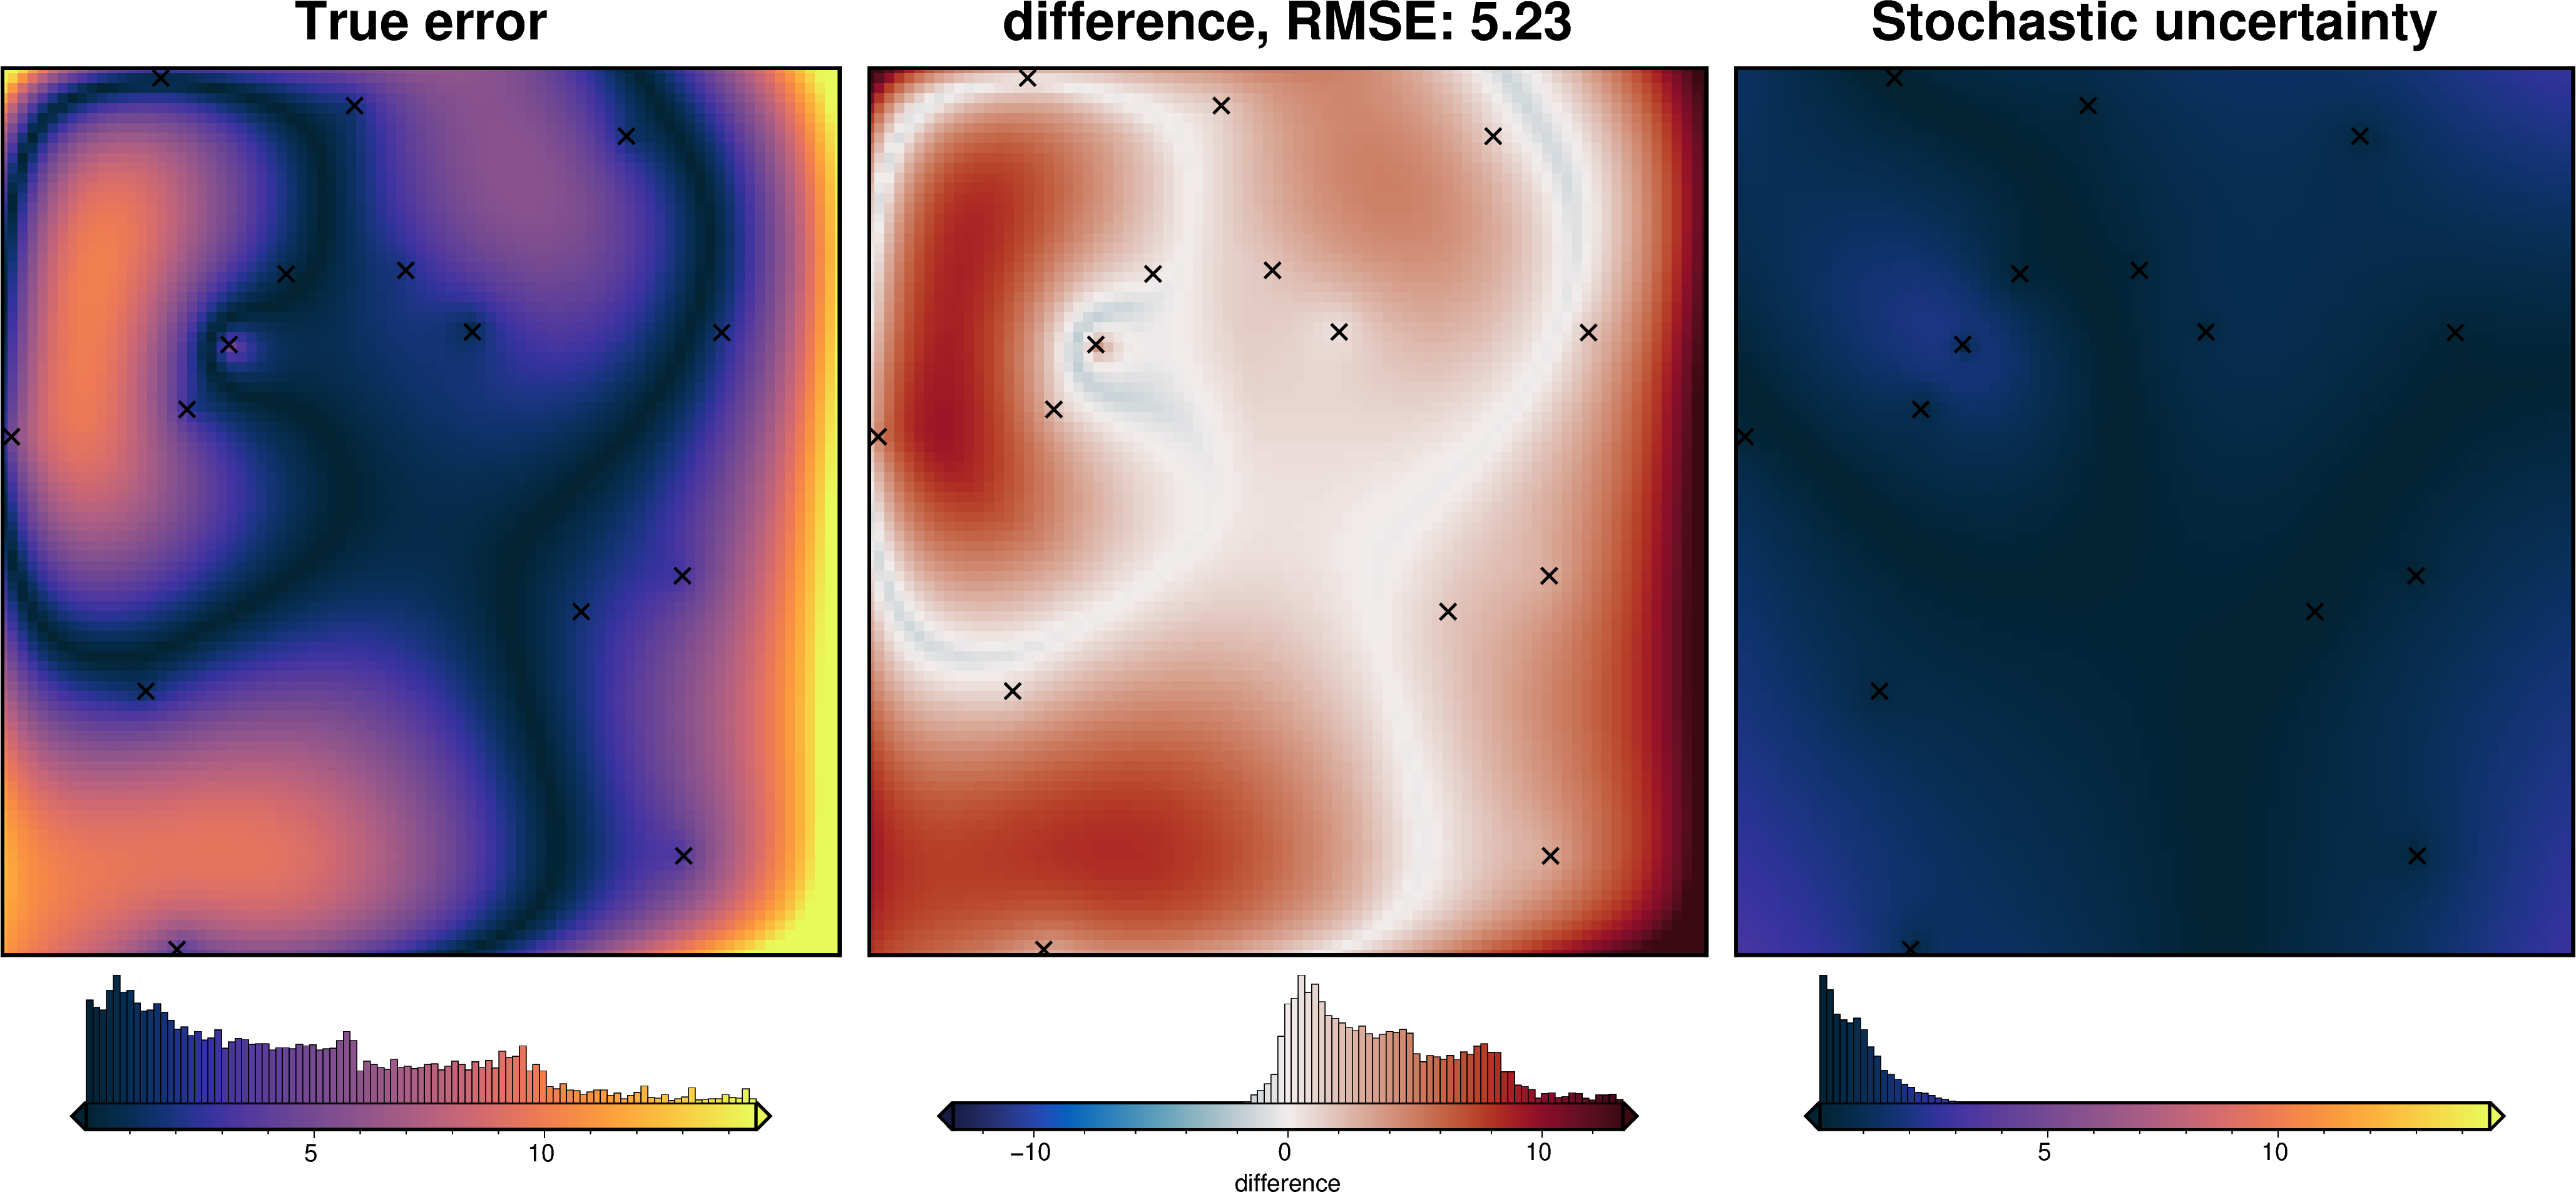

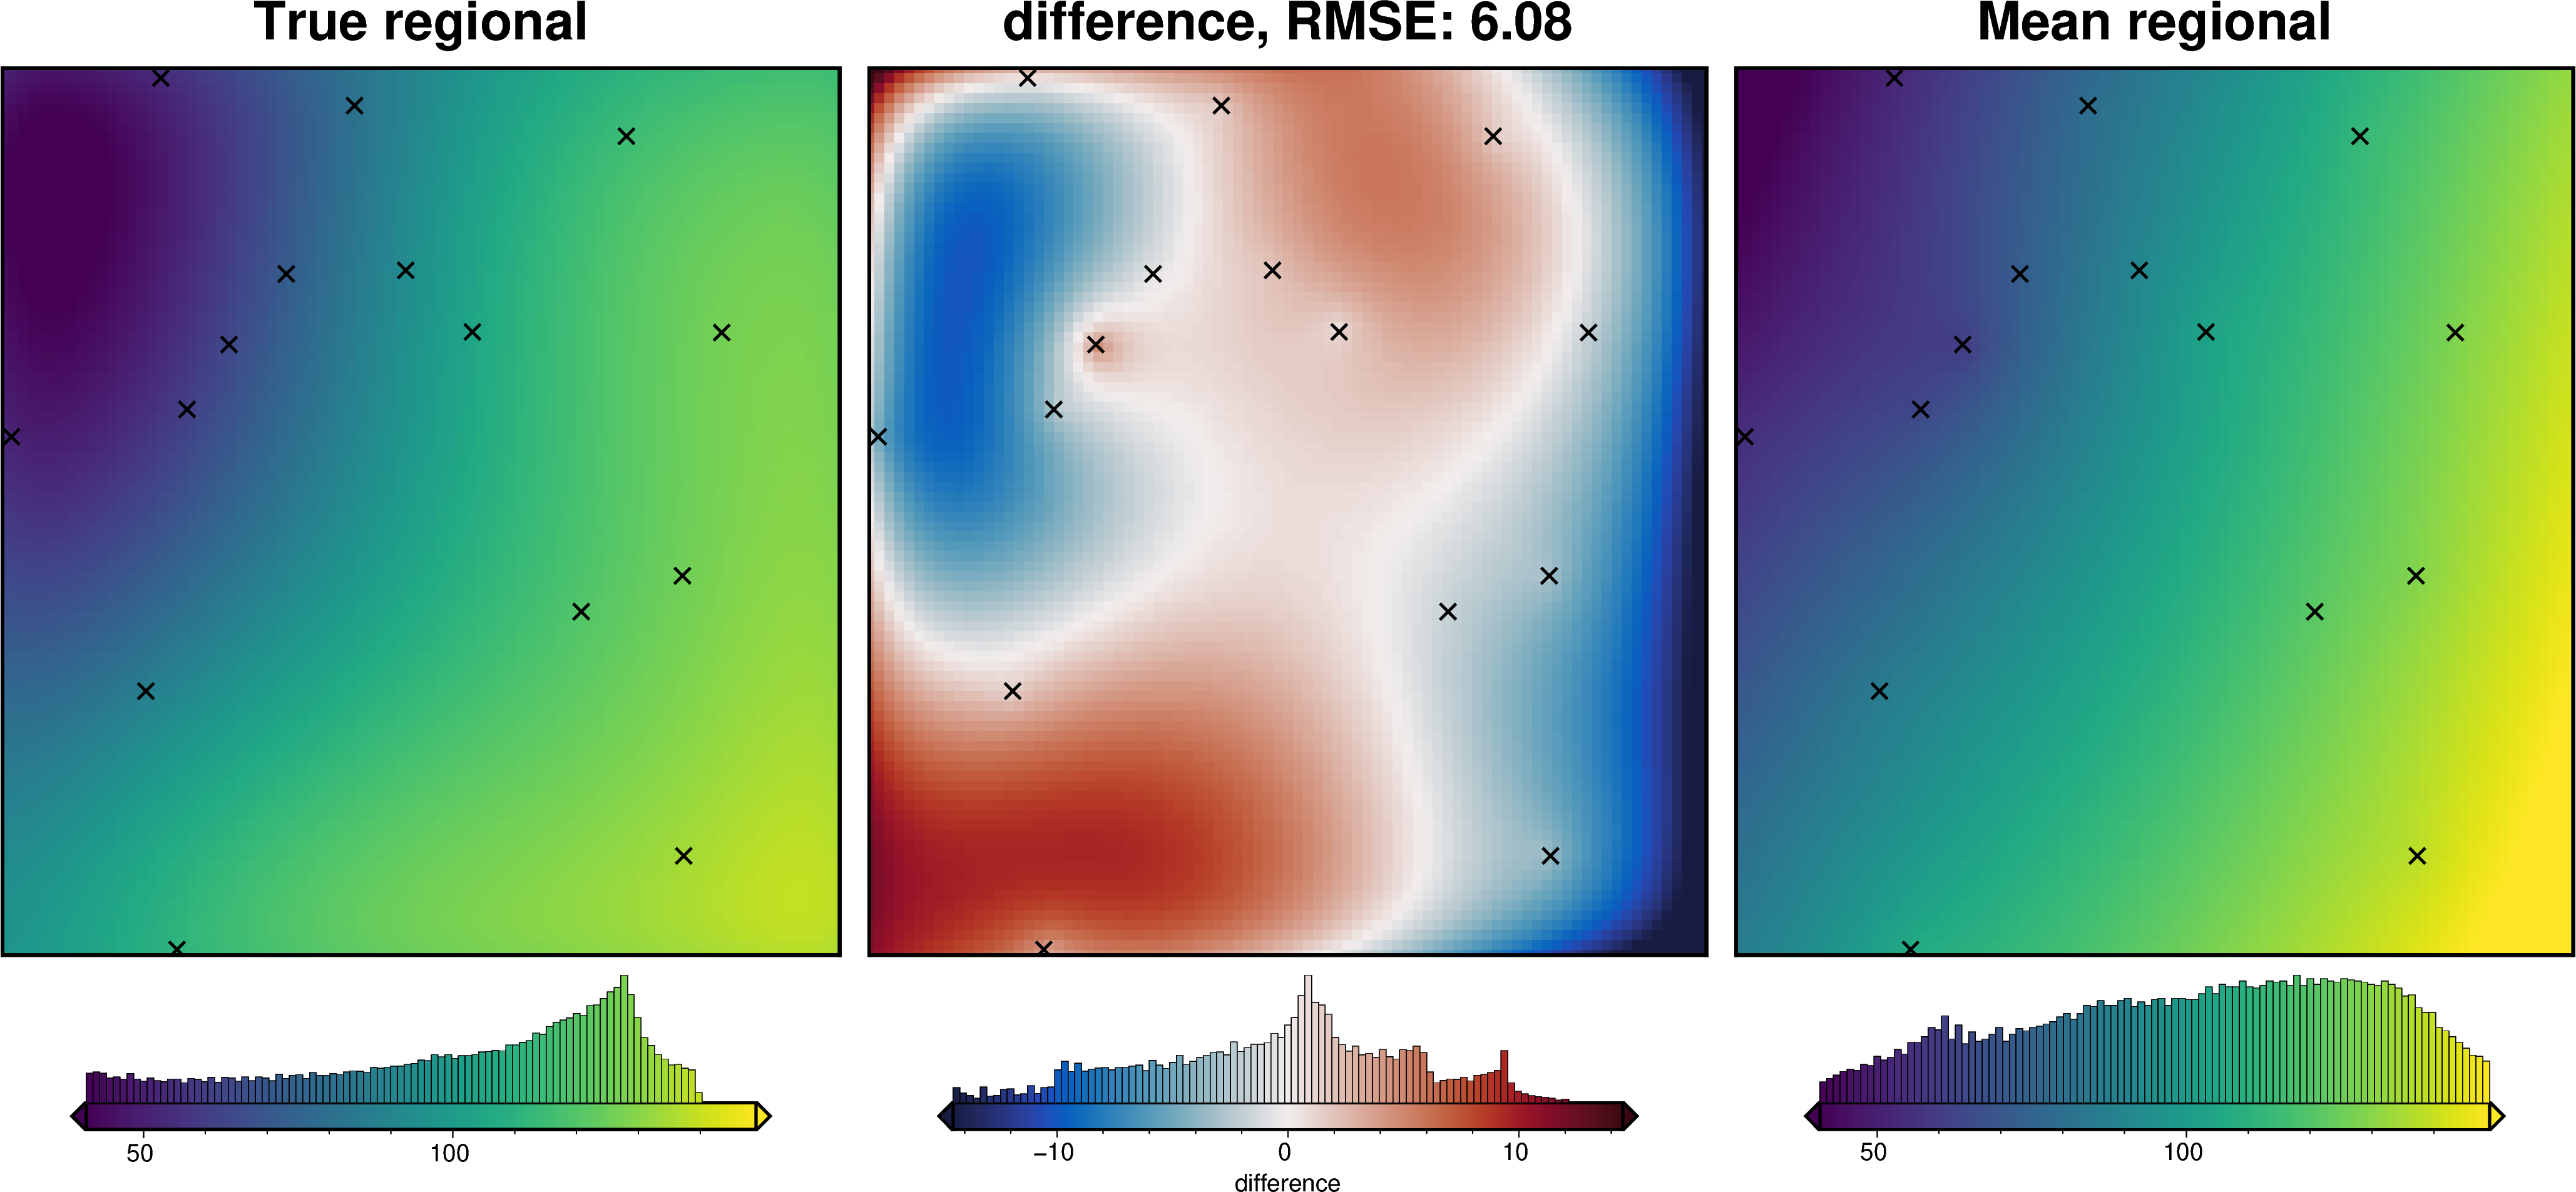

In [21]:
parameter_sampling_dict = {
    "tension_factor": {
        "distribution": "uniform",
        "loc": 0,  # lower bound
        "scale": 1,  # range
    },
}
regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    parameter_dict=parameter_sampling_dict,
    method="constraints",
    grid_method="pygmt",
    constraints_df=constraint_points,
    **kwargs,
)

##### Bi-Harmonic Splines with Verde

INFO:invert4geom:optimizing on minimizing the true regional misfit
INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 18
INFO:invert4geom:	parameter: {'spline_dampings': 3.794010453192731e-10}
INFO:invert4geom:	scores: [4.882578638851802]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


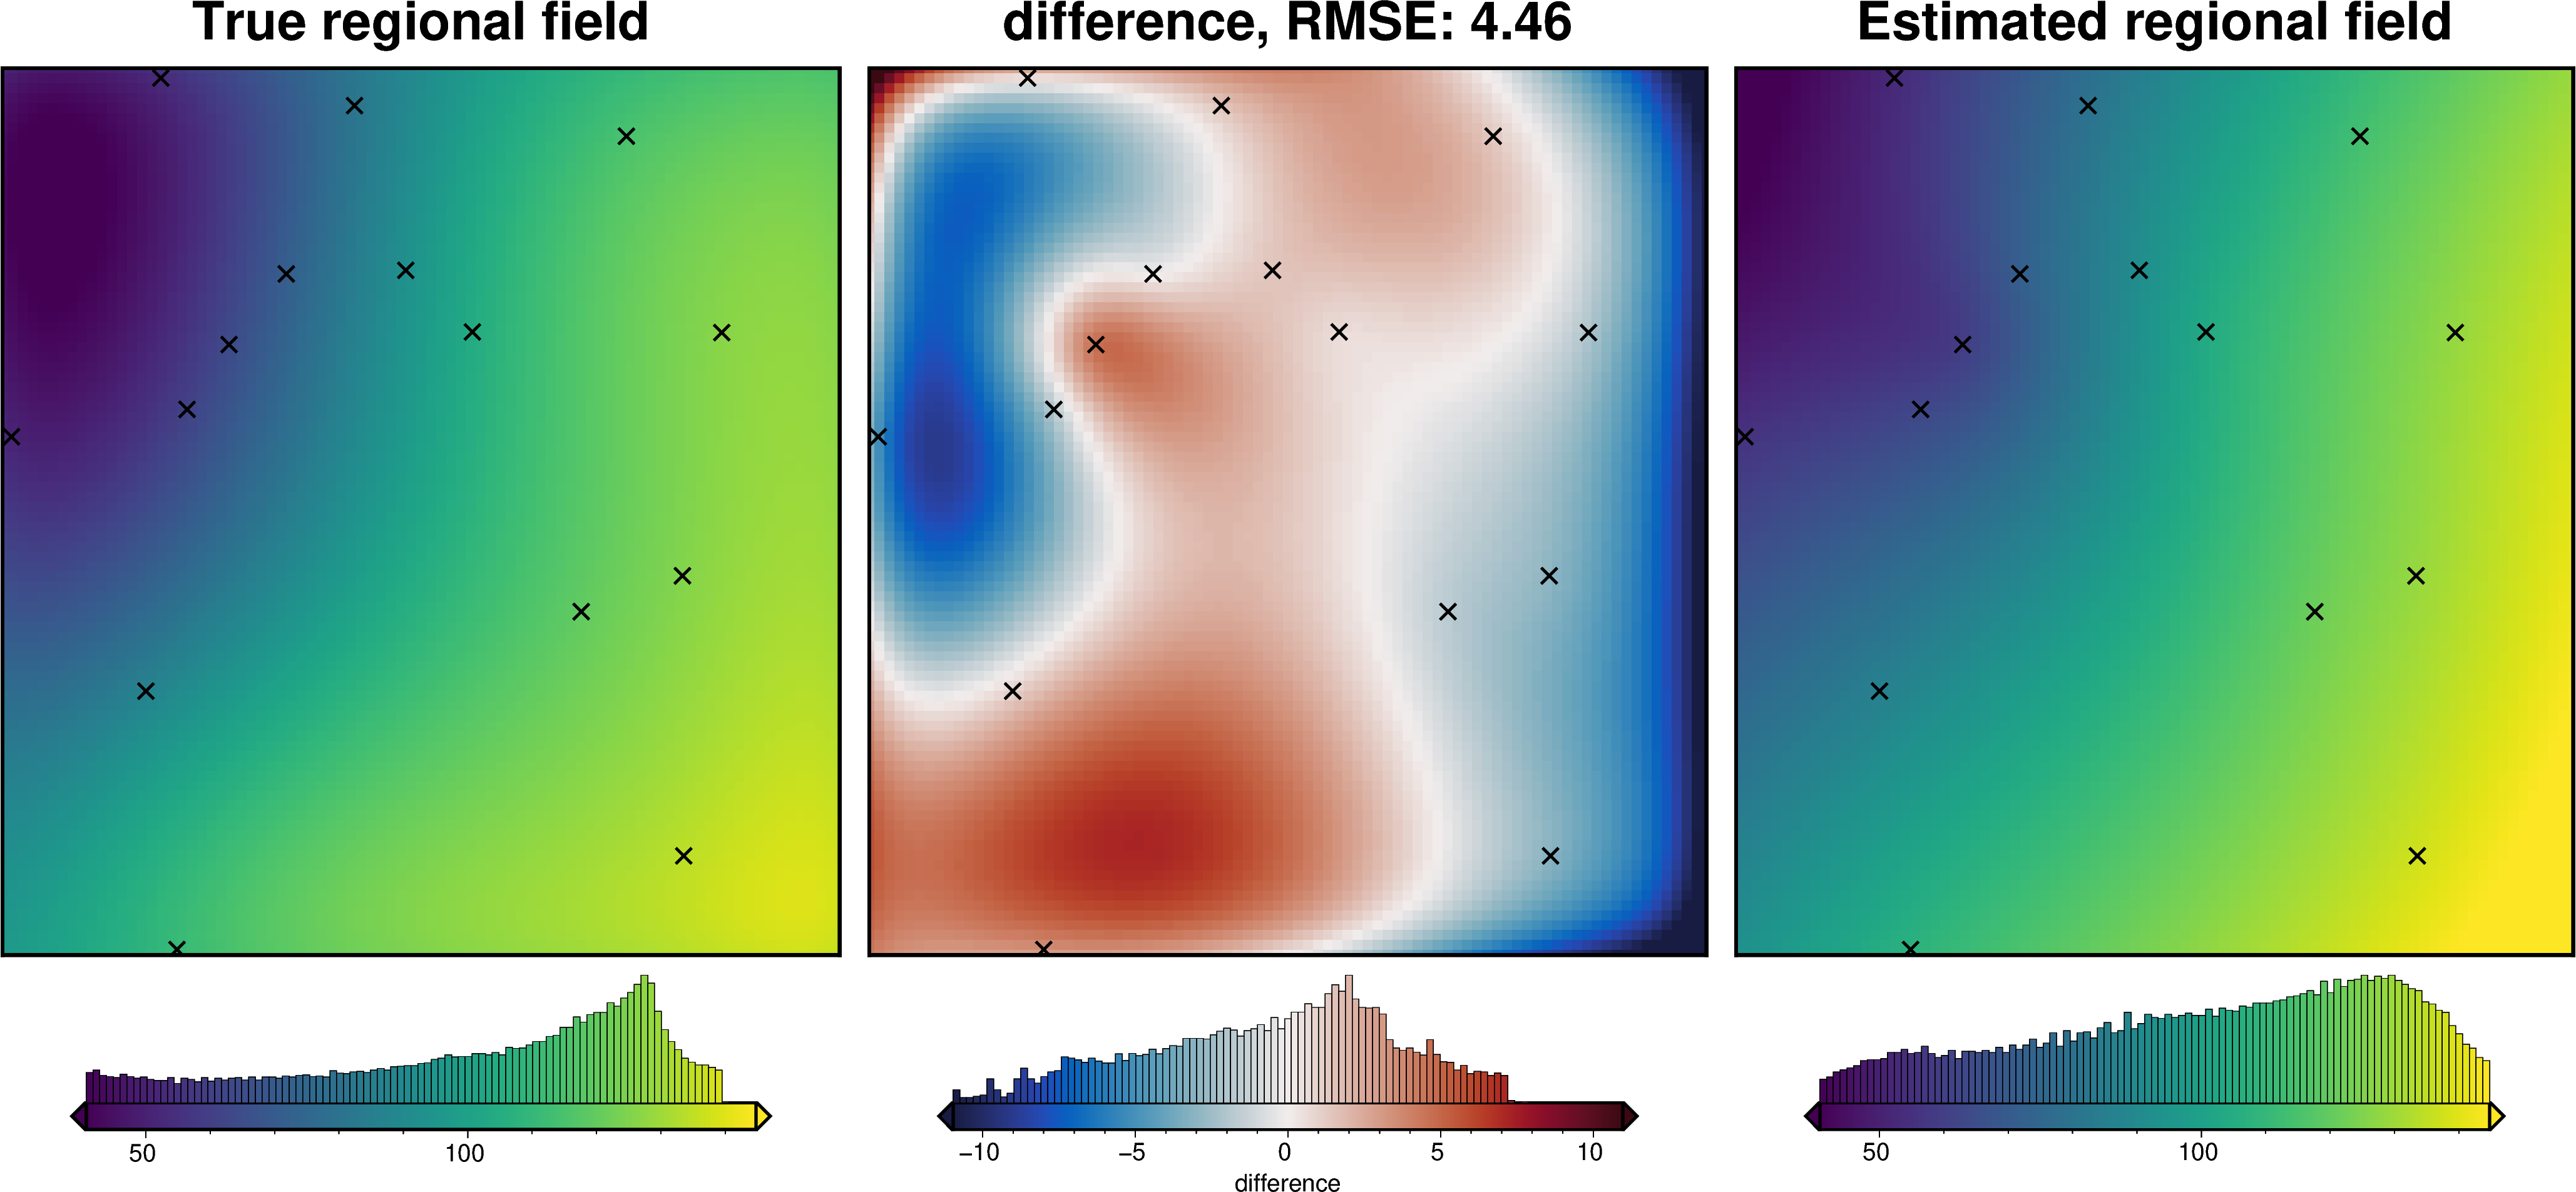

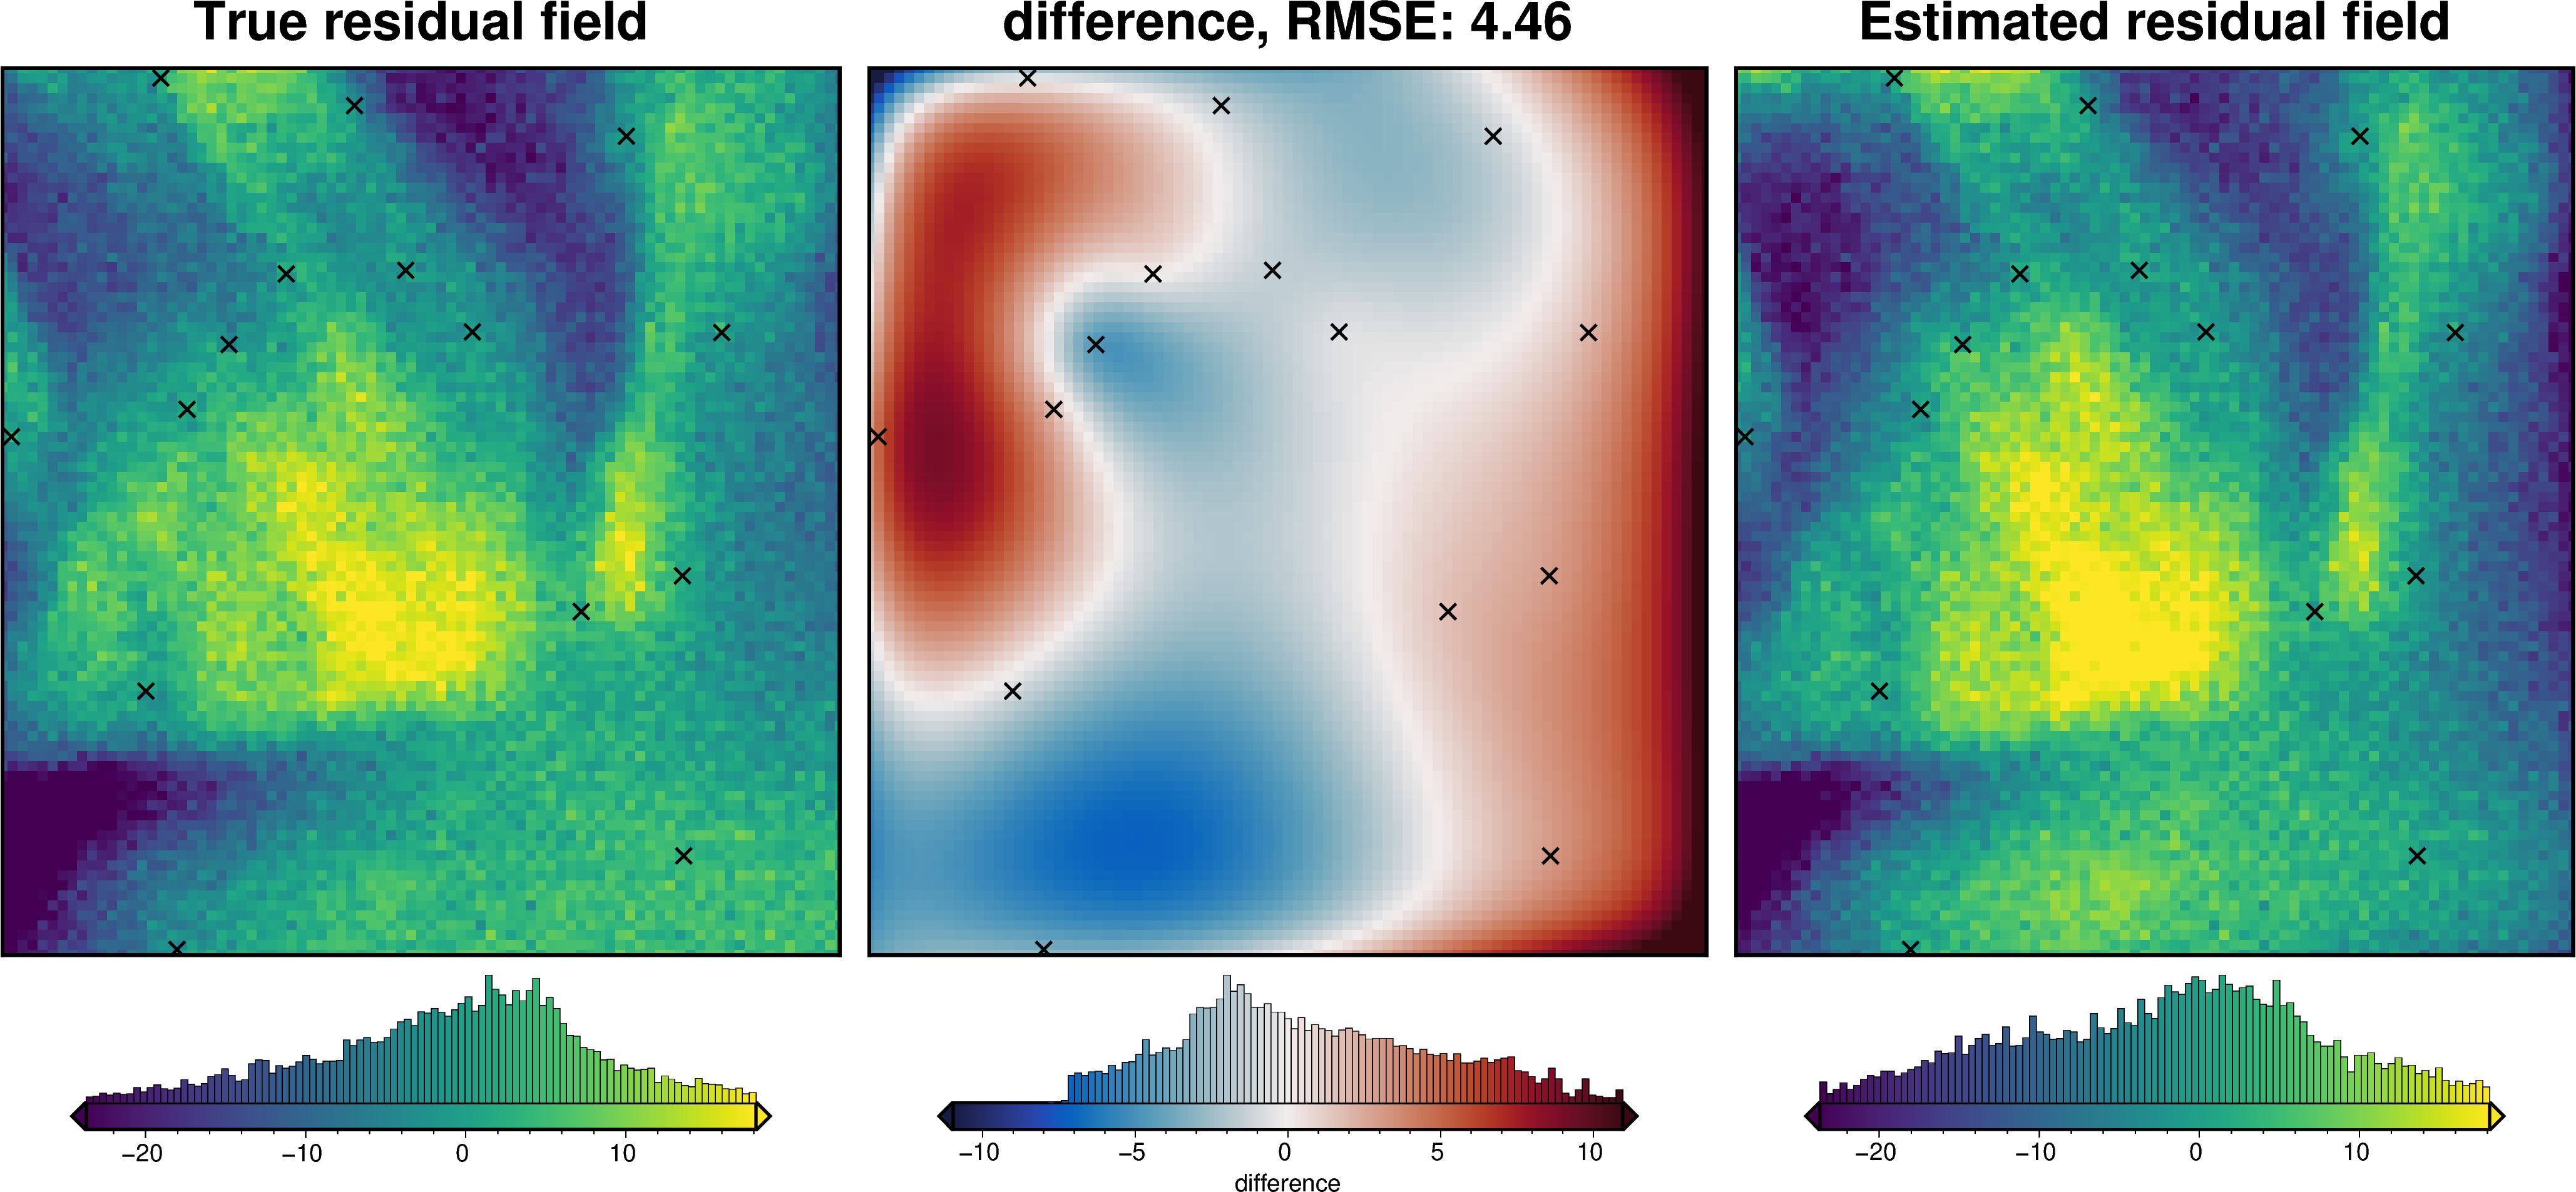

In [22]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="verde",
        spline_damping_limits=[1e-15, 1],
        n_trials=20,
        plot=True,
        fname="tmp/study",
        optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)
regional_comparison(grav_df)

INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Number of trials on the Pareto front: 16
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'spline_dampings': 2.046788714905806e-09}
INFO:invert4geom:	scores: [3.301546699407163, 10.518172716422914]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


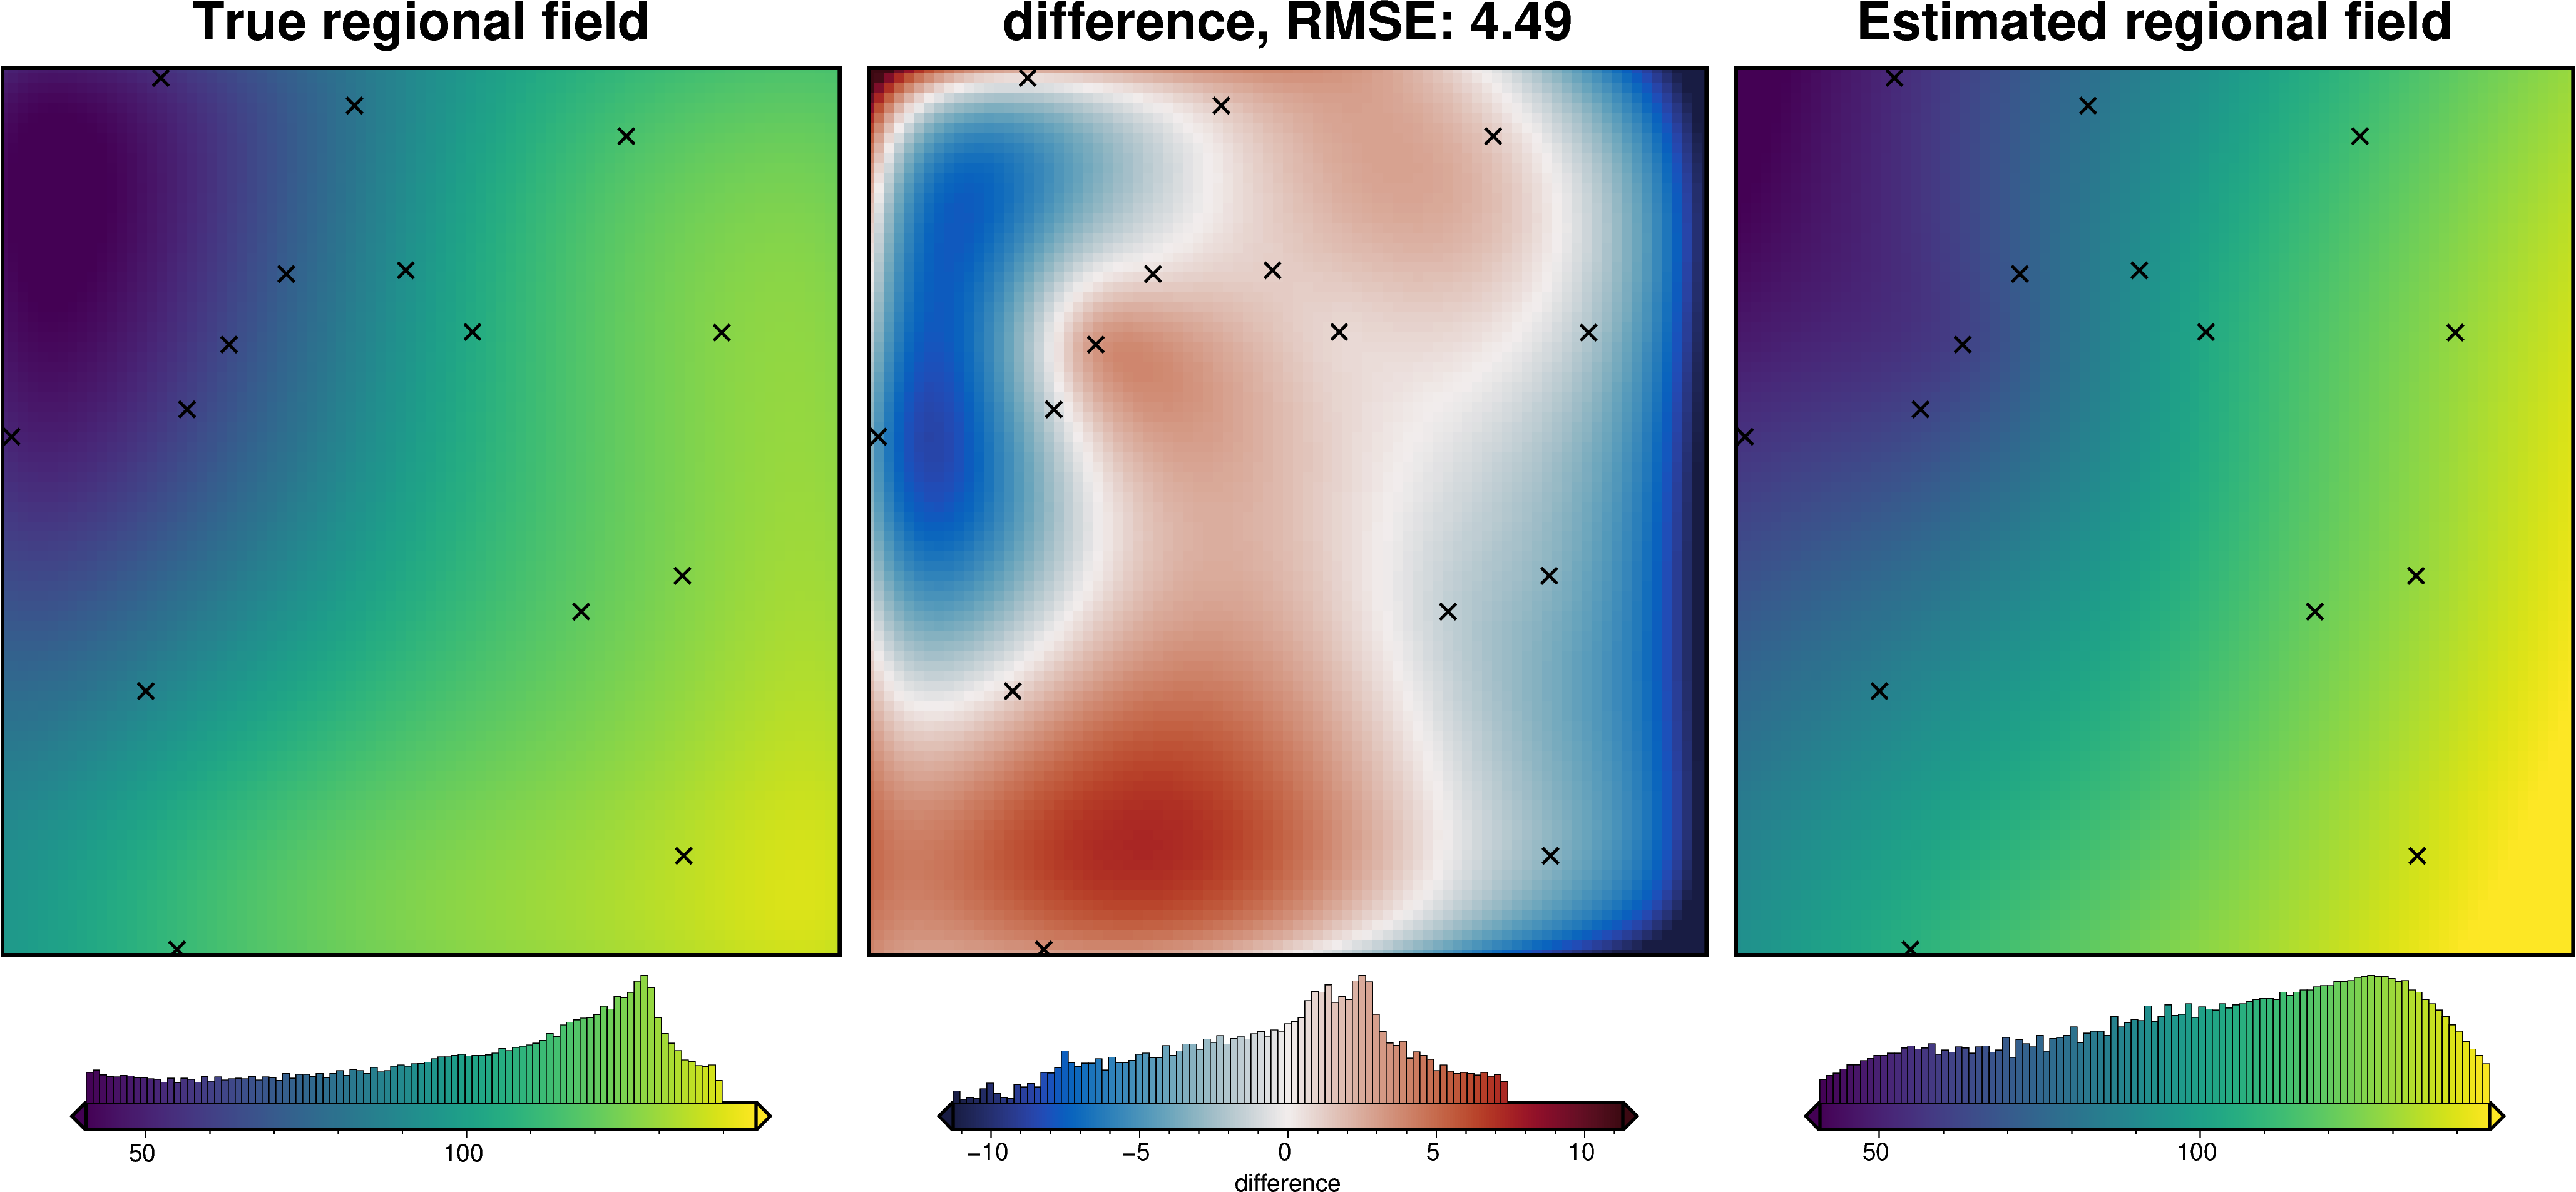

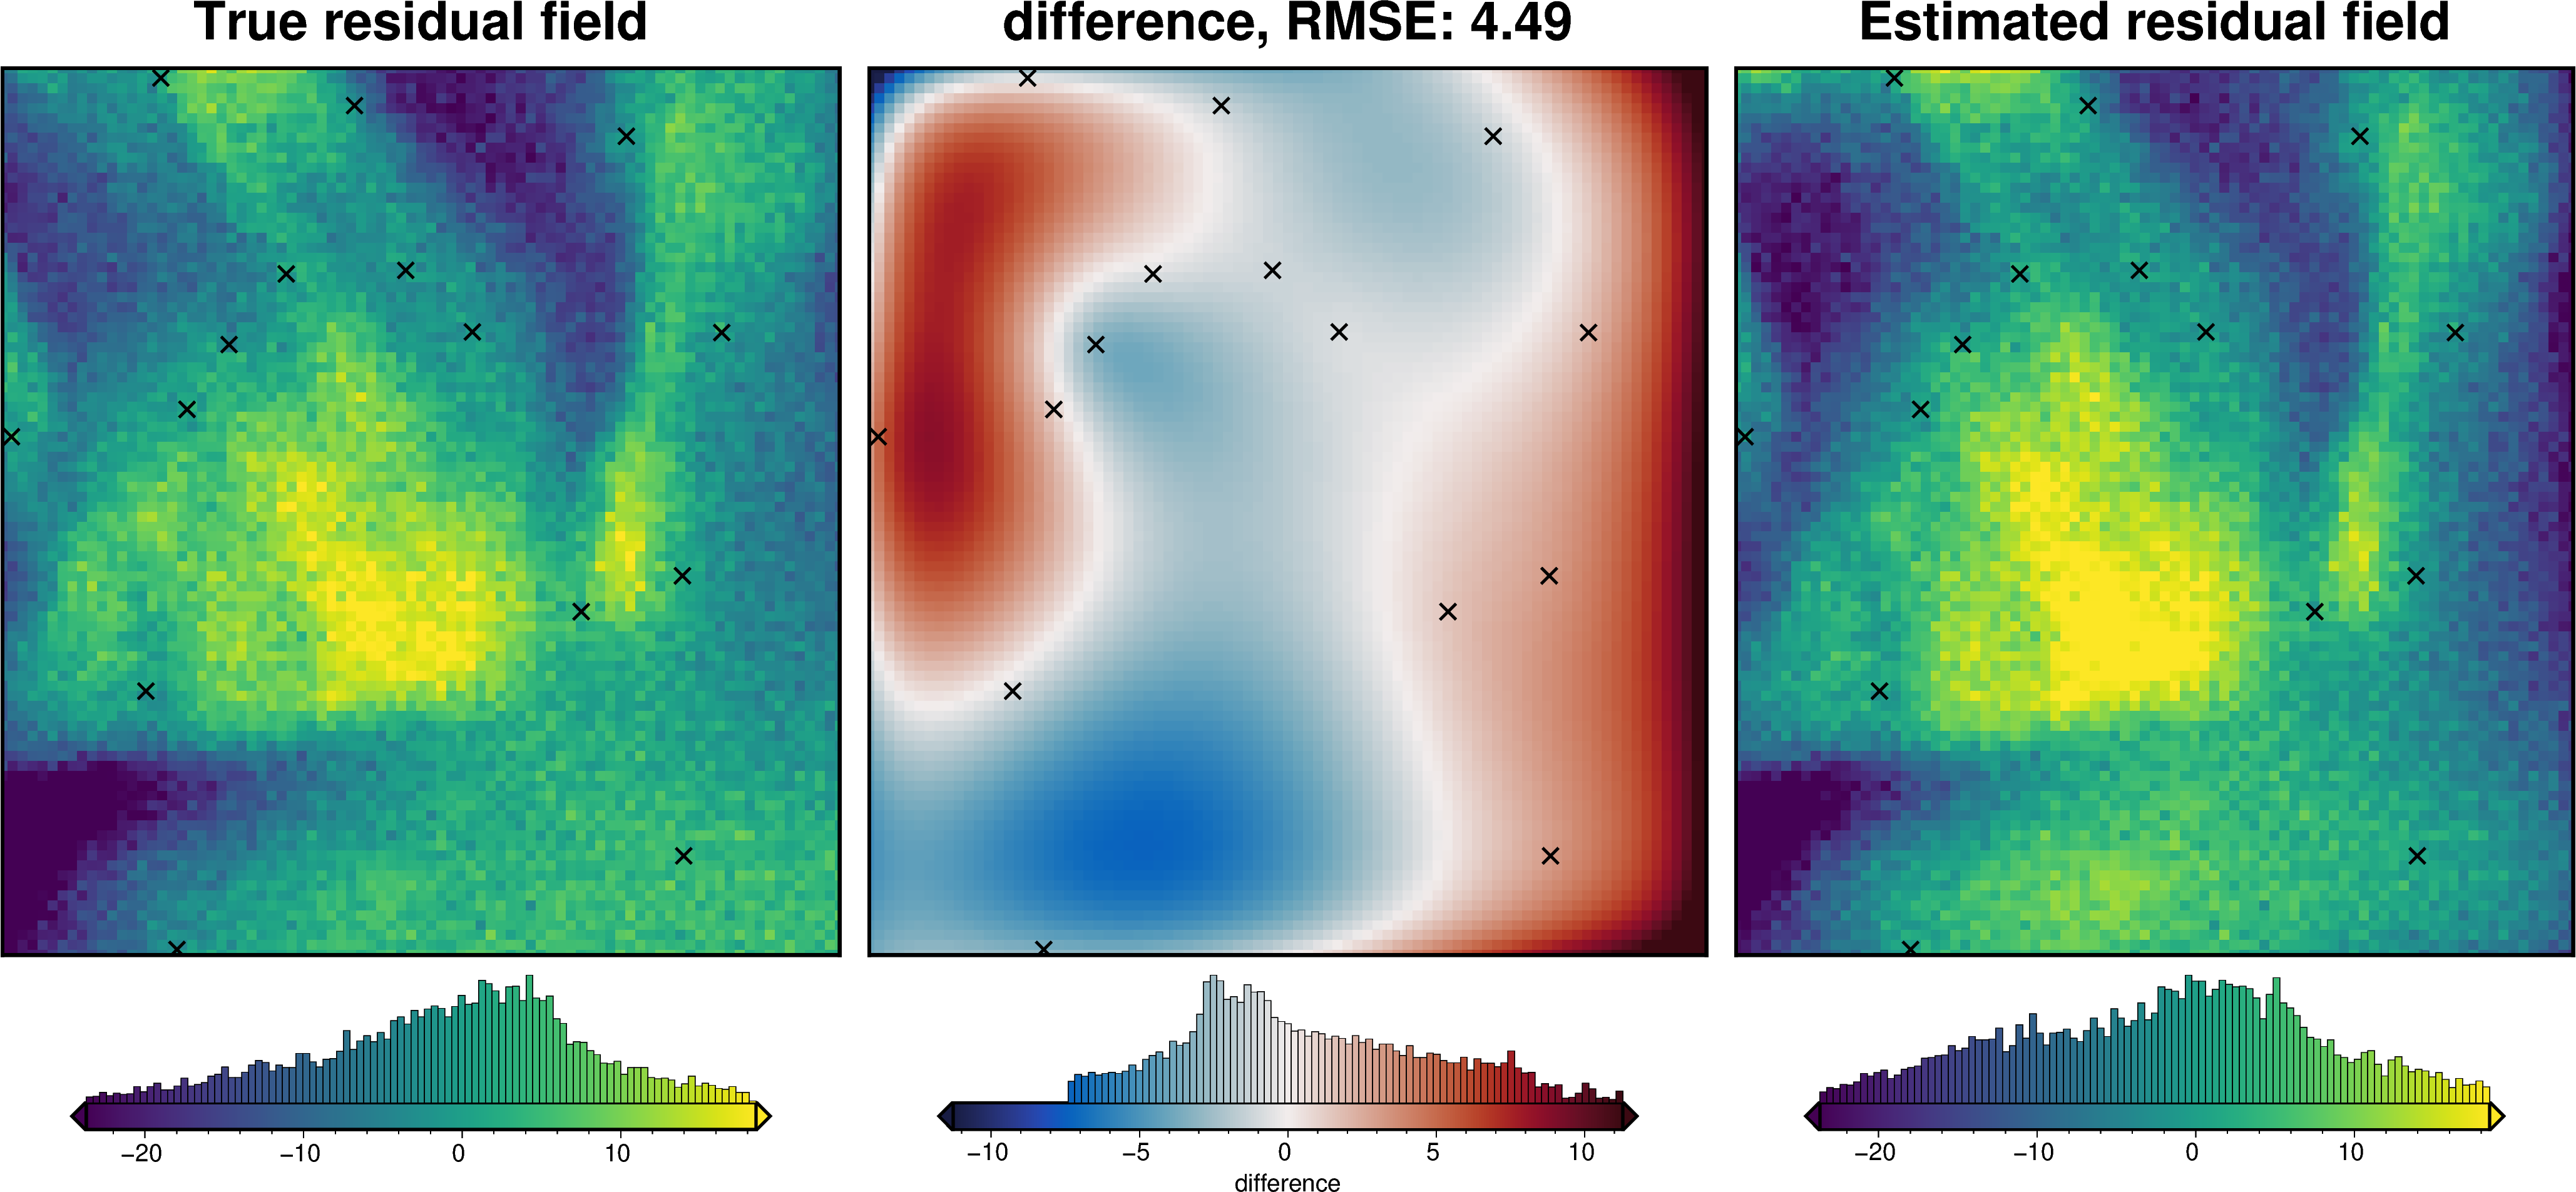

In [23]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="verde",
        spline_damping_limits=[1e-15, 1],
        n_trials=20,
        plot=True,
        fname="tmp/study",
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)
regional_comparison(grav_df)

Alternatively, we can use an internal cross-validation (CV) which finds the parameters which create the best fit to the sampled residual values at the constraints. This is faster and simpler, as the only step that is repeated for the CV is the fitting of splines to the data, and not the entire process of sample the misfit and remove the regional from this misfit to get the residual. However, this is less informed than the above K-fold CV as it isn't attempting to retain a high amplitude residual field, just trying to fit the data as best as possible.

INFO:invert4geom:Best SplineCV score: 0.8526278884257265
INFO:invert4geom:Best damping: None


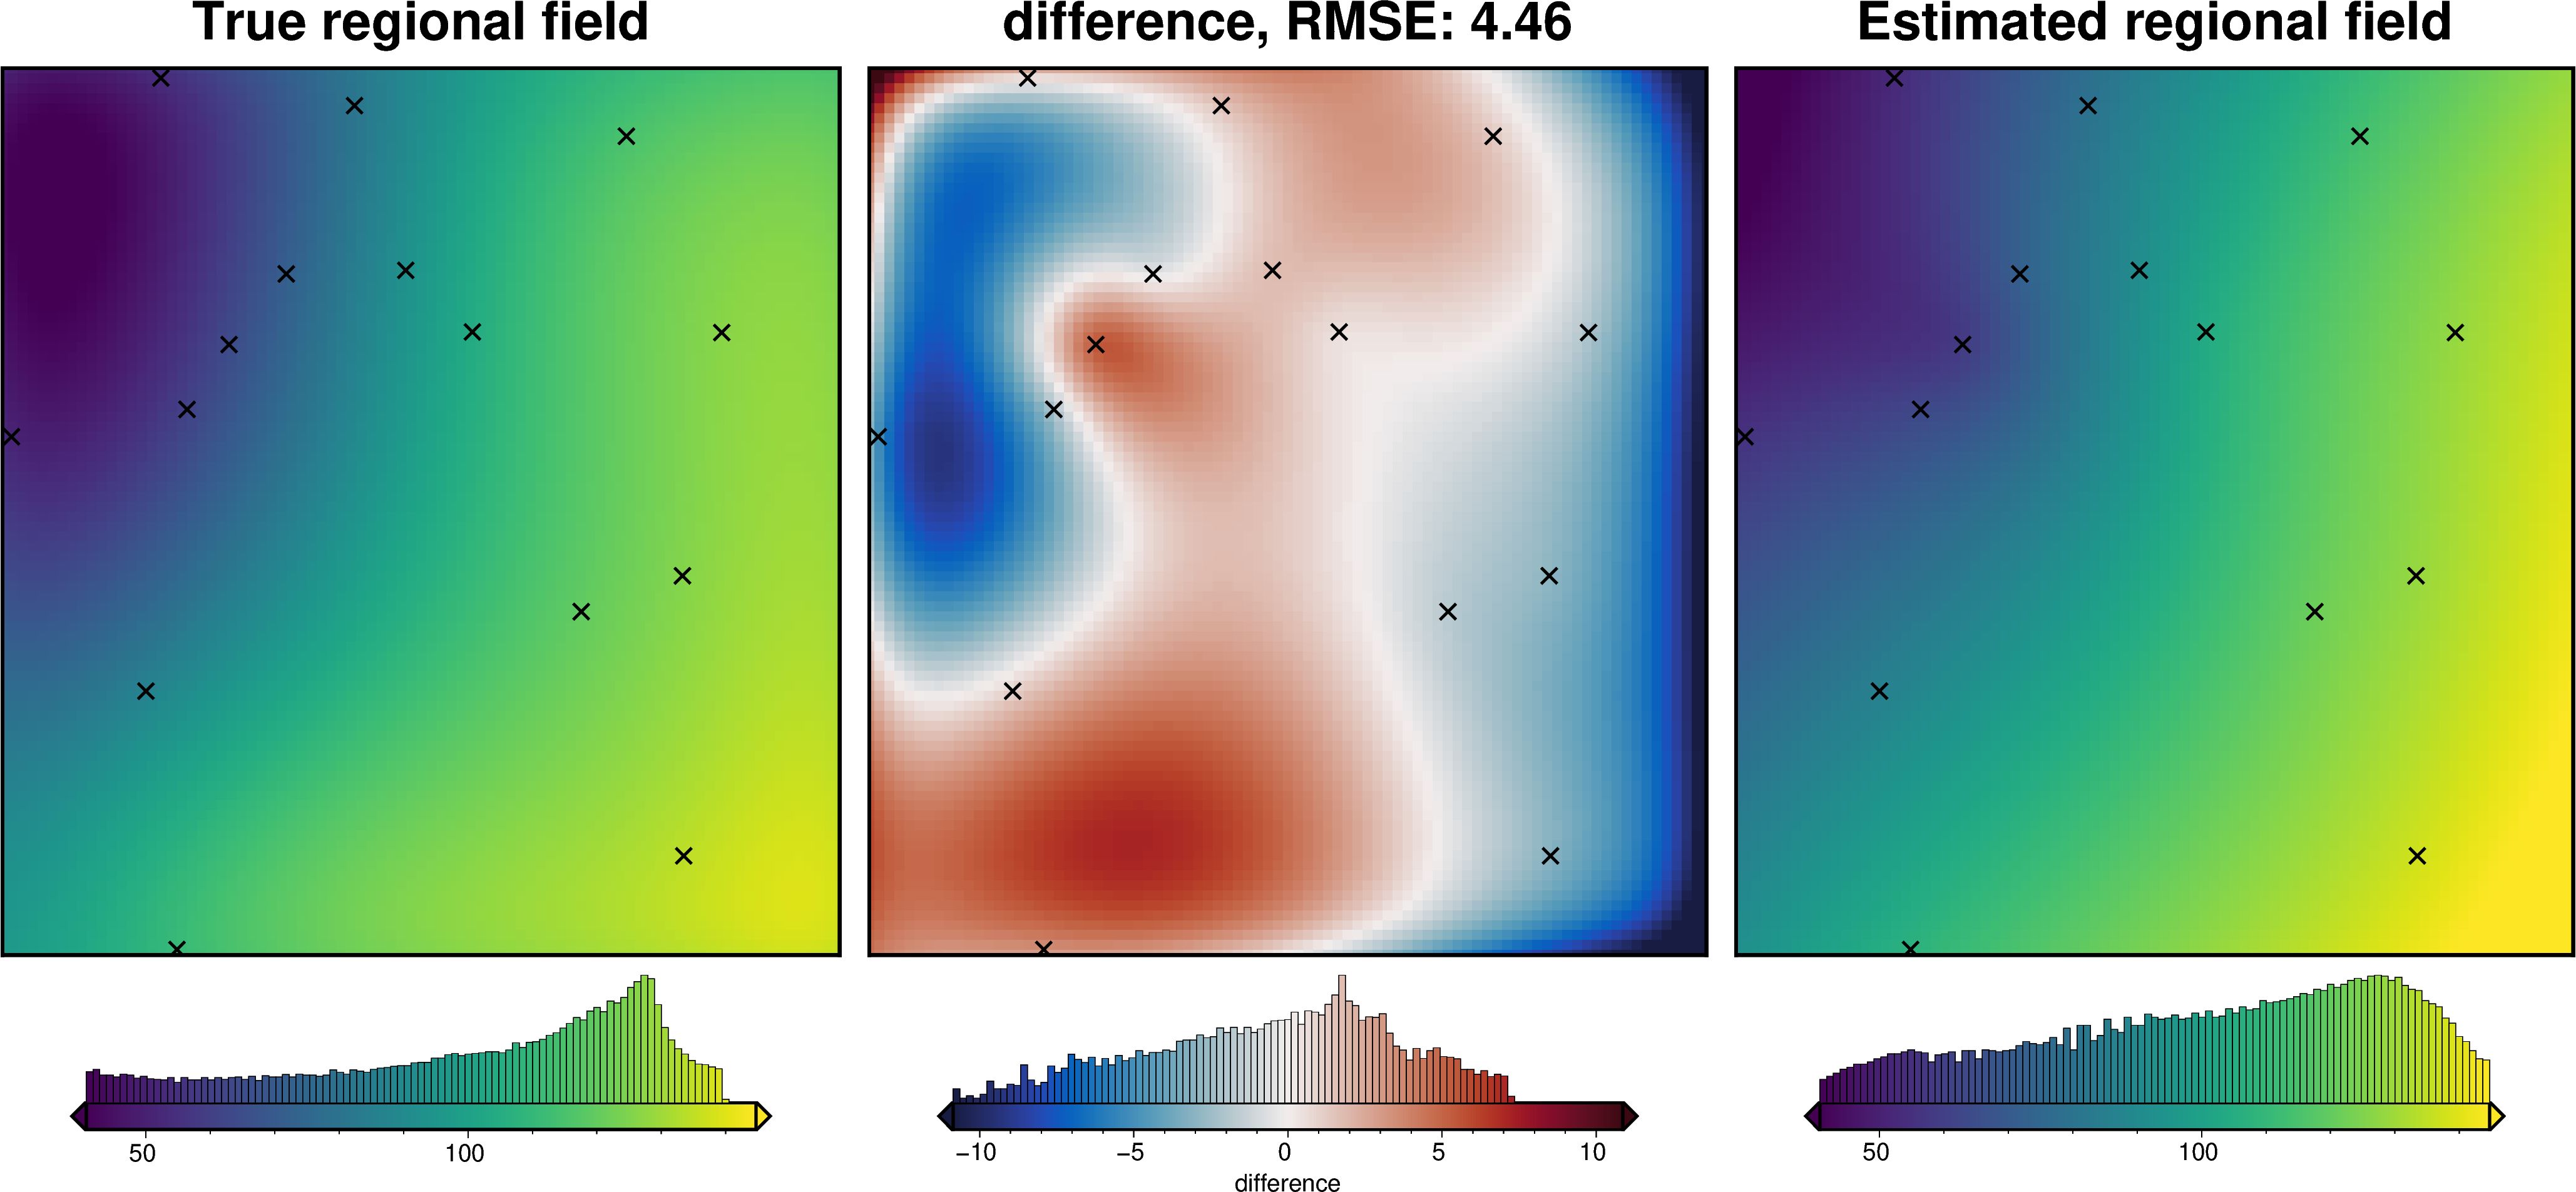

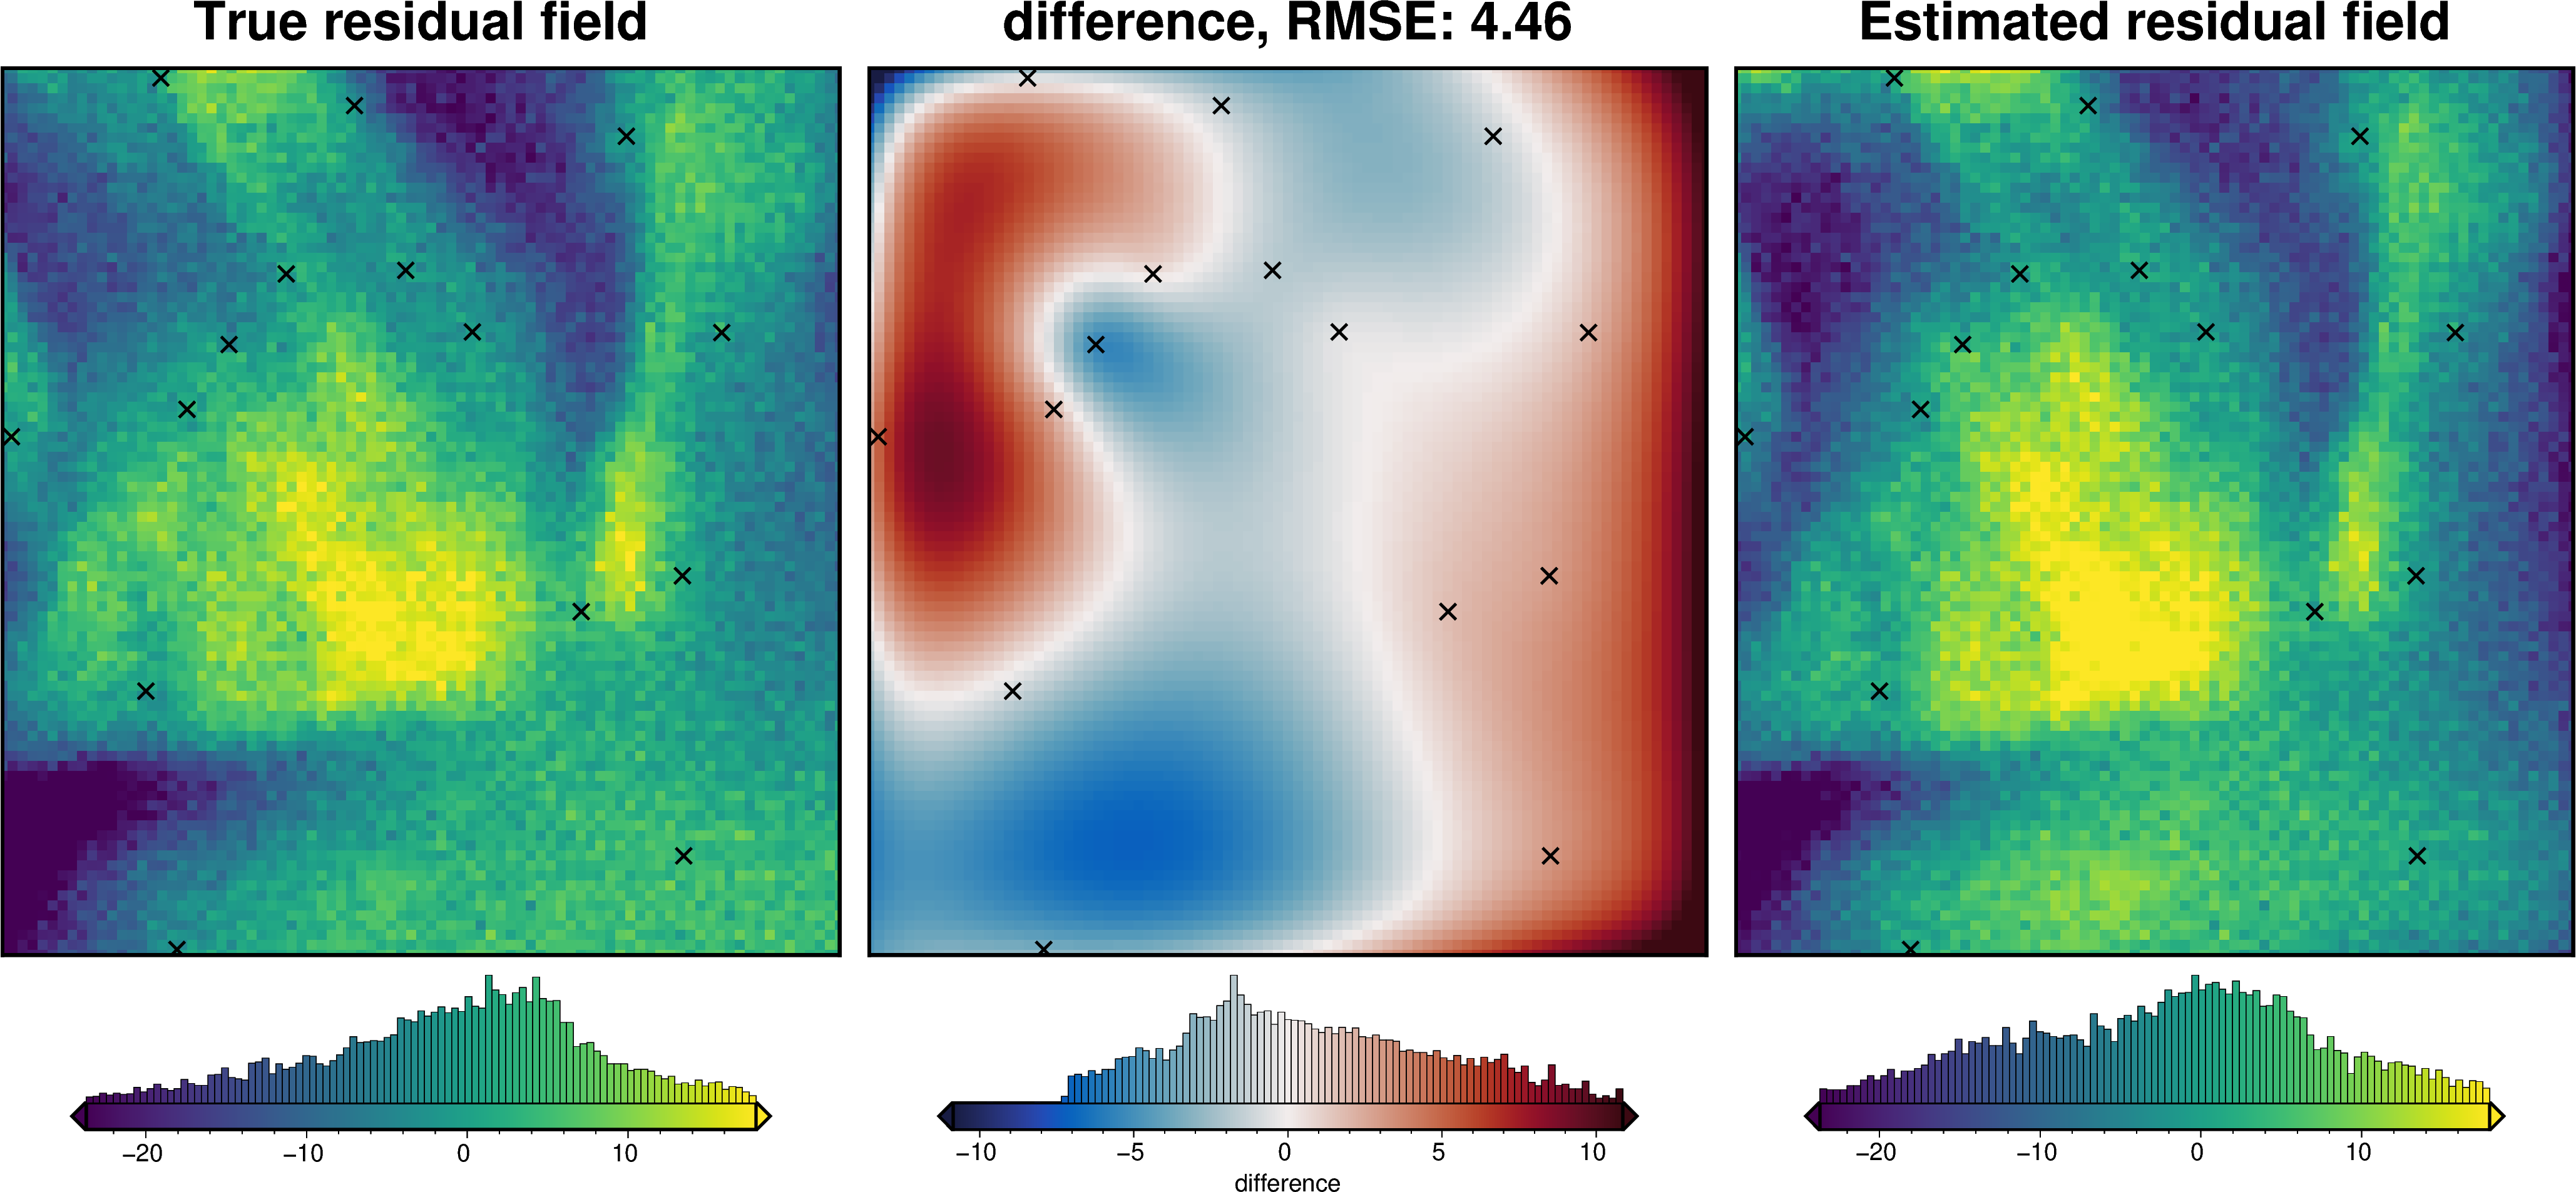

In [24]:
grav_df = regional.regional_separation(
    method="constraints",
    grid_method="verde",
    constraints_df=constraint_points,
    spline_dampings=[*list(np.logspace(-20, 1, 100)), None],
    **kwargs2,
)
regional_comparison(grav_df)

In [25]:
best_trial.params["spline_dampings"]

2.046788714905806e-09

In [26]:
np.log10(best_trial.params["spline_dampings"])

np.float64(-8.688926986202386)

INFO:invert4geom:Sampled 'spline_dampings' parameter values; mean: 1.8639142998664653e-06, min: 6.733913890709276e-14, max: 6.22126167851033e-05


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

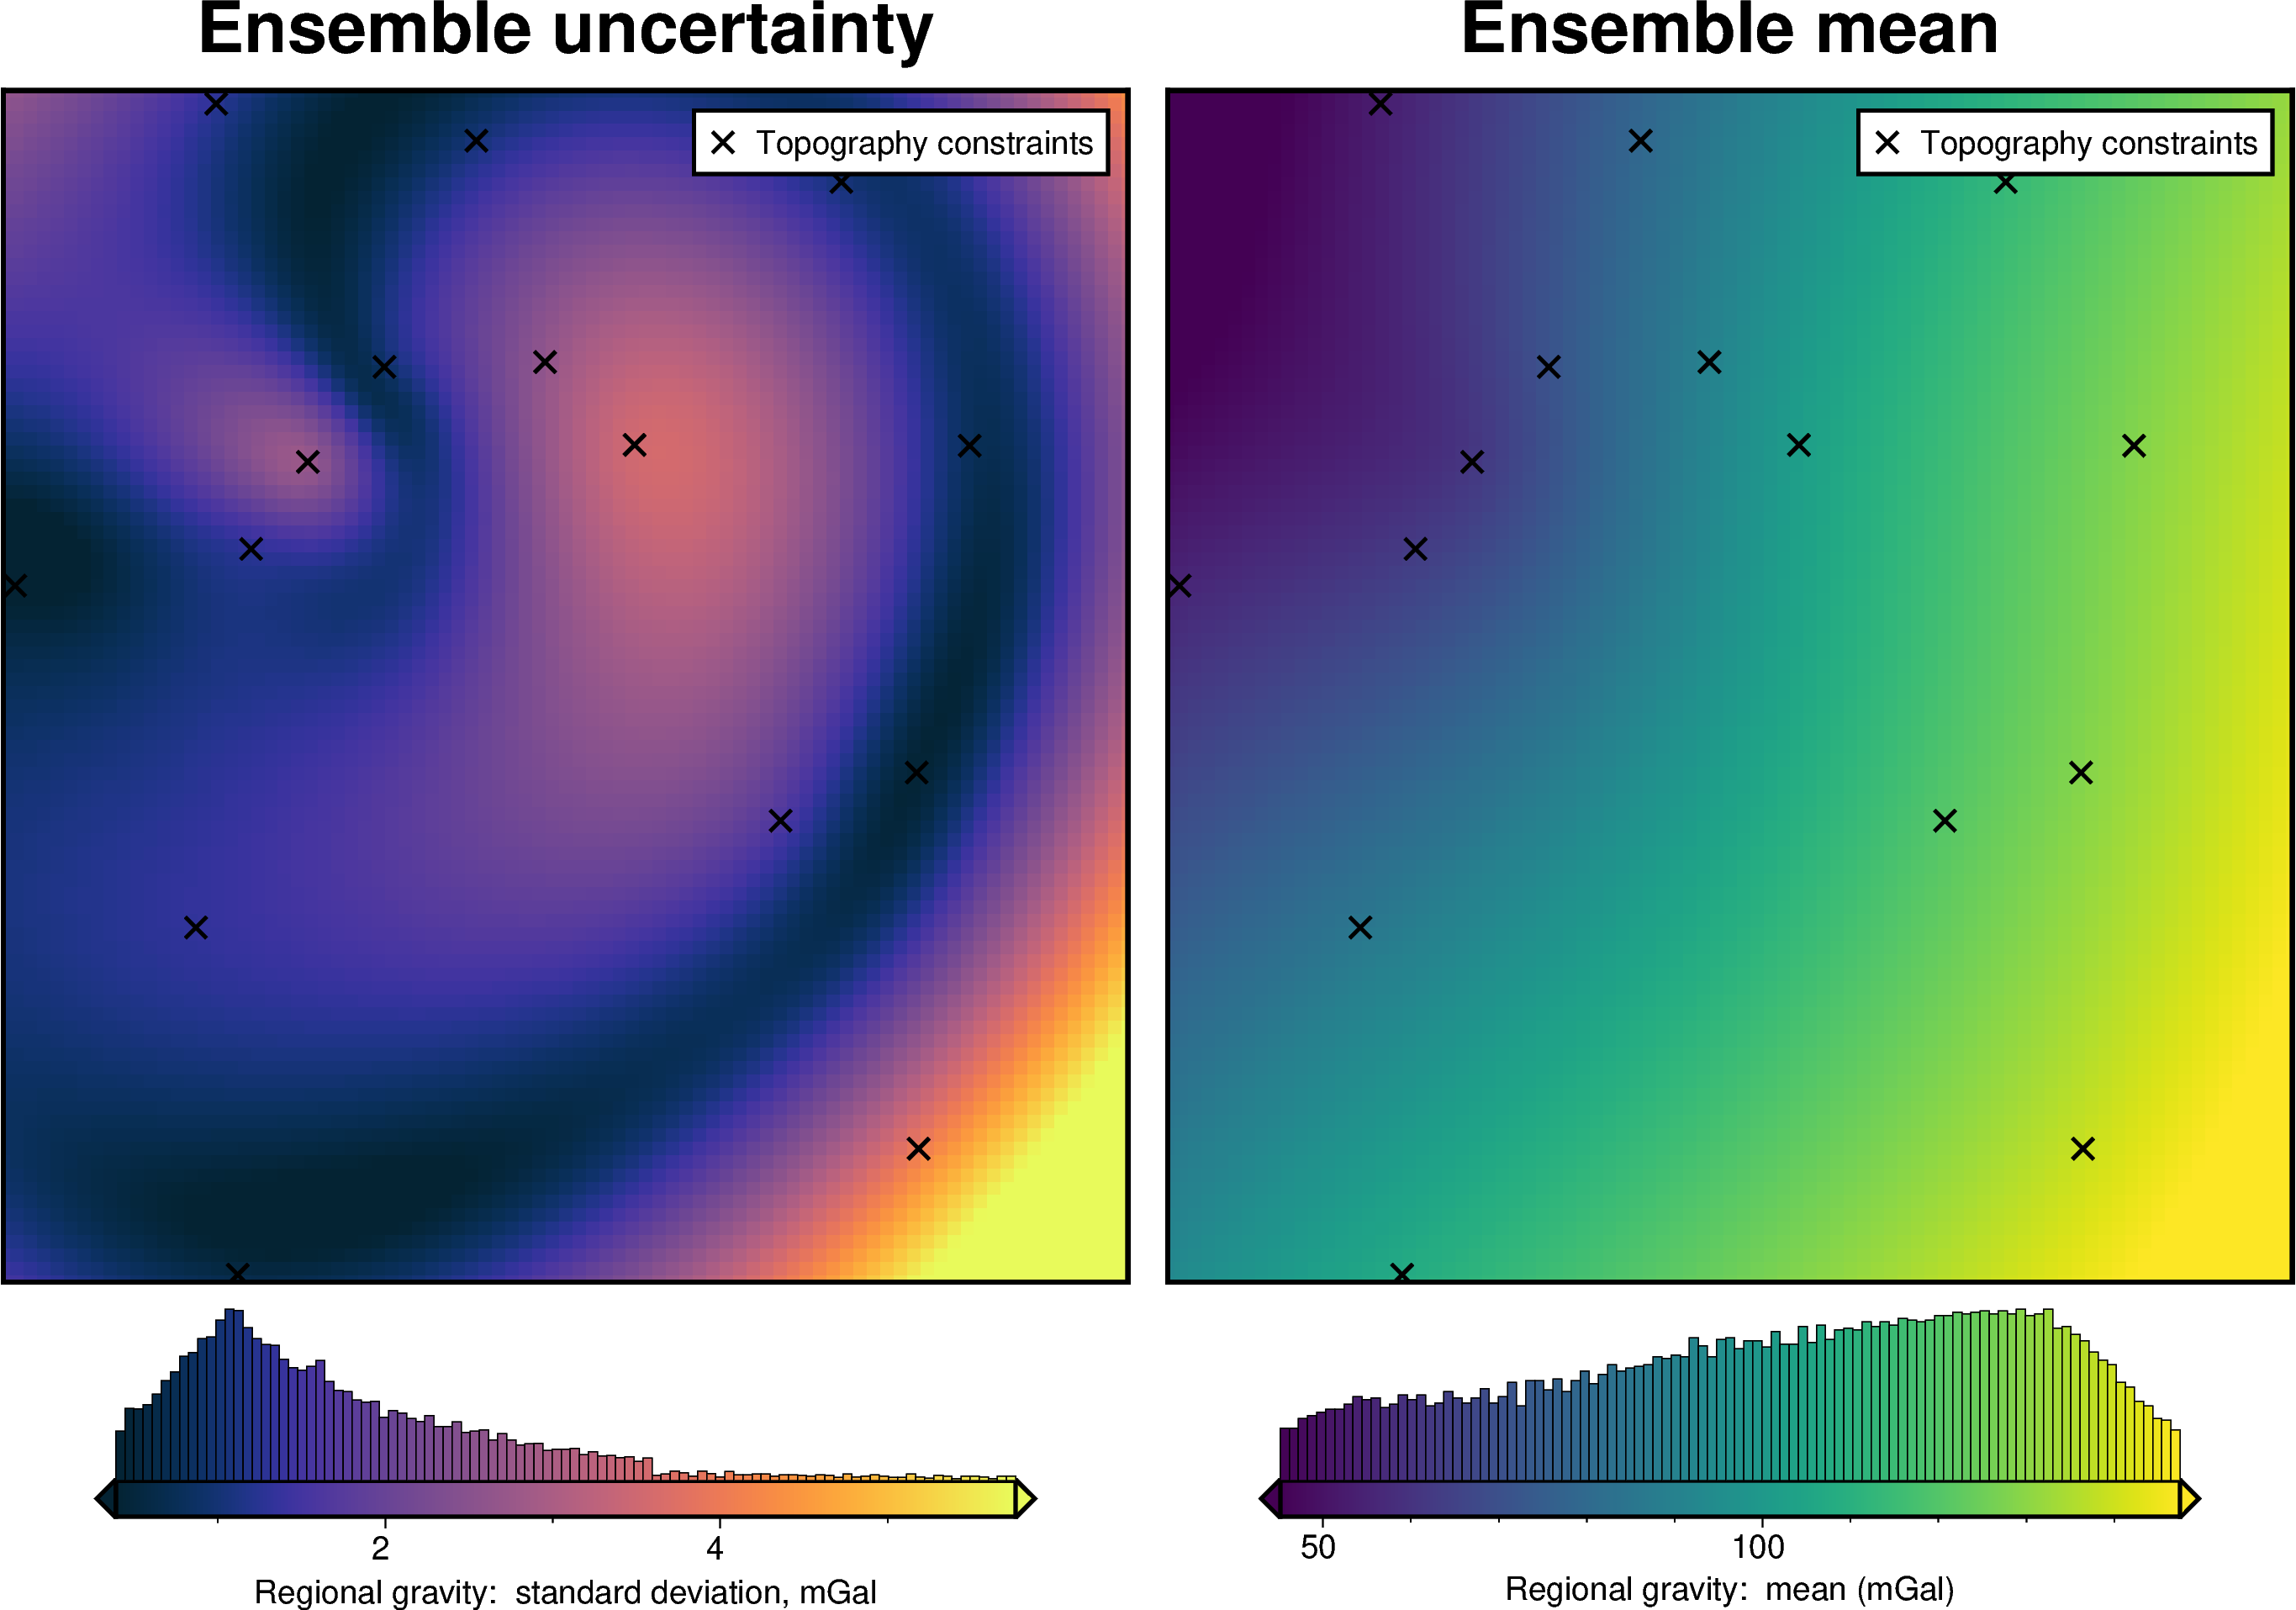

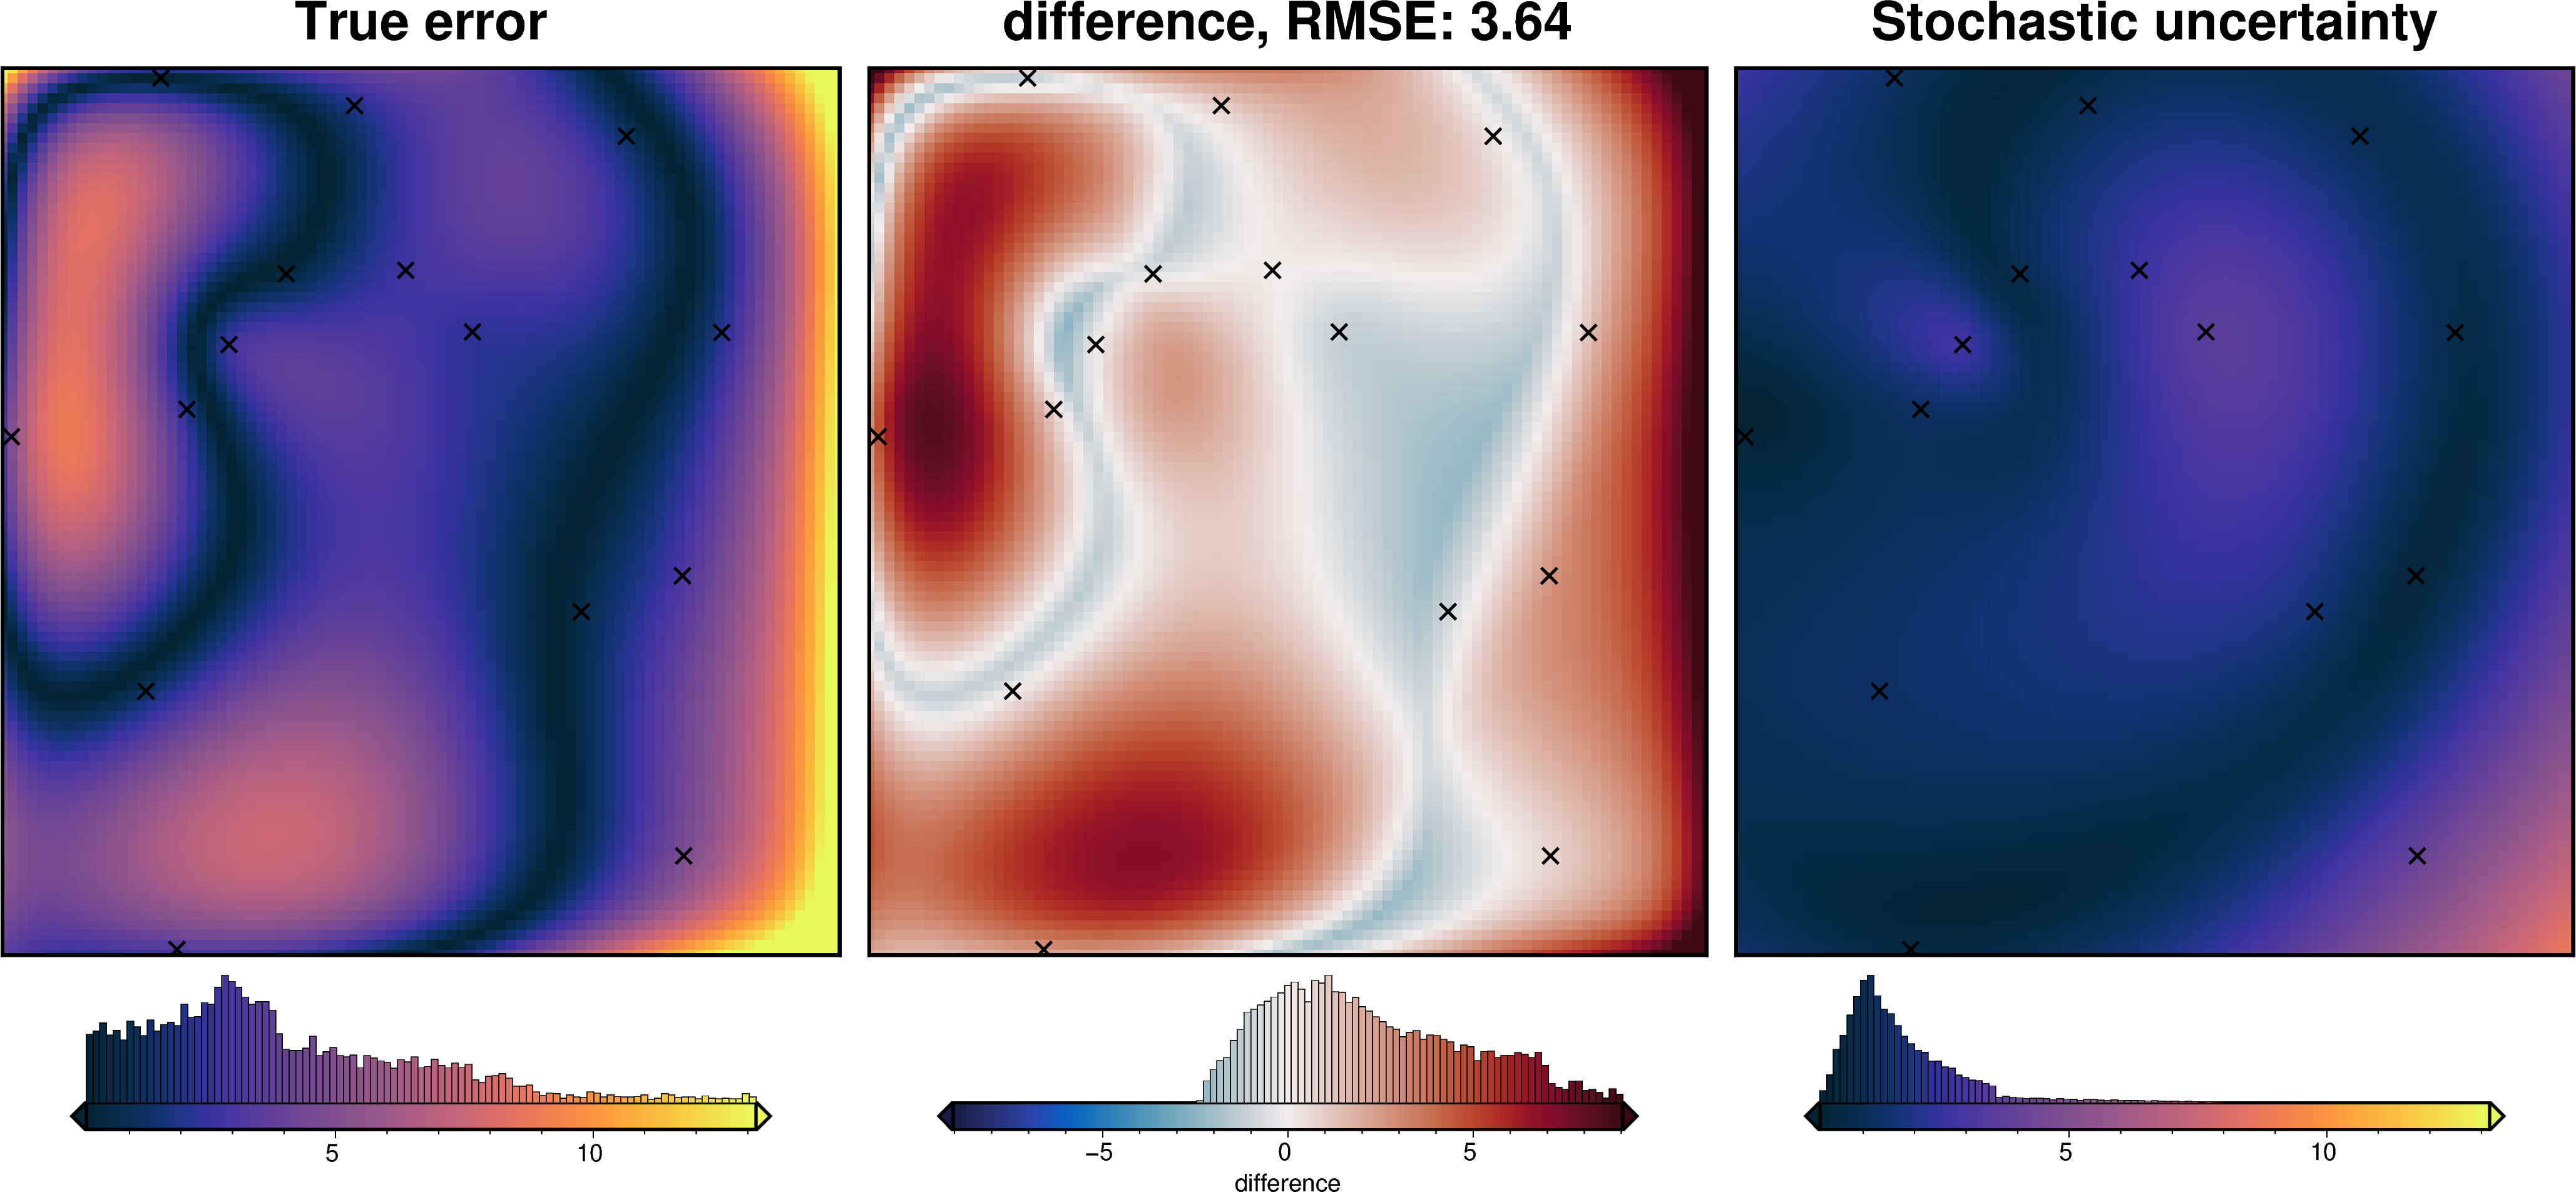

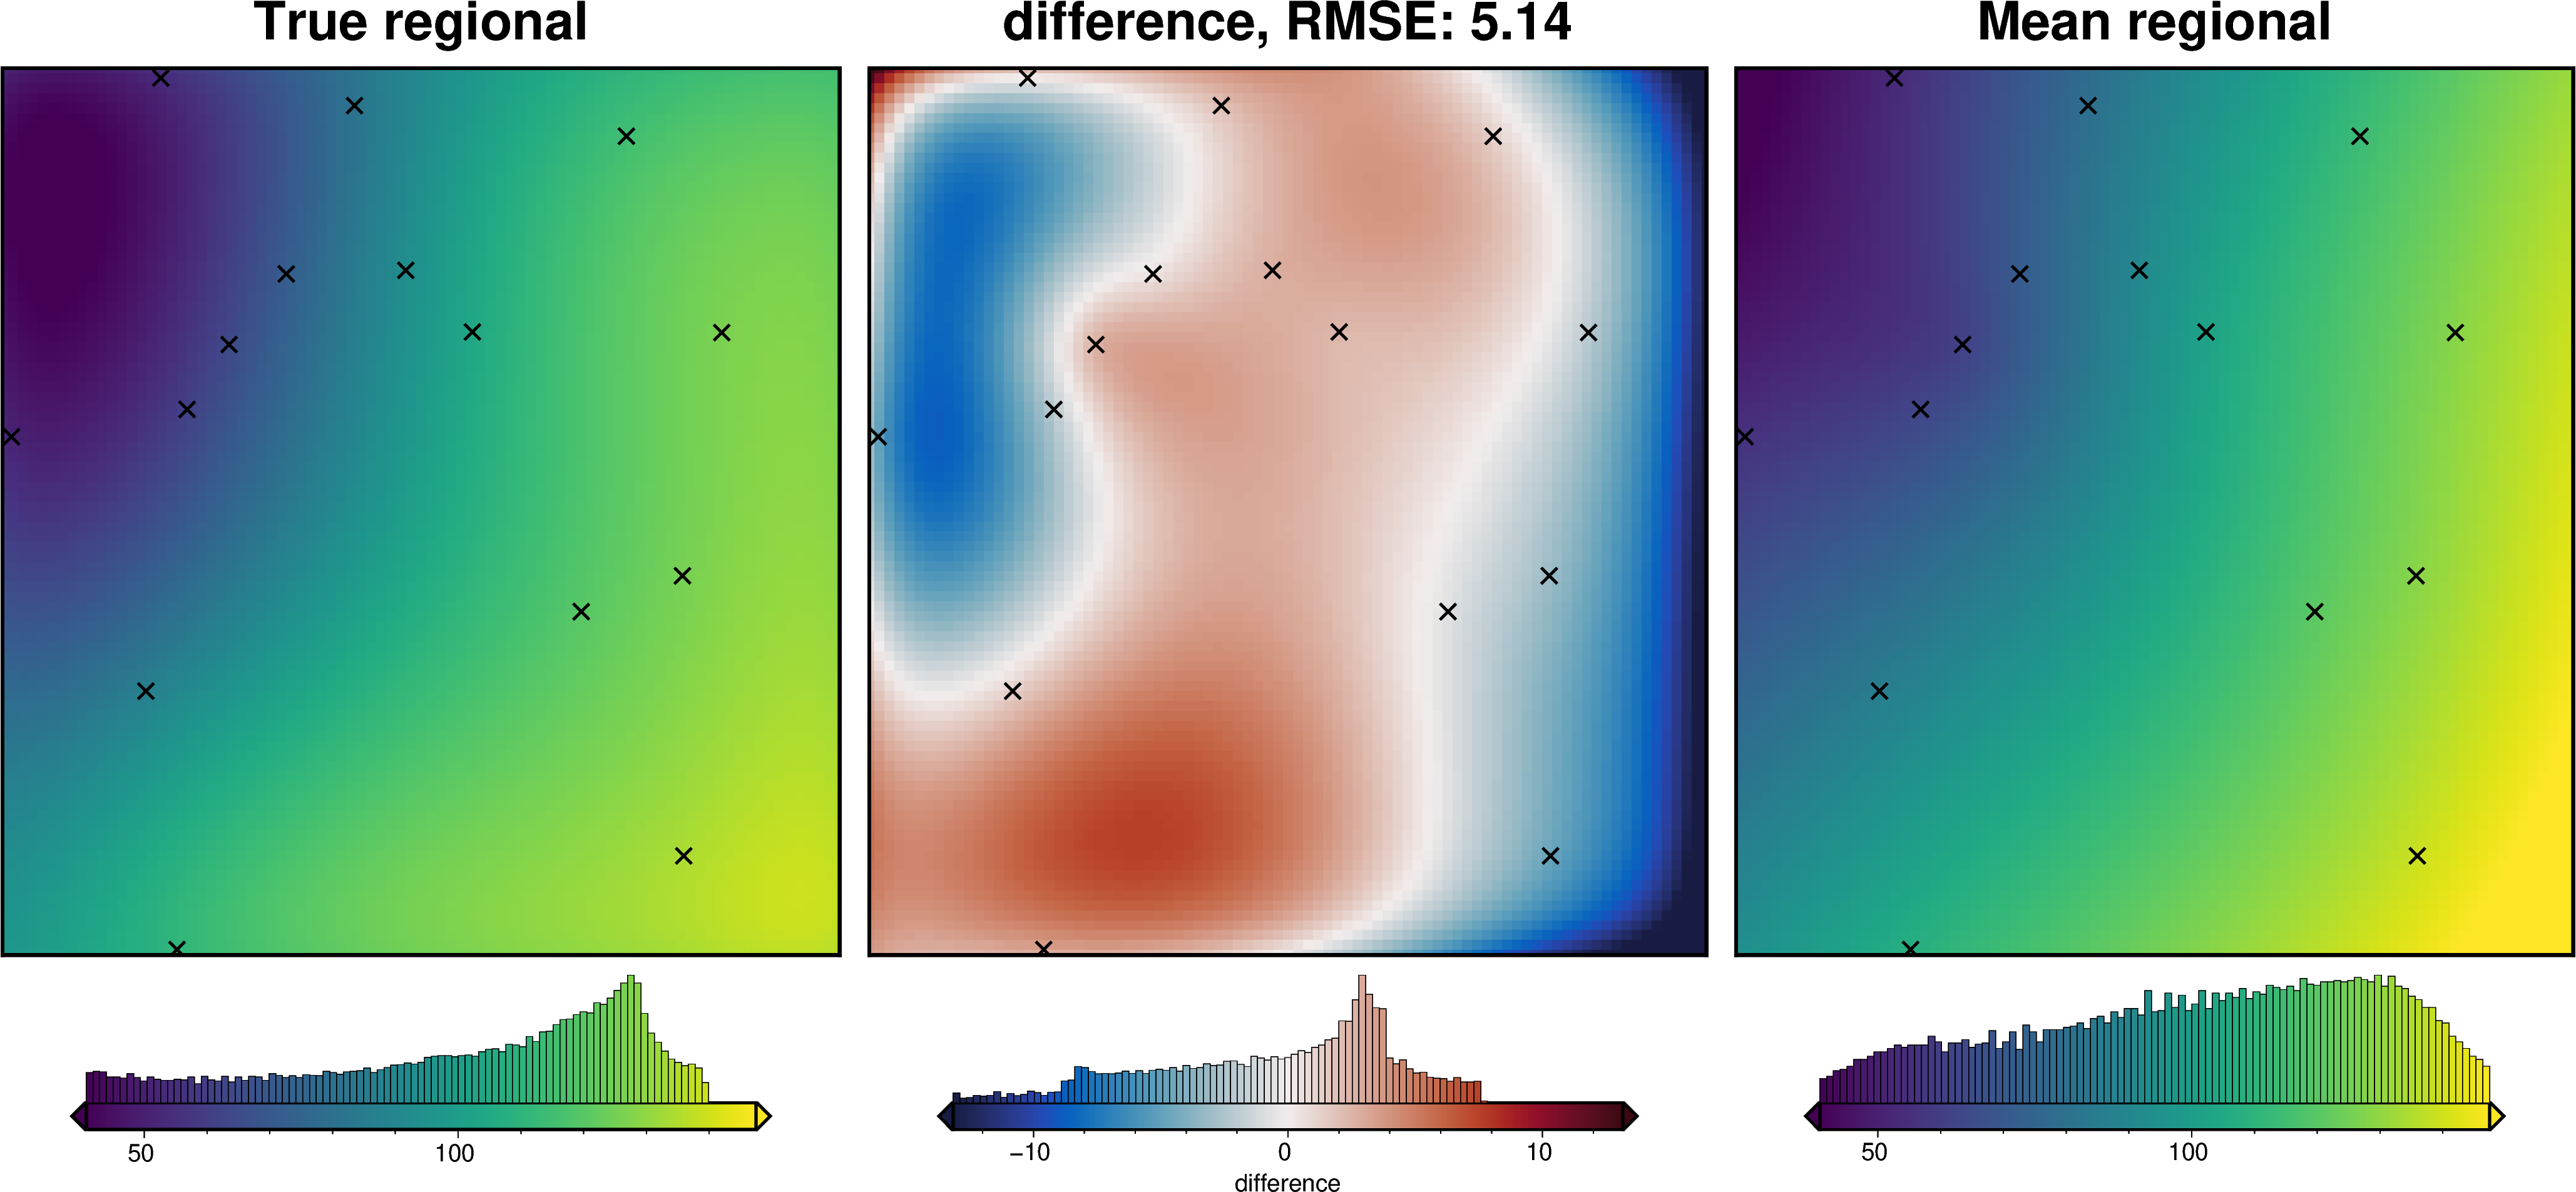

In [27]:
parameter_sampling_dict = {
    "spline_dampings": {
        # "distribution": "uniform",
        # "loc": -15,  # lower bound, 1e-15
        # "scale": 5,  # range, i.e. 1e-15 to 1e-10
        "distribution": "normal",
        "loc": np.log10(best_trial.params["spline_dampings"]),  # mean
        "scale": 2,  # stdev
        "log": True,
    },
}
regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    parameter_dict=parameter_sampling_dict,
    method="constraints",
    grid_method="verde",
    constraints_df=constraint_points,
    **kwargs,
)

##### Equivalent Sources with Harmonica


INFO:invert4geom:optimizing on minimizing the true regional misfit
INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 0
INFO:invert4geom:	parameter: {'damping': 1e-15}
INFO:invert4geom:	scores: [12.684233934110642]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


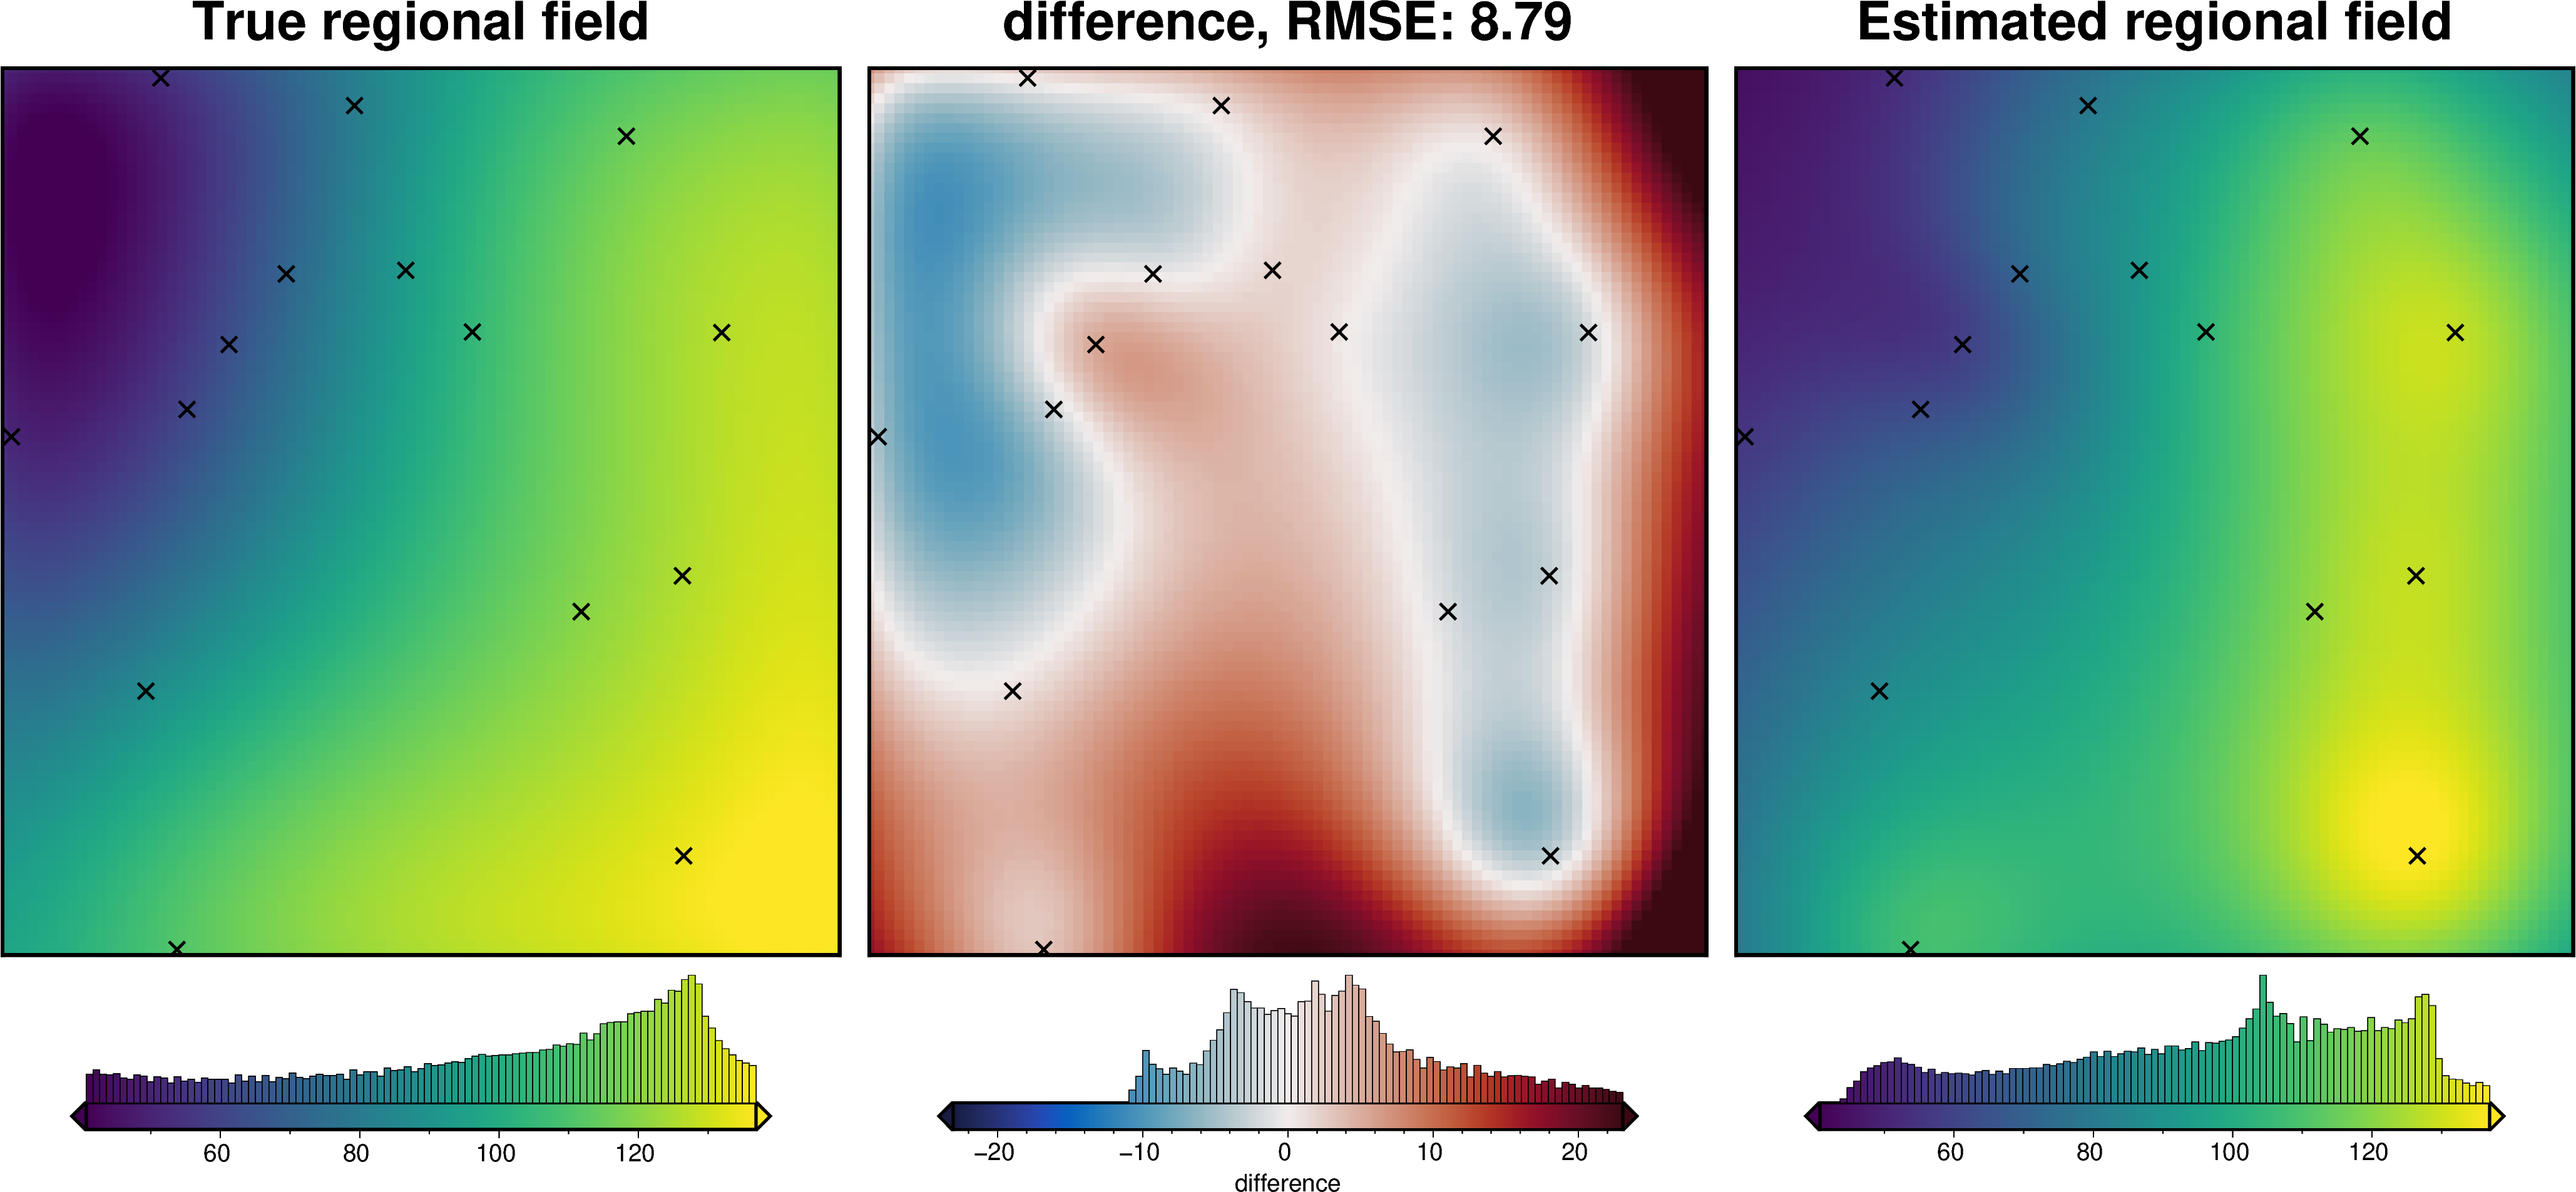

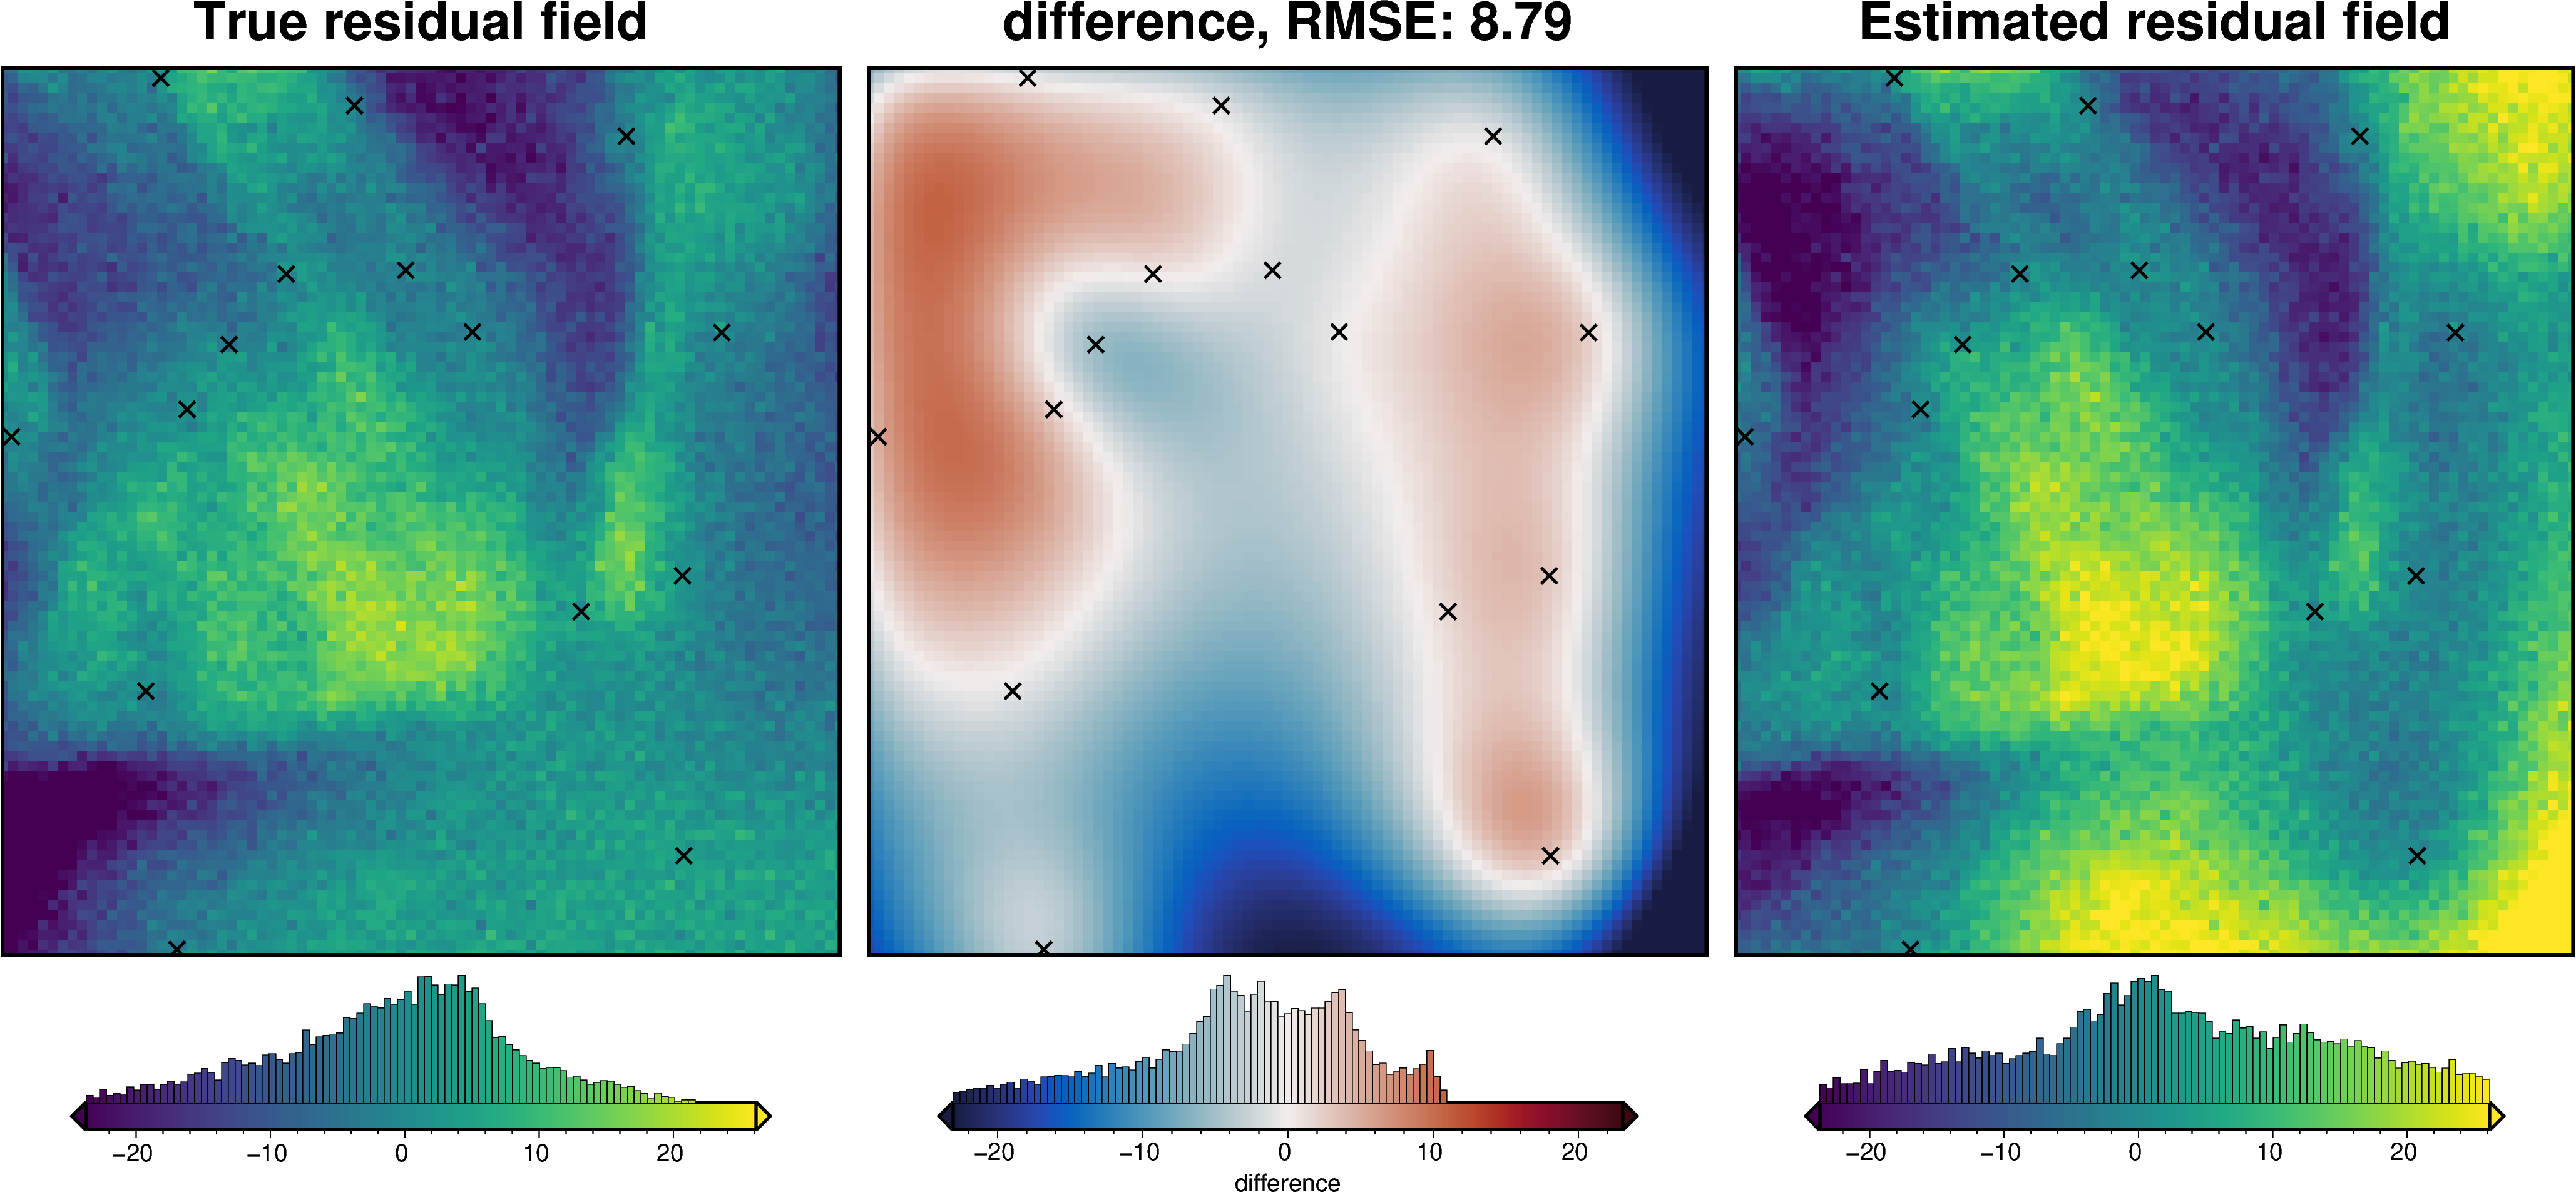

In [28]:
# mean_constraint_distance = np.mean(
#     vd.median_distance(
#         (constraint_points.easting, constraint_points.northing),
#         k_nearest=1,
#         ),
#     )

study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="eq_sources",
        damping_limits=(1e-15, 1),
        # depth_limits=(2.5 * mean_constraint_distance, 6 *mean_constraint_distance),
        # block_size_limits=[spacing, spacing * 20],
        # grav_obs_height_limits=(1, 100e3),
        # if limits are omitted, must provide constant values
        damping=None,
        depth="default",
        block_size=None,
        # grav_obs_height=1e3,
        n_trials=20,
        plot=True,
        fname="tmp/study",
        optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

INFO:invert4geom:Number of folds: 5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Number of trials on the Pareto front: 11
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 16
INFO:invert4geom:	parameter: {'damping': 5.421254169007501e-06}
INFO:invert4geom:	scores: [16.574170132442013, 16.067693655405634]
INFO:invert4geom:re-running regional separation with best parameters and all constraints


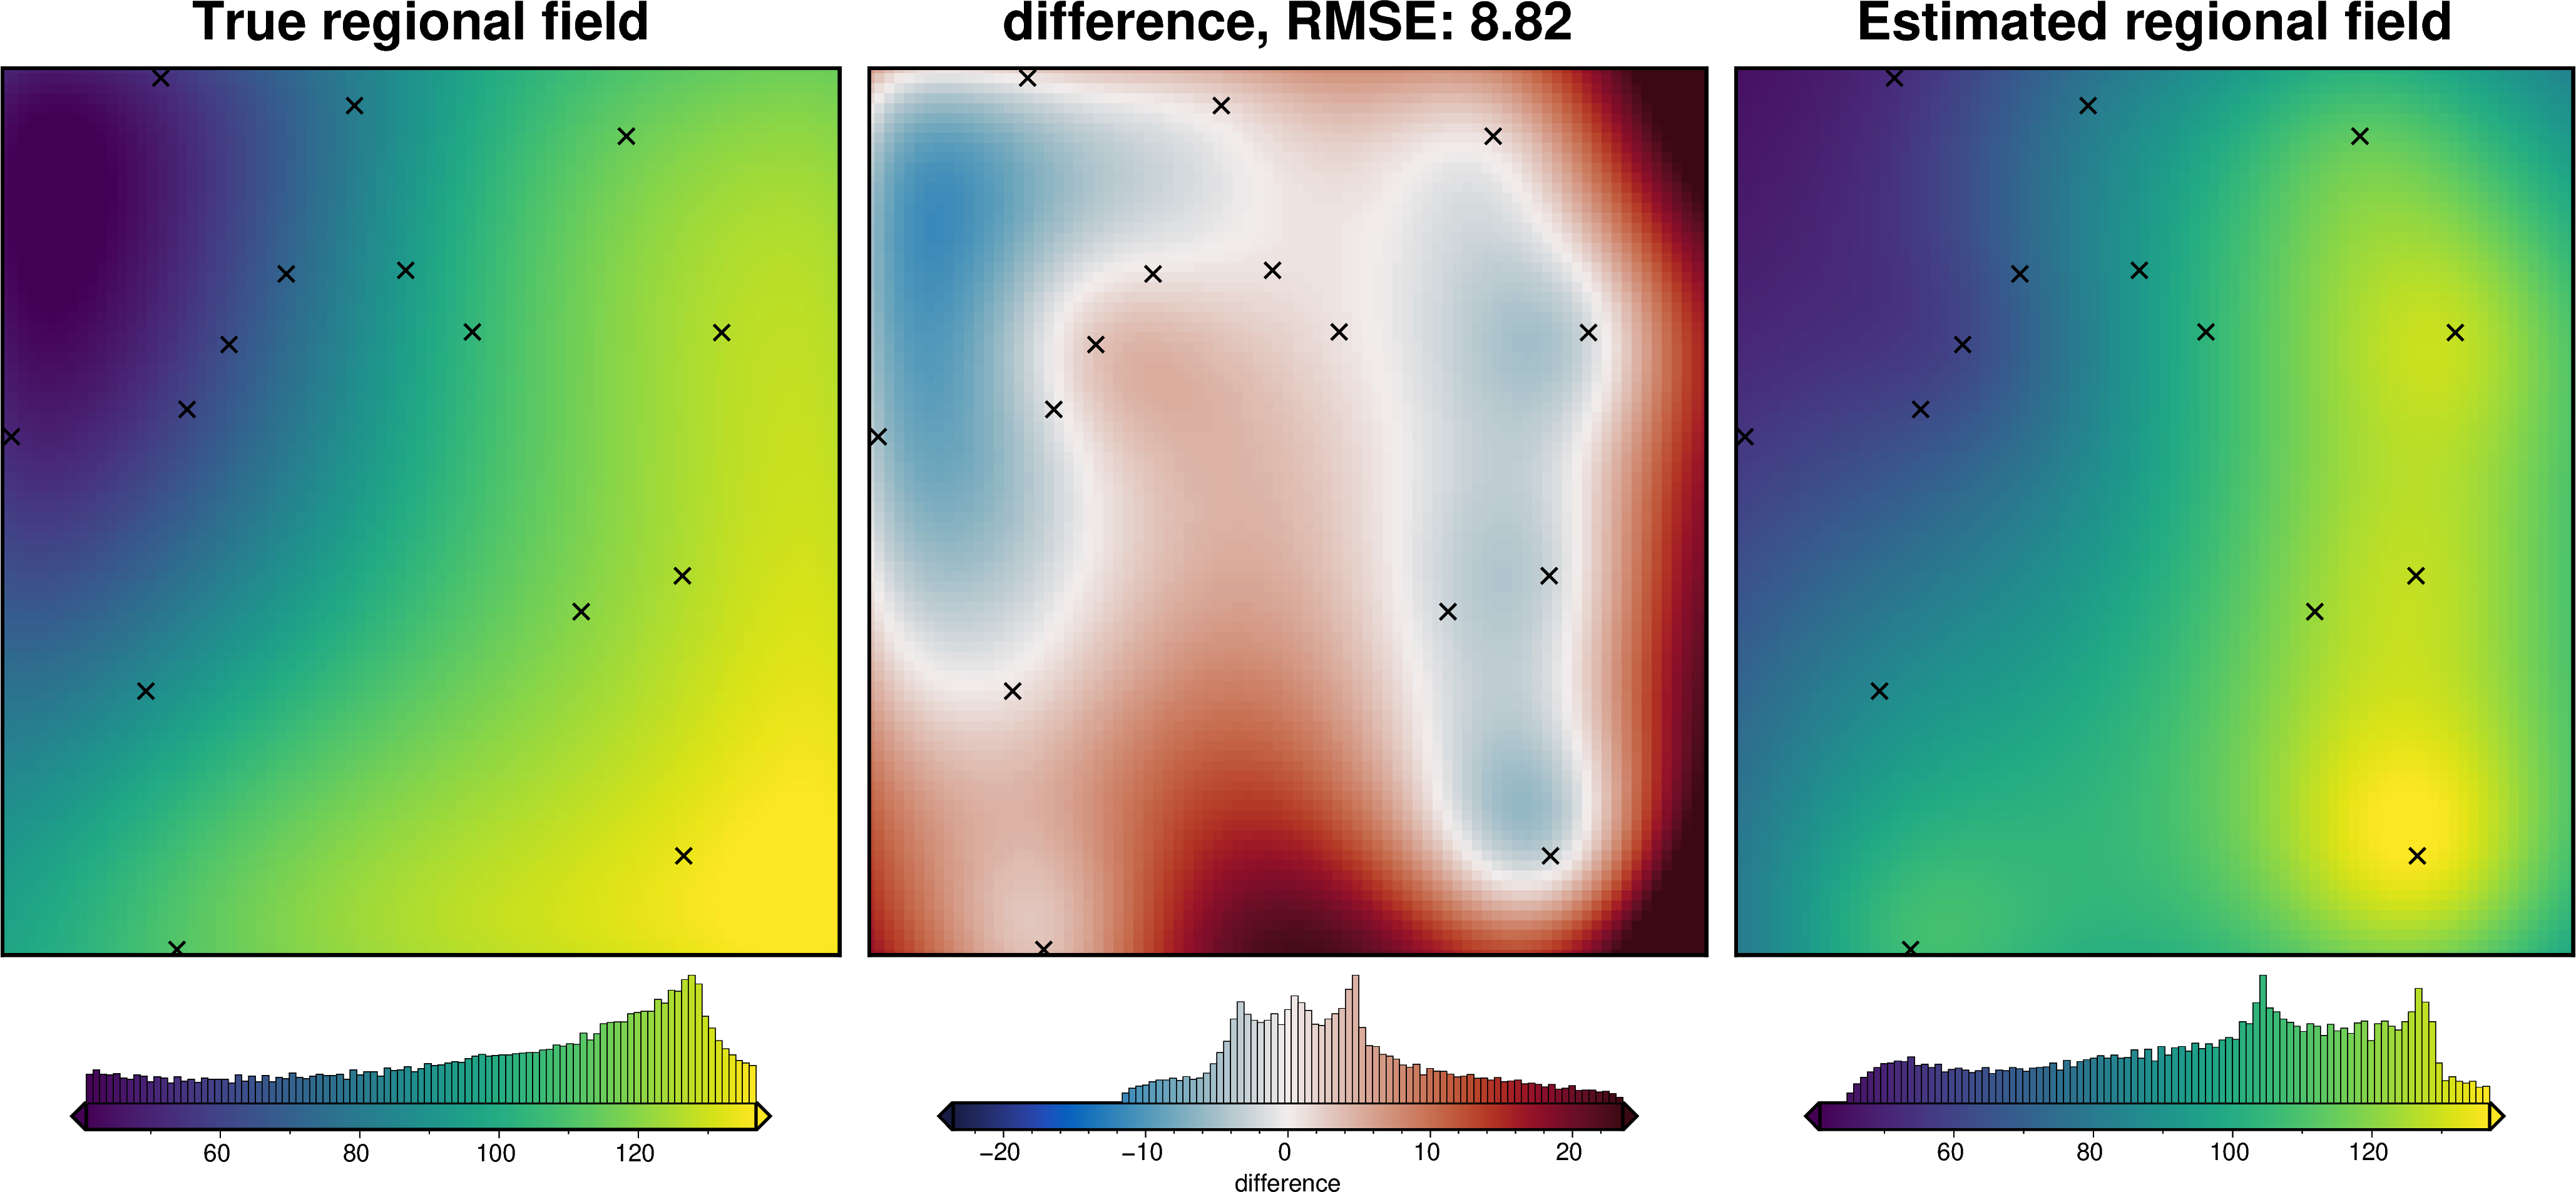

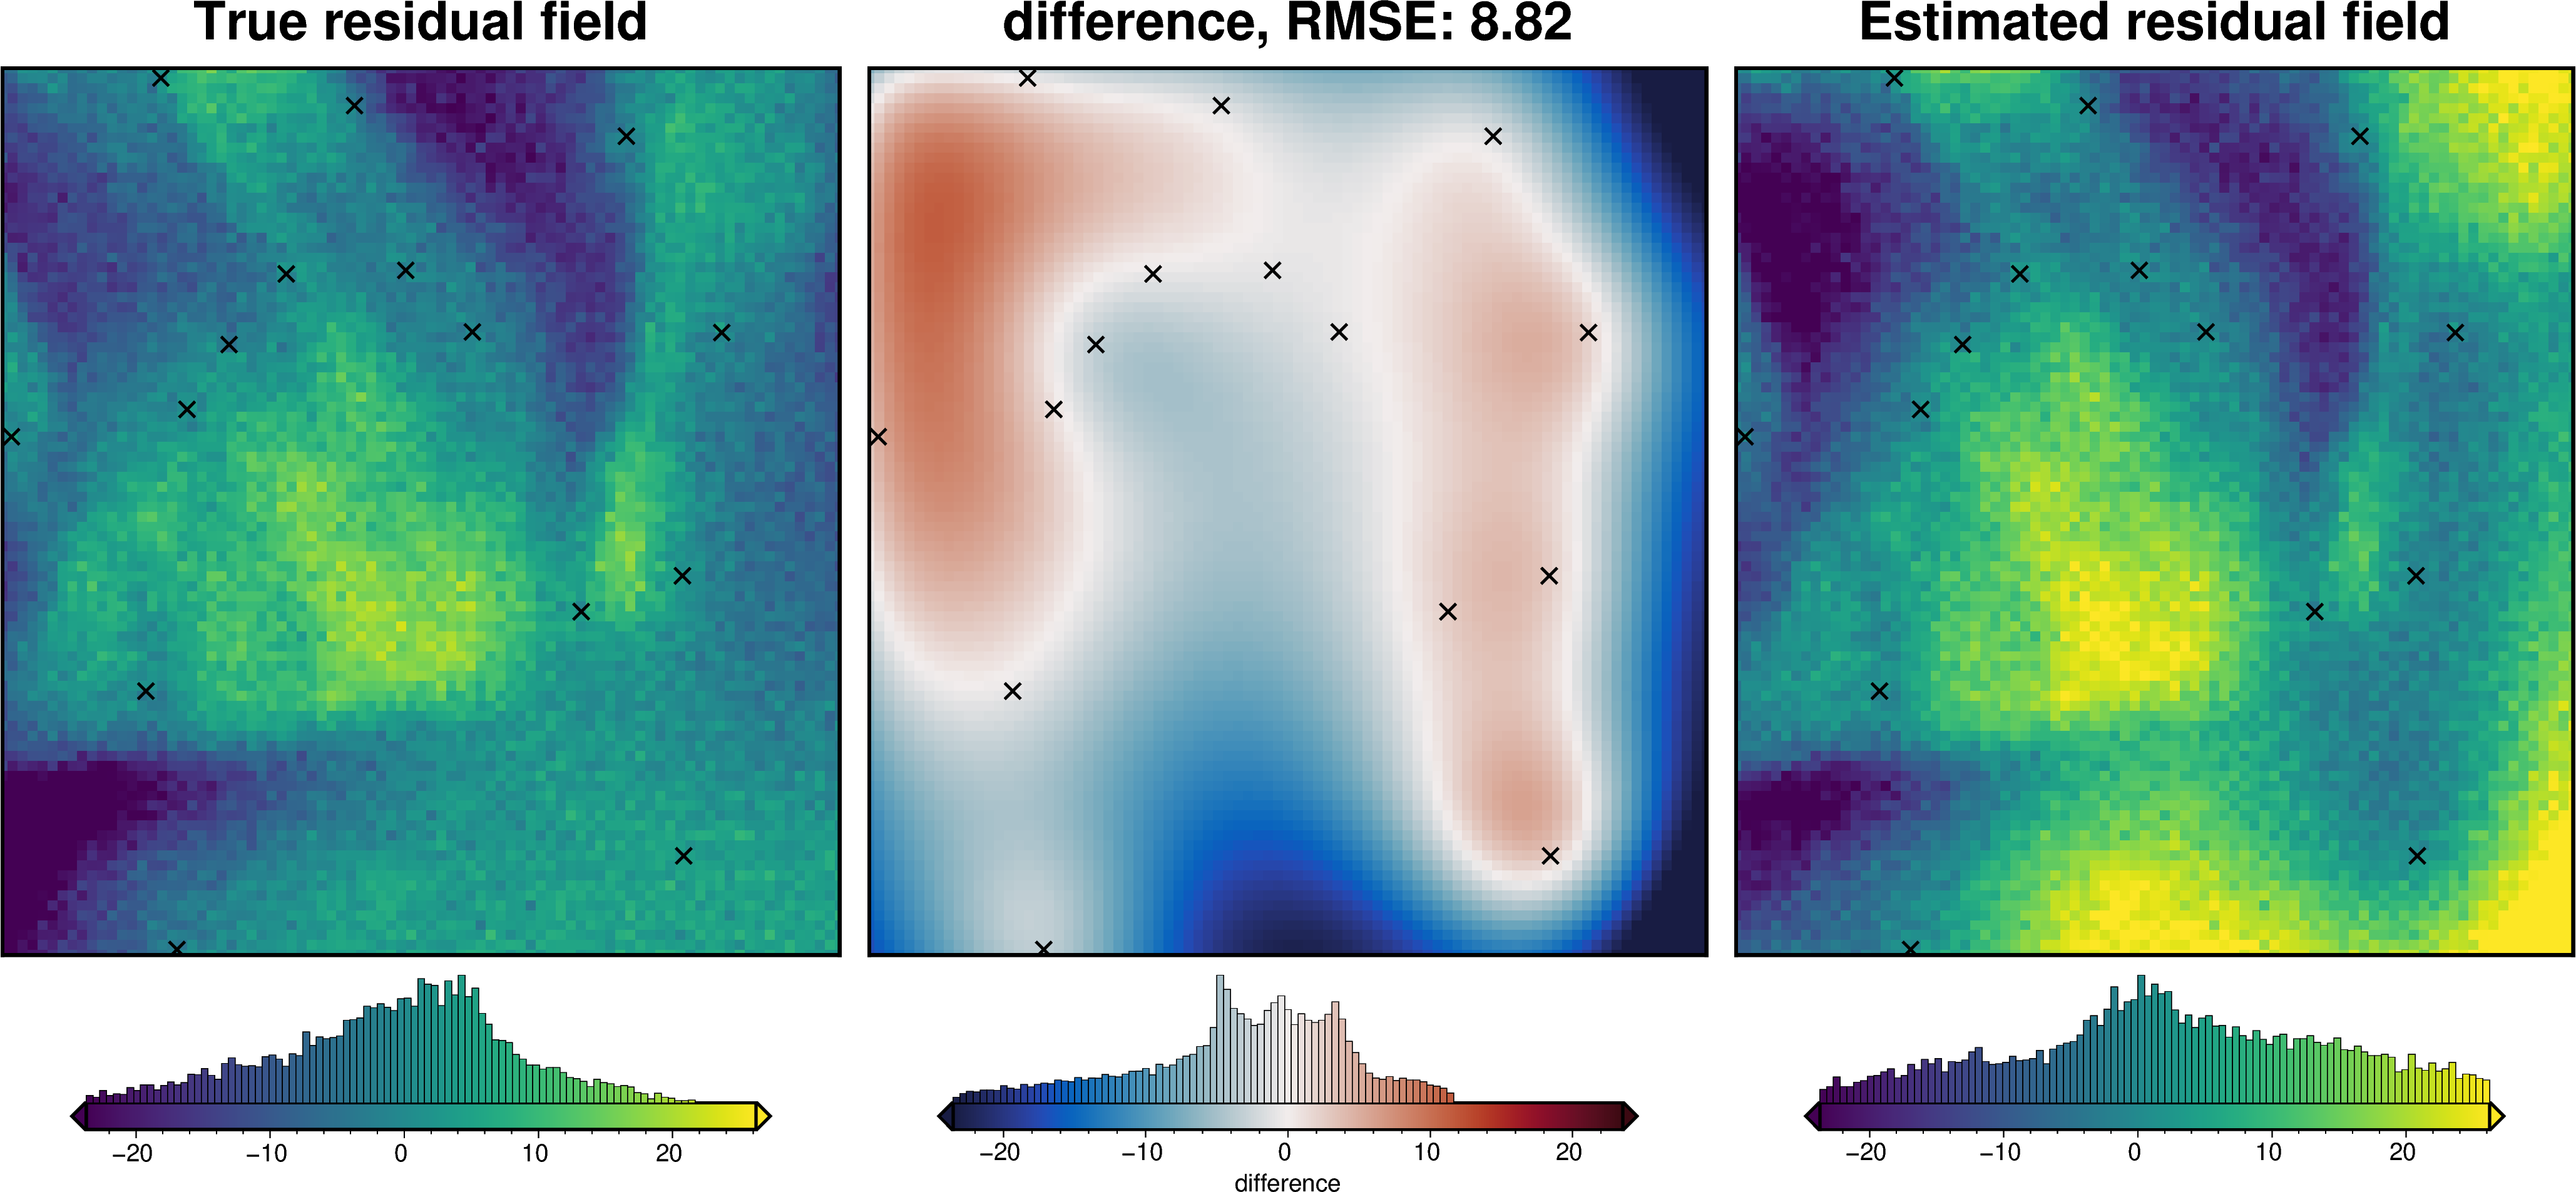

In [29]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        testing_training_df=block_kfold_split_df,
        grid_method="eq_sources",
        damping_limits=(1e-15, 1),
        # depth_limits=(2.5 * mean_constraint_distance, 6 *mean_constraint_distance),
        # block_size_limits=[spacing, spacing * 20],
        # grav_obs_height_limits=(1, 100e3),
        # if limits are omitted, must provide constant values
        damping=None,
        depth="default",
        block_size=None,
        # grav_obs_height=1e3,
        n_trials=20,
        plot=True,
        fname="tmp/study",
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

Alternatively, we can use an internal CV which finds the parameters which create the best fit to the sampled residual values at the constraits. This is faster and simplier, as the only step that is repeated for the CV is the fitting of equivalent sources to the data, and not the entire process of sample the misfit and remove the regional from this misfit to get the residual. However, this is less informed than the above K-fold CV as it isn't attempting to retain a high amplitude residual field, just trying to fit the data as best as possible.

In [30]:
grav_df = regional.regional_separation(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    cv=True,
    cv_kwargs=dict(
        n_trials=40, damping_limits=(1e-15, 1), plot=True, fname="tmp/regional_sep"
    ),
    grav_obs_height=1e3,
    depth="default",
    block_size=None,
    **kwargs2,
)

  0%|          | 0/40 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 14
INFO:invert4geom:	parameter: {'damping': 5.108584569544416e-06}
INFO:invert4geom:	scores: [0.12175368740175782]


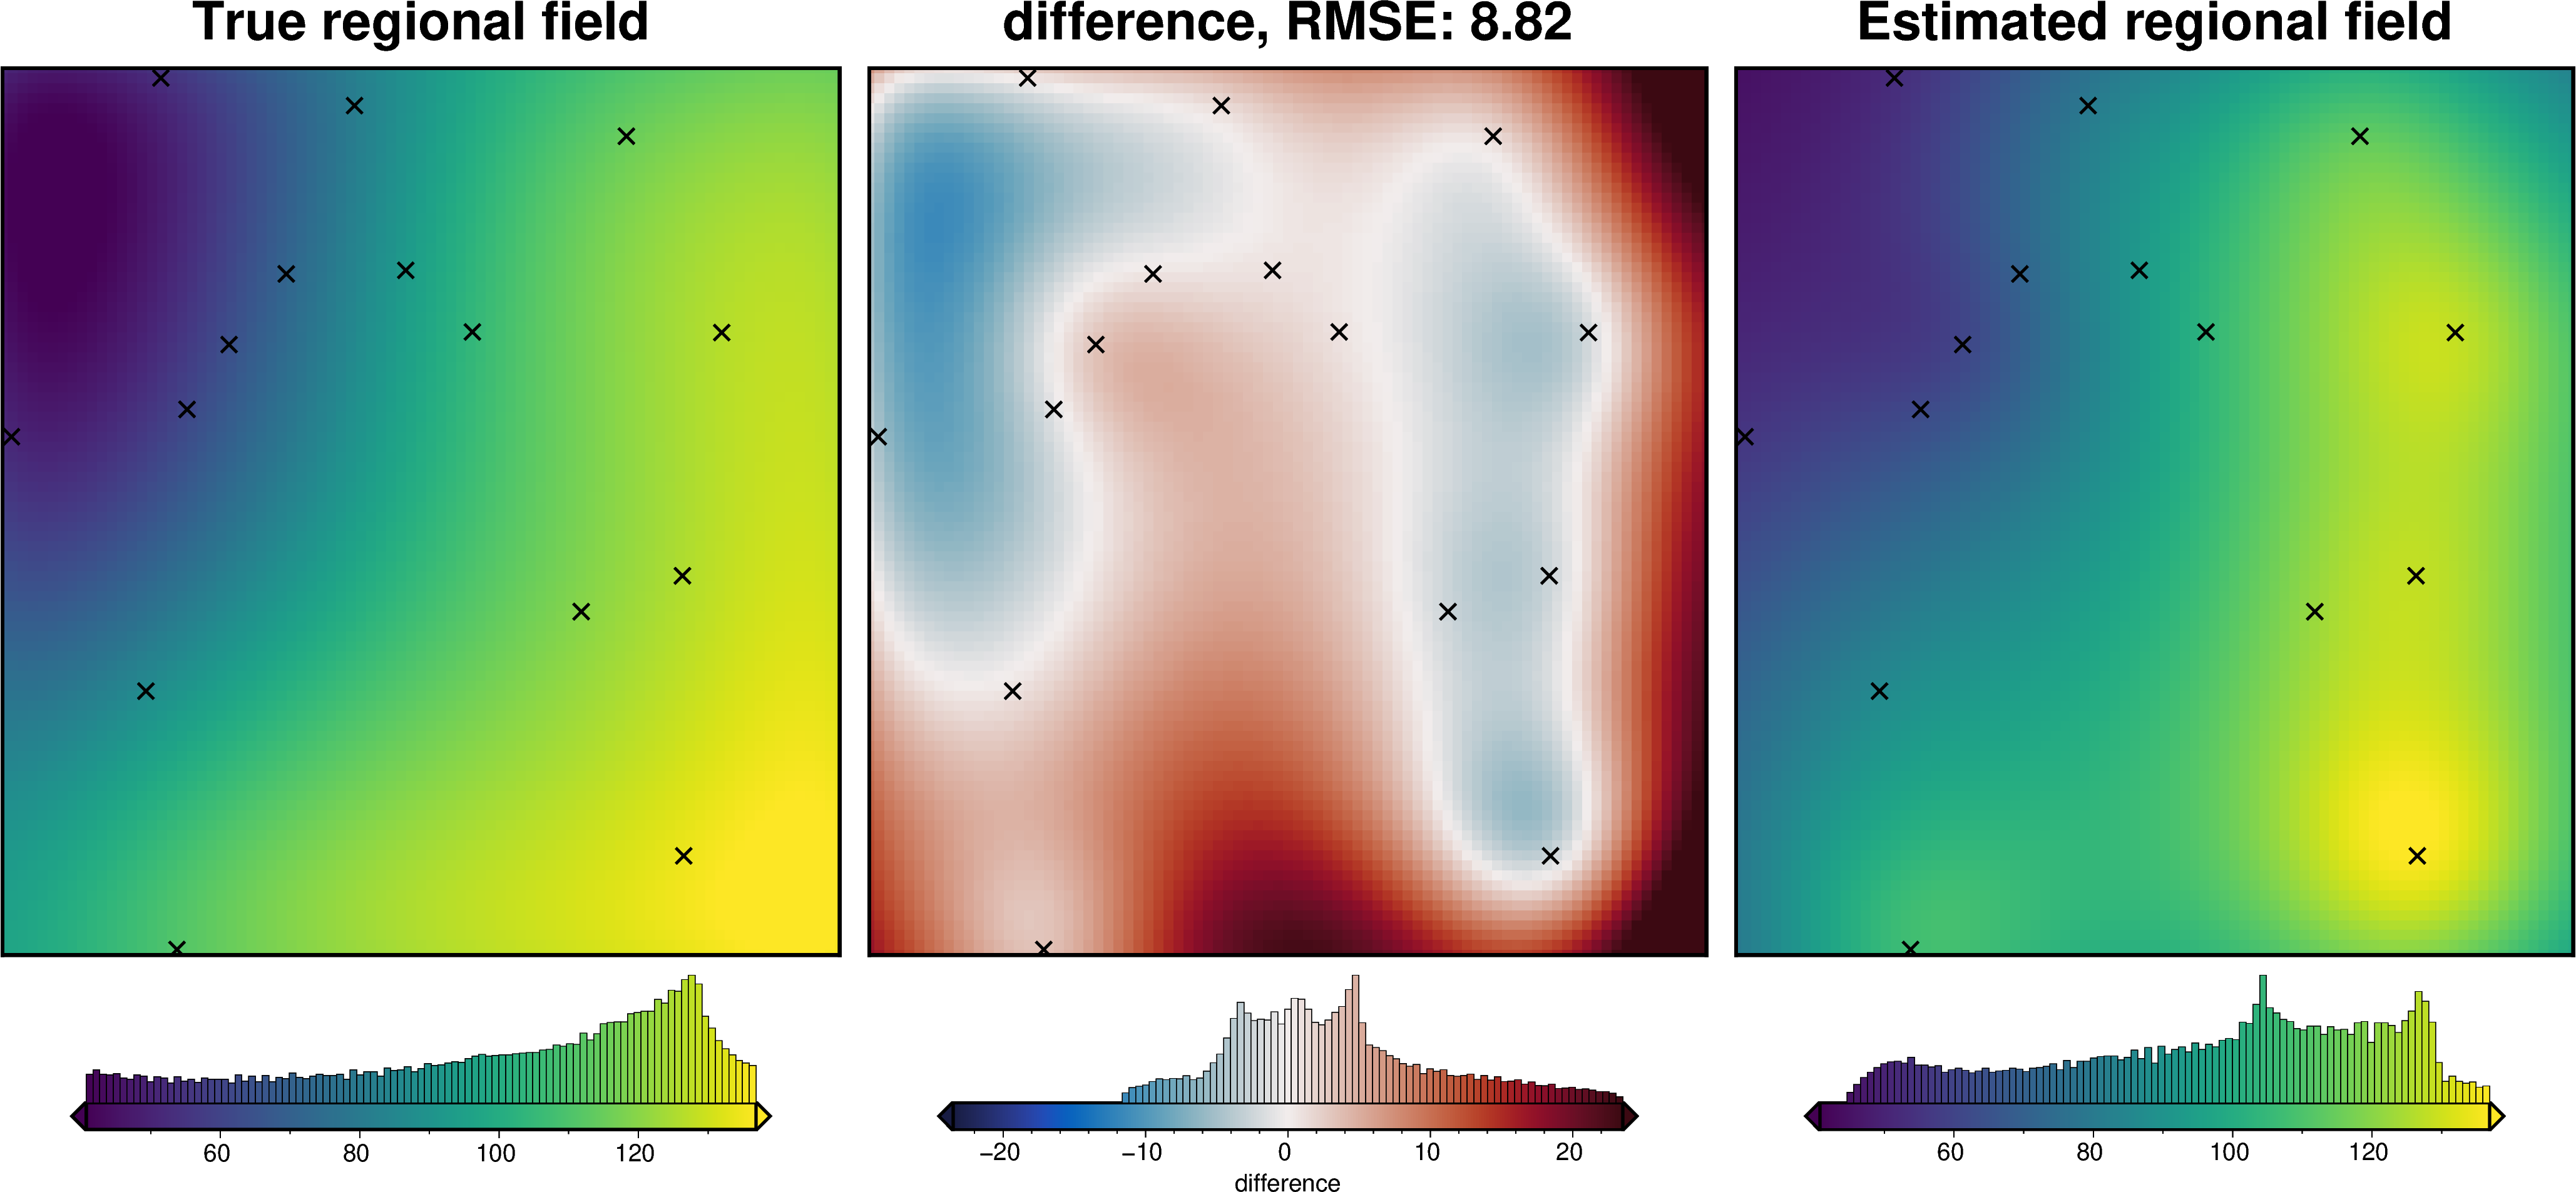

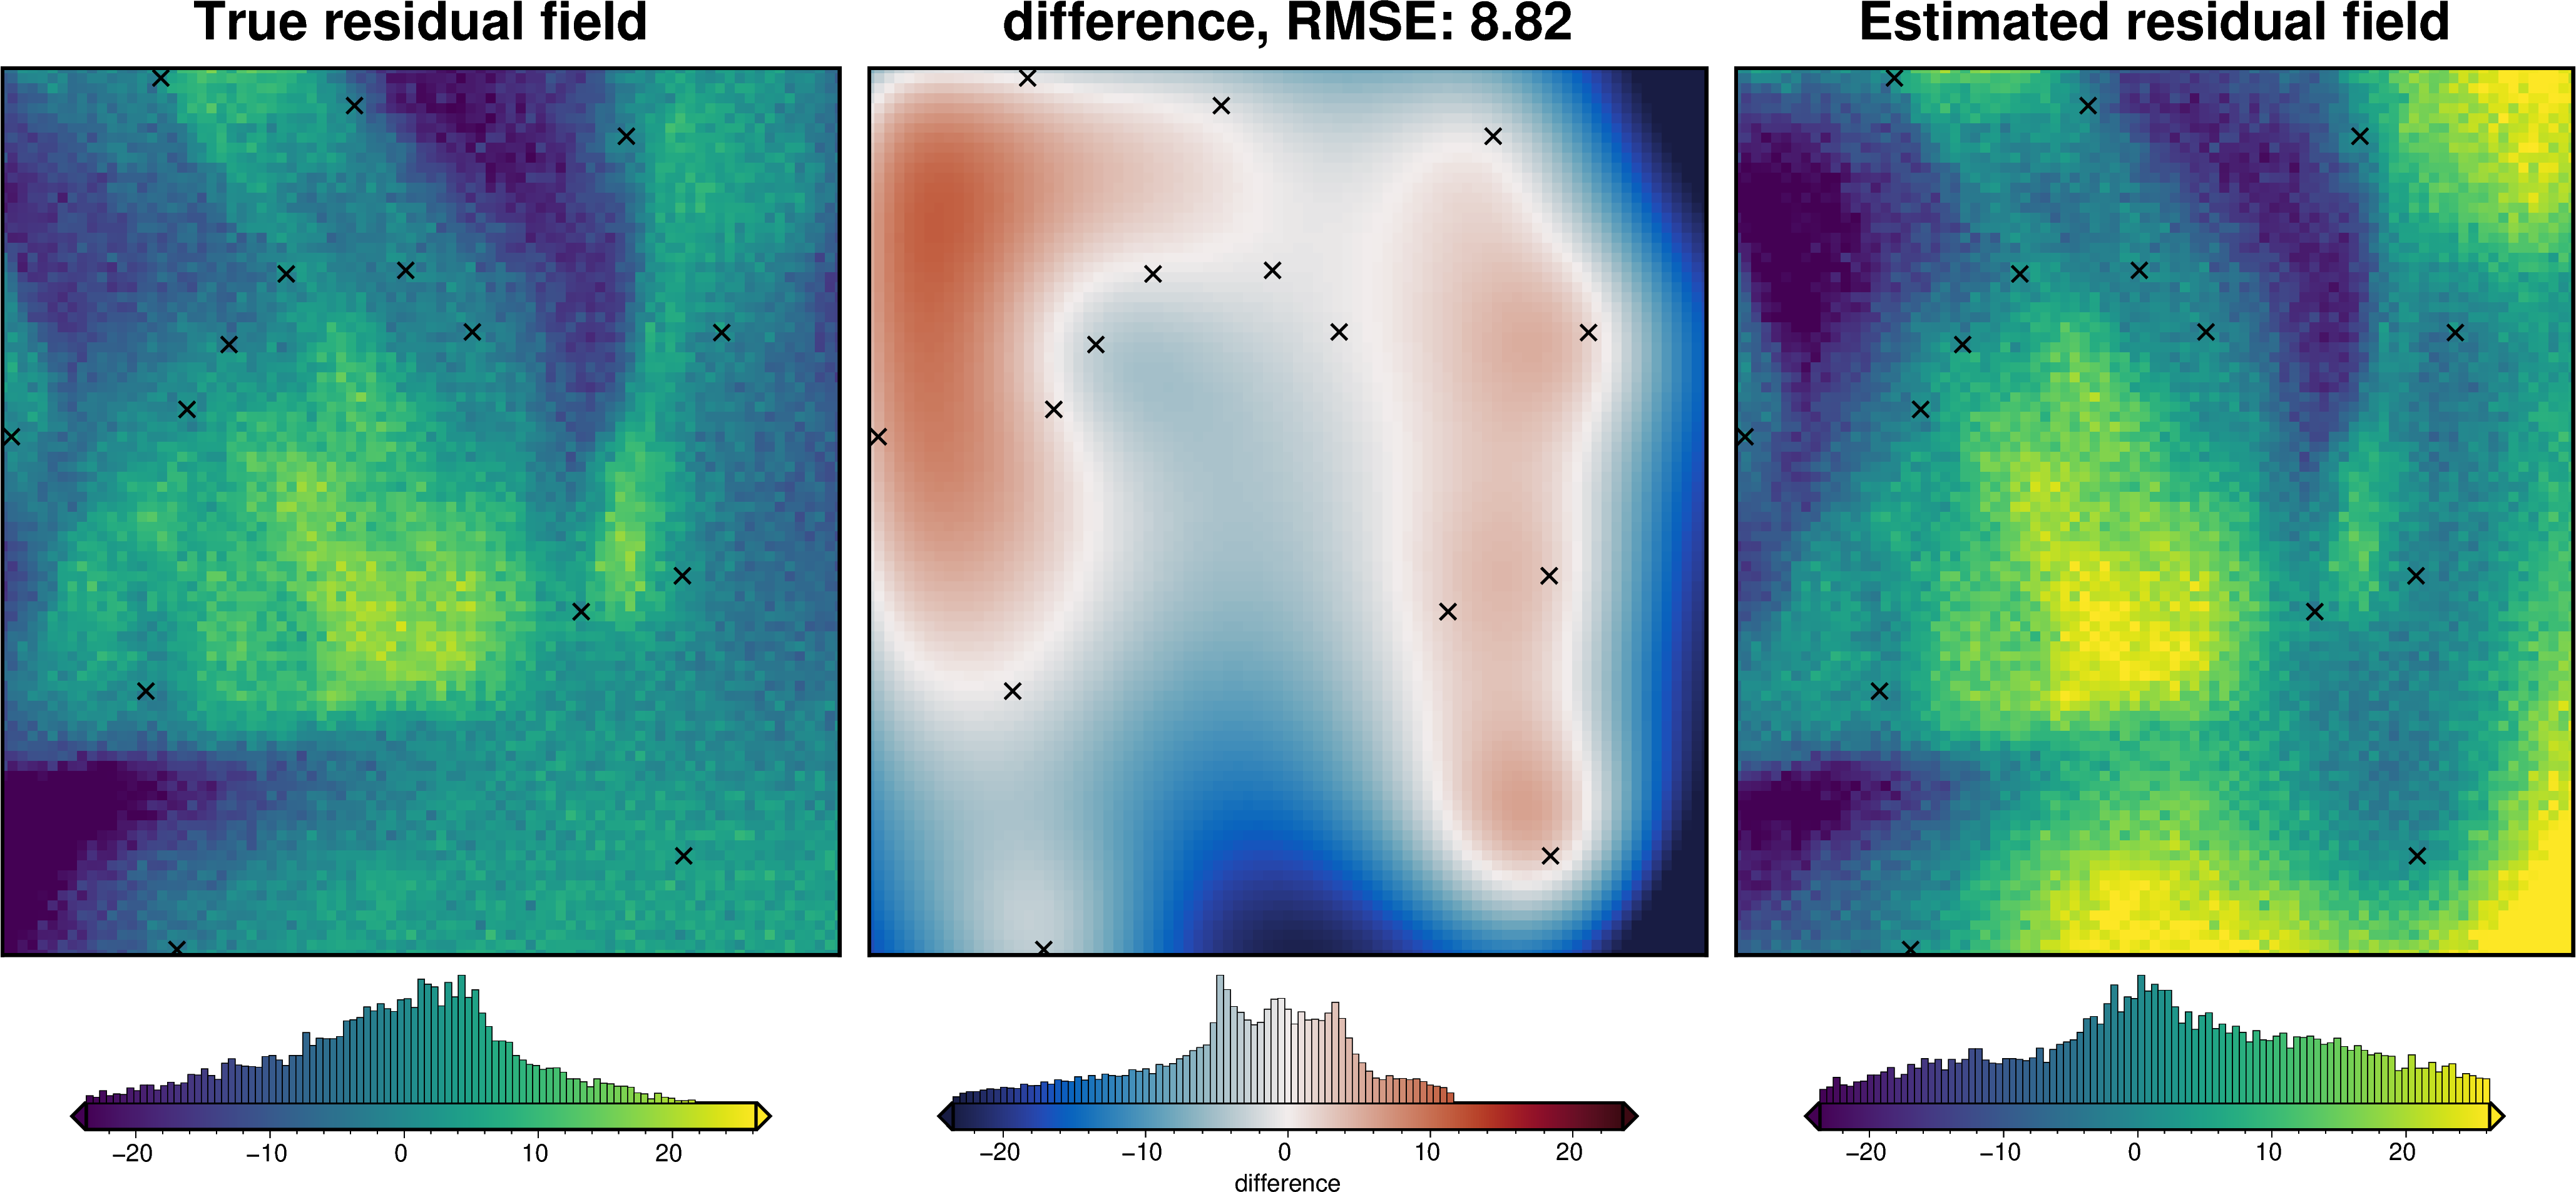

In [31]:
regional_comparison(grav_df)

In [32]:
# re-load the study from the saved pickle file
with pathlib.Path("tmp/regional_sep.pickle").open("rb") as f:
    study = pickle.load(f)
eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
eq_damping

5.108584569544416e-06

In [33]:
np.log10(eq_damping)

np.float64(-5.291699412739566)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 274036.2380902418, min: 164018.74838636527, max: 384053.7277941182
INFO:invert4geom:Sampled 'grav_obs_height' parameter values; mean: 5000.0, min: 125.0, max: 9875.0
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.0046521479046210245, min: 1.6807190866450157e-10, max: 0.15527661053866257


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

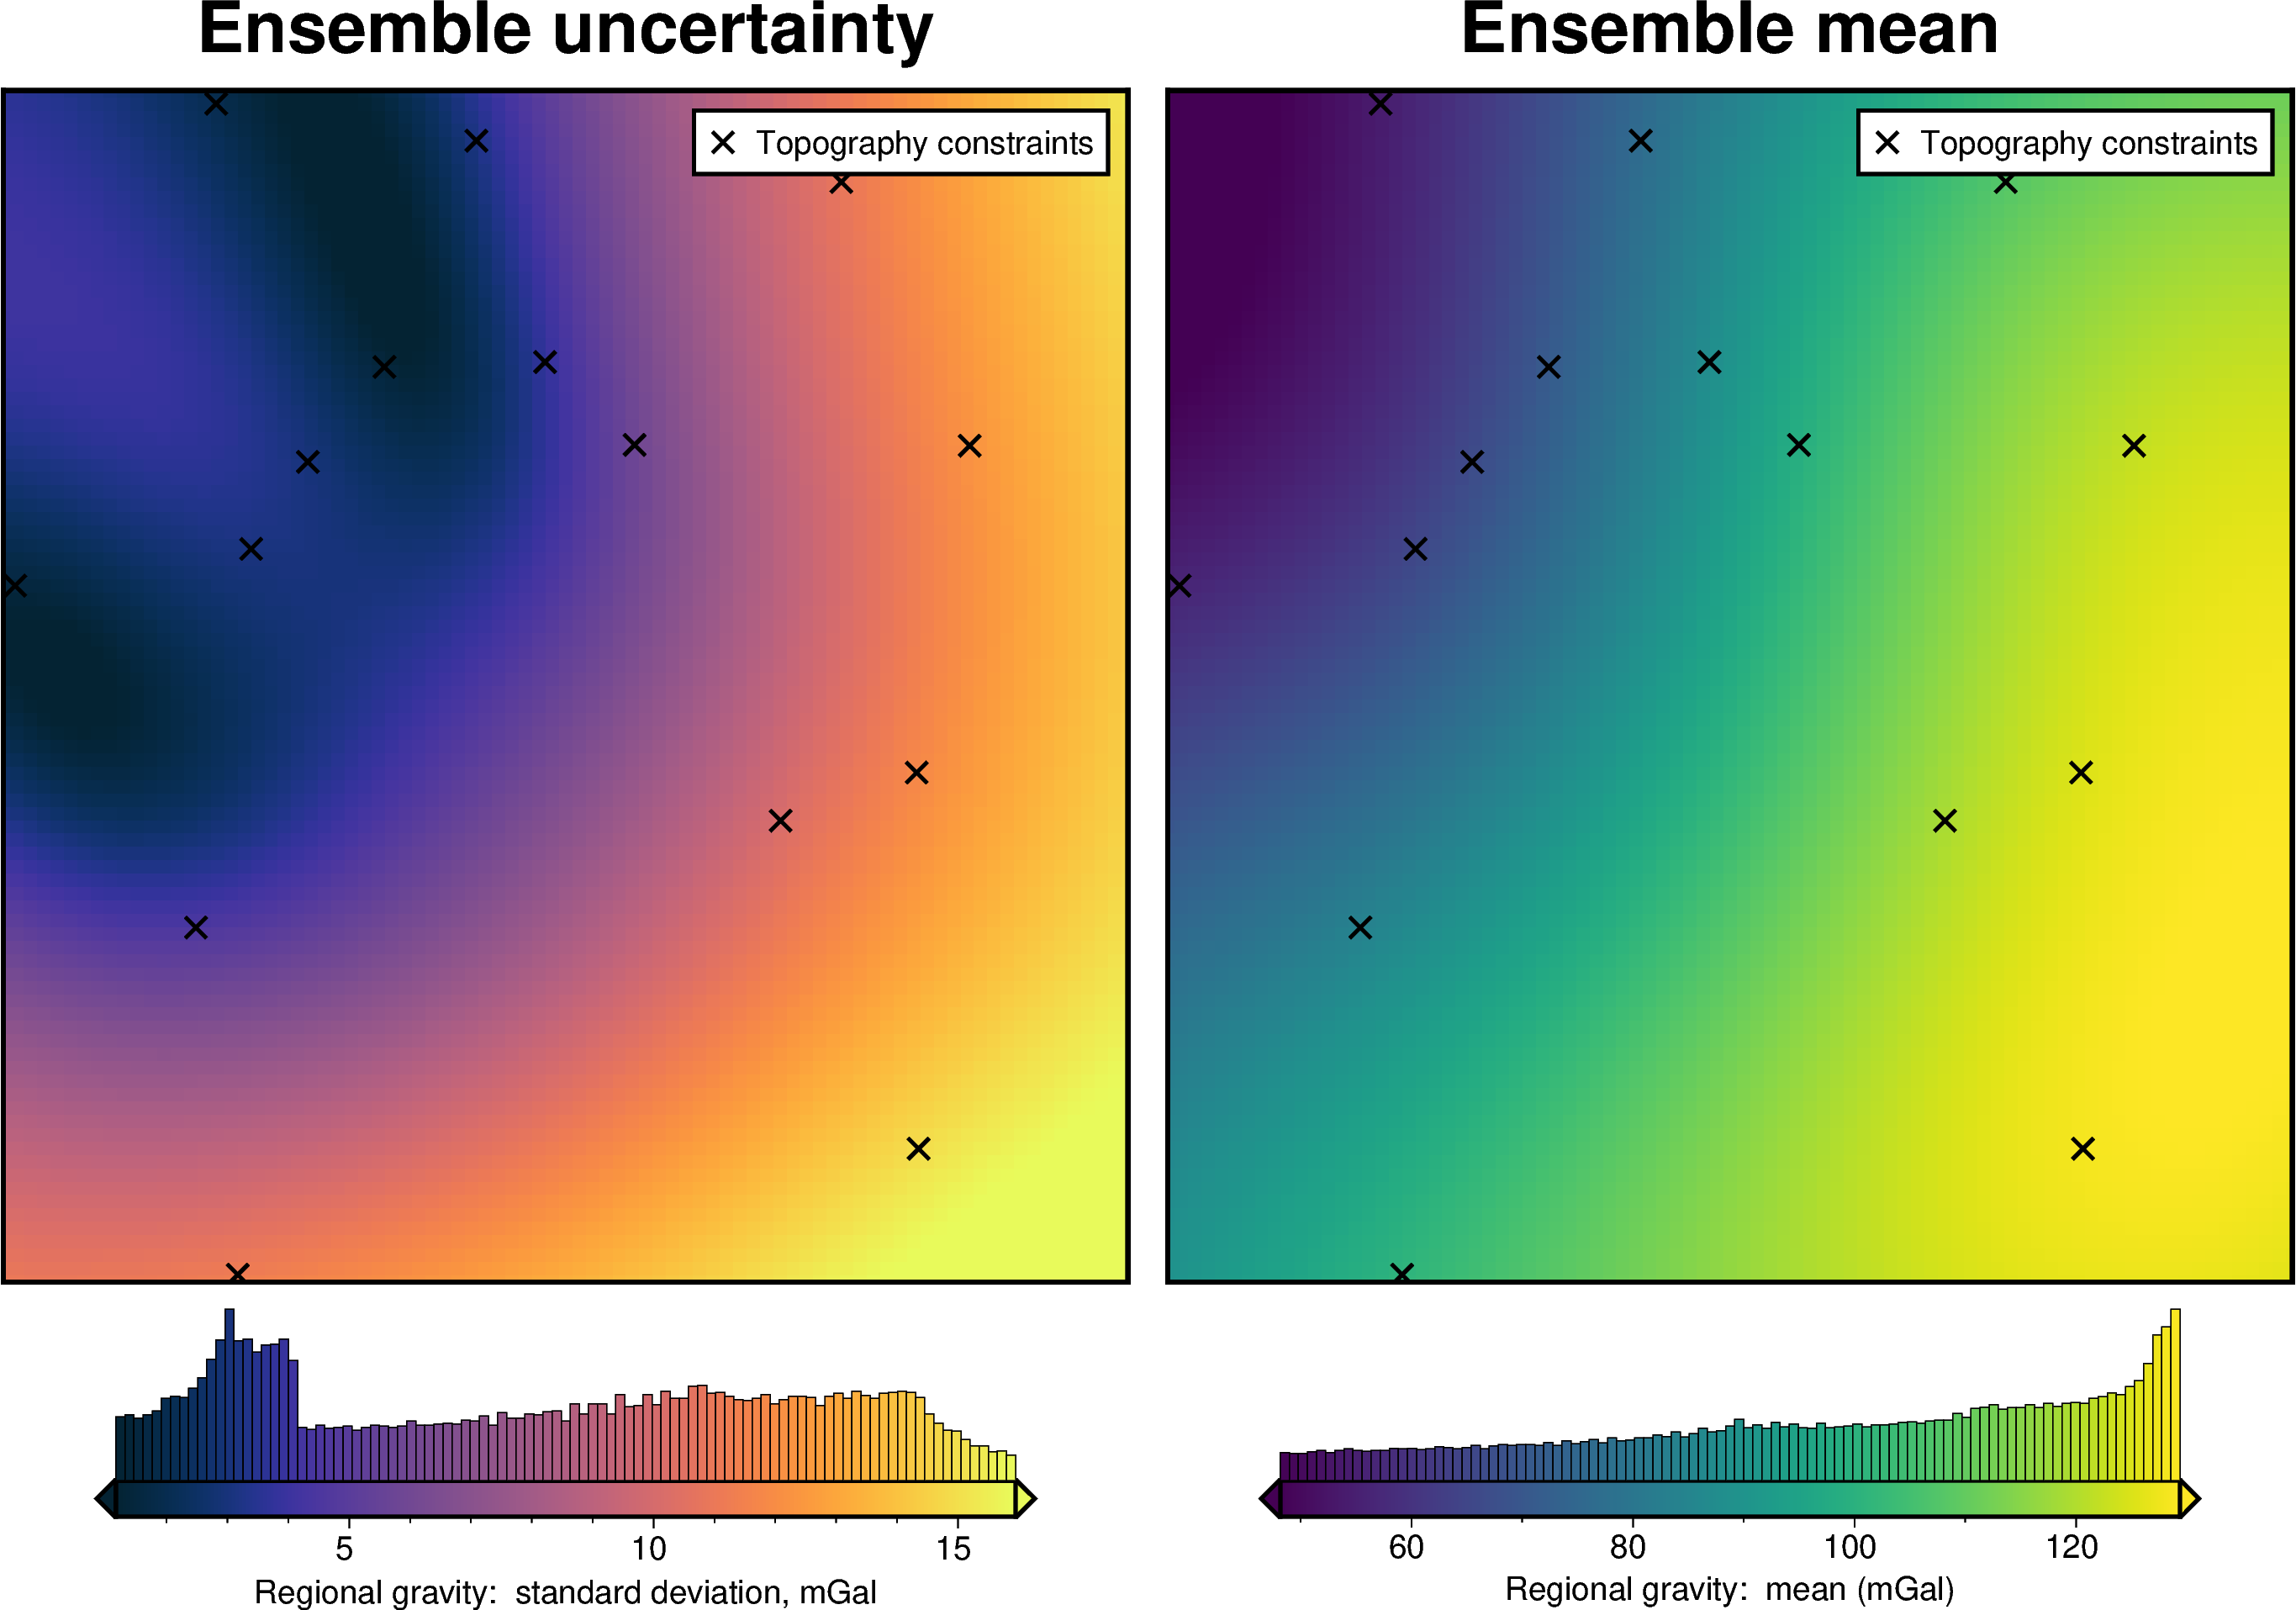

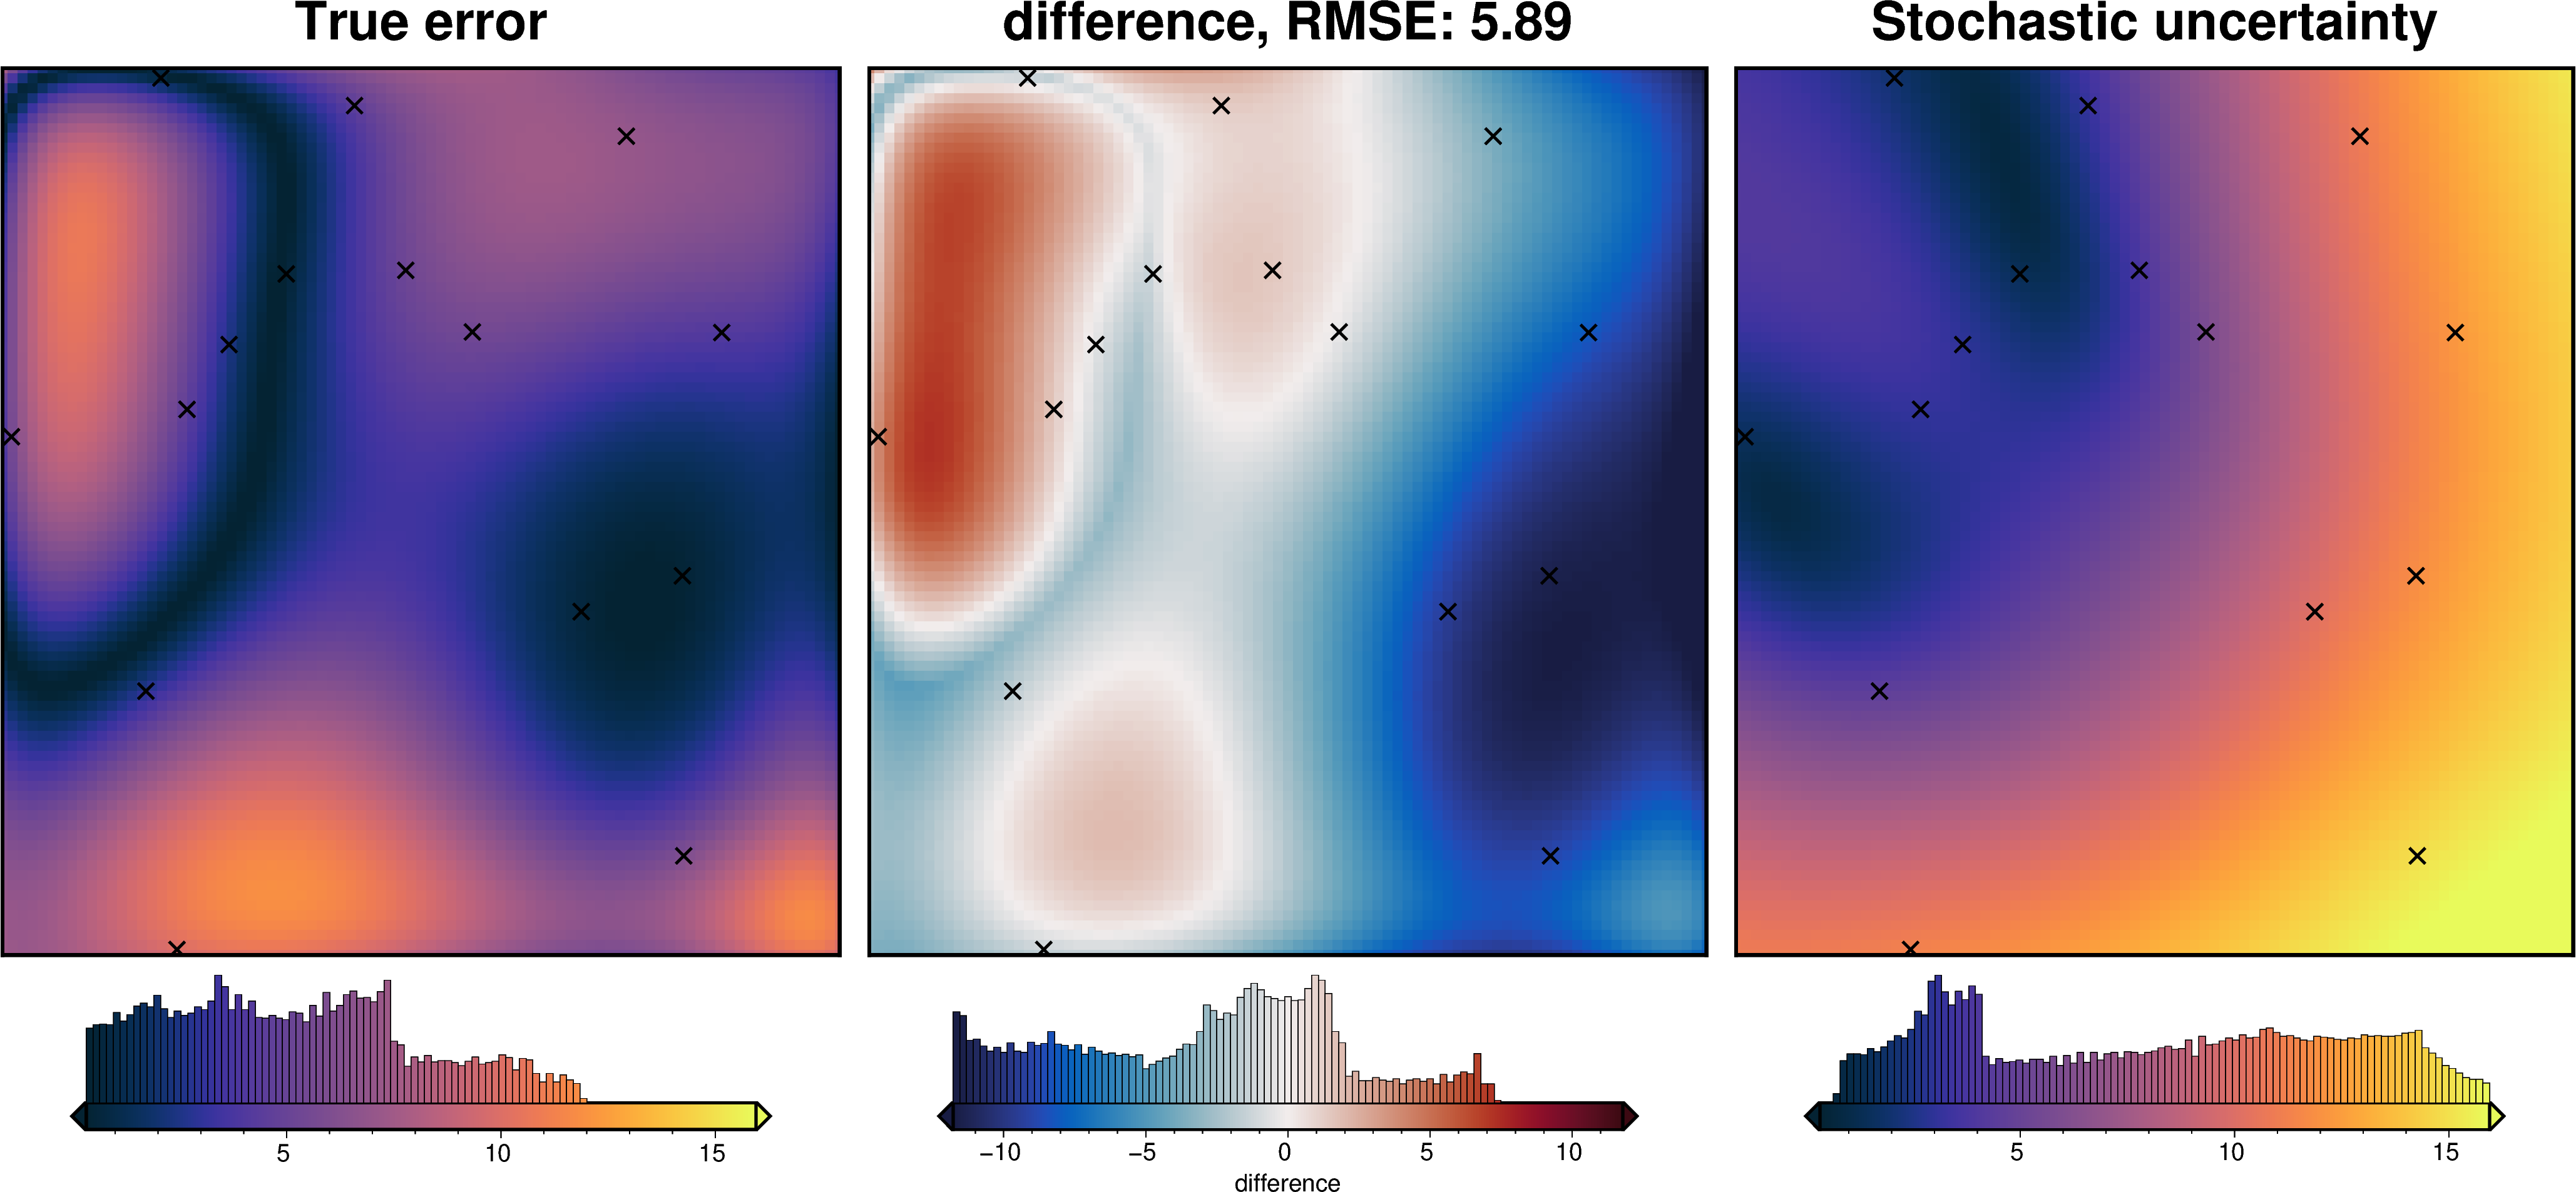

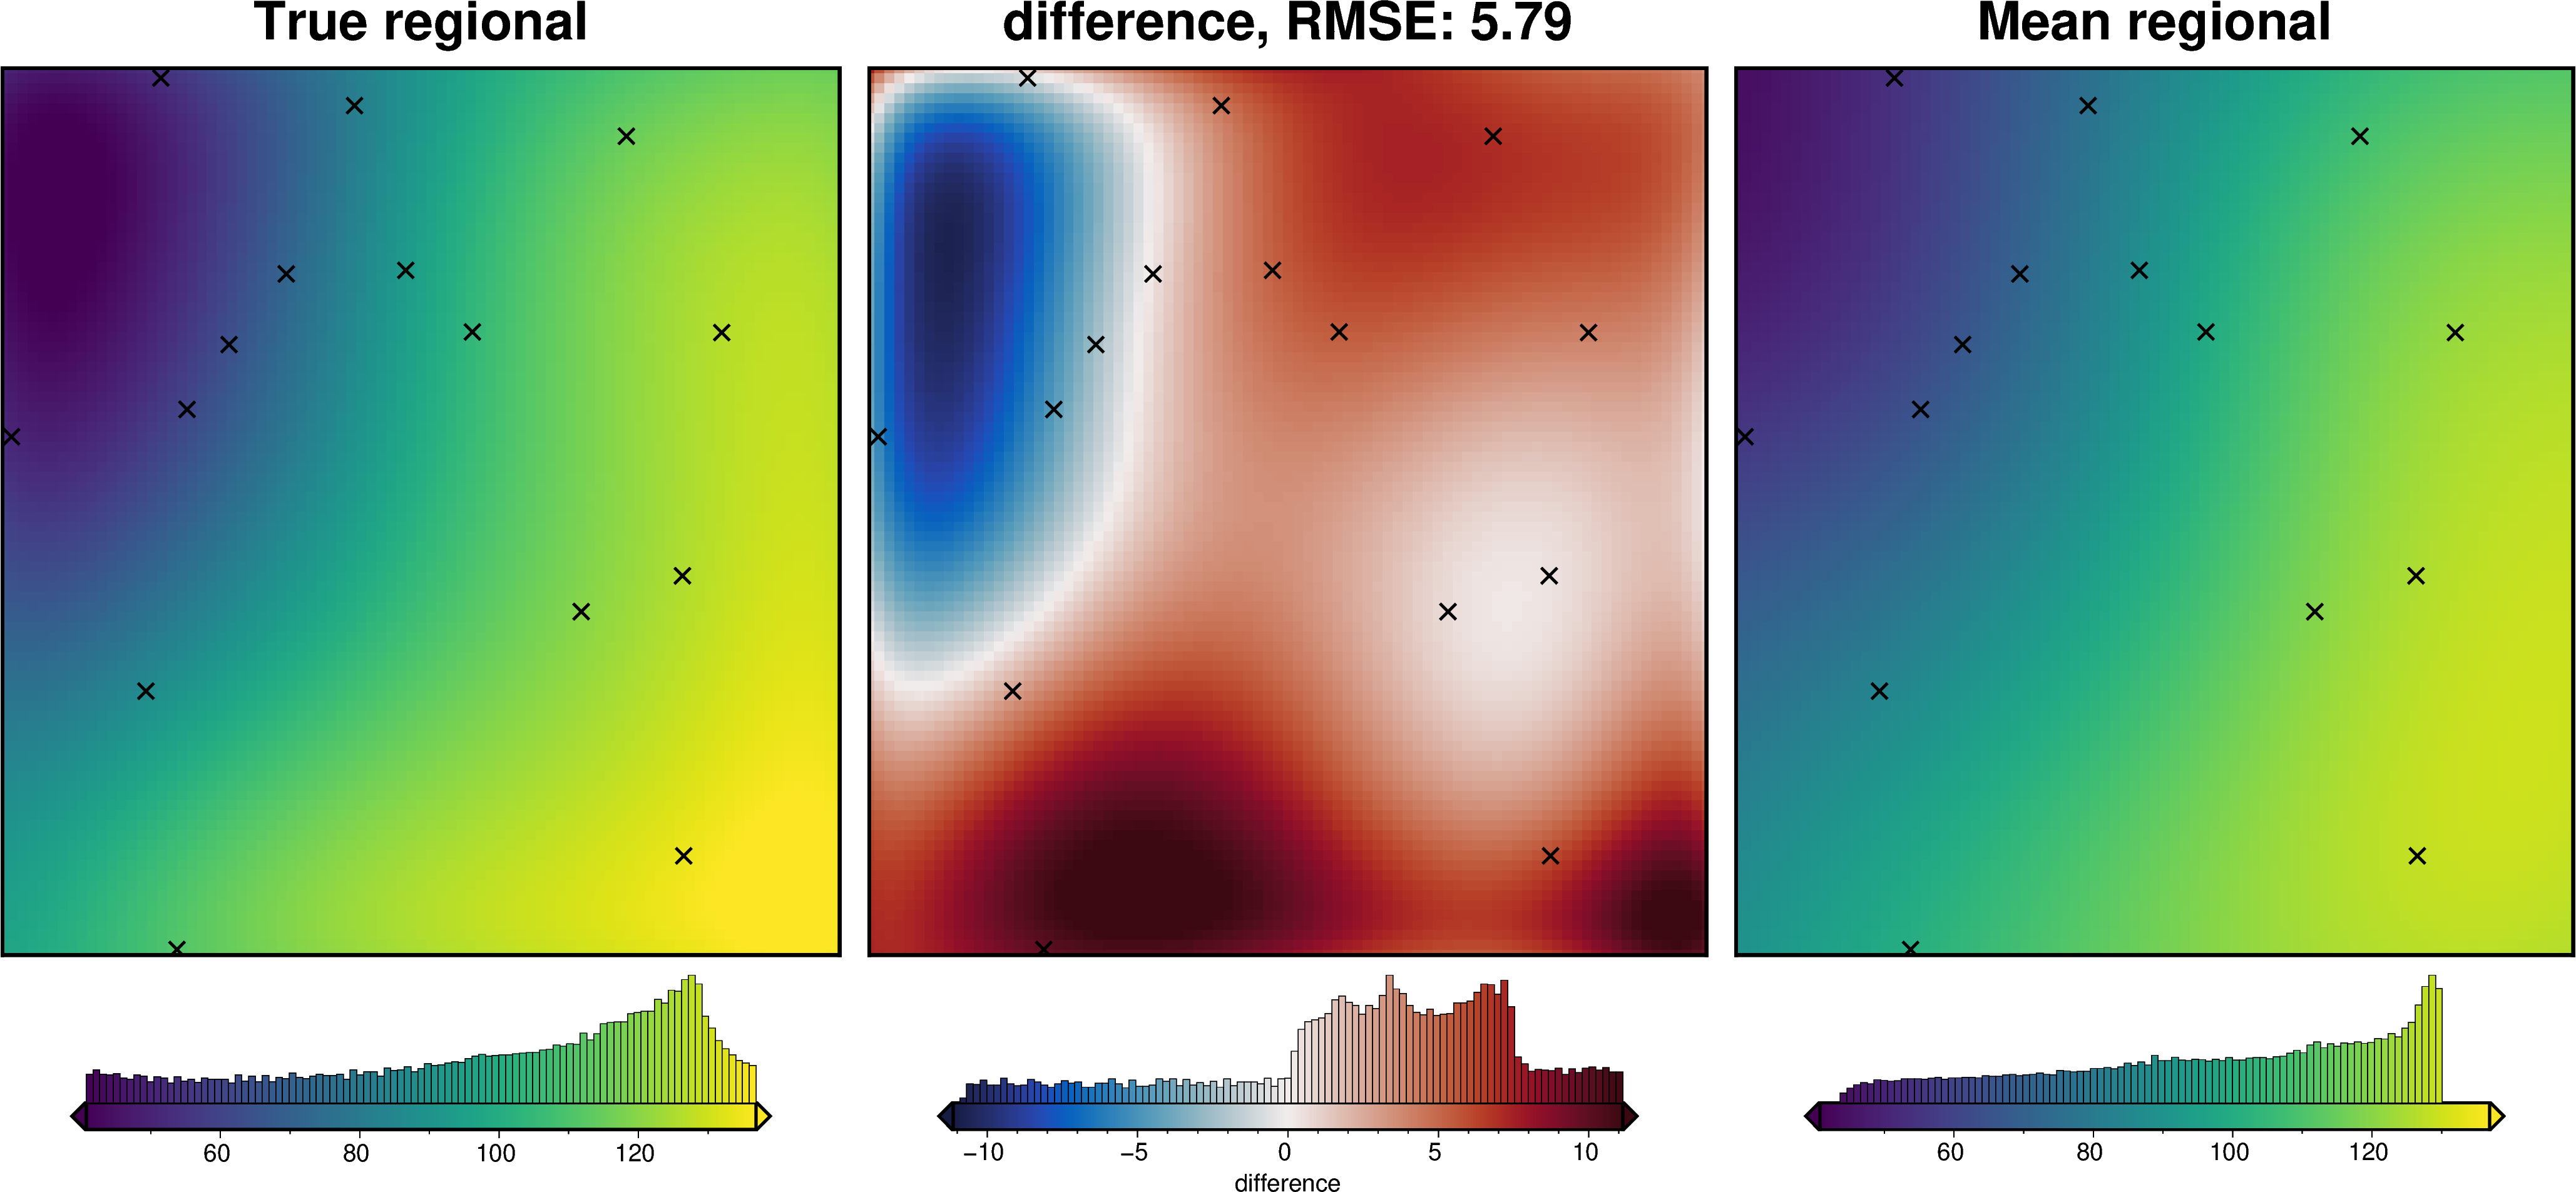

In [34]:
mean_constraint_distance = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing), k_nearest=1
    )
)

parameter_sampling_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 2.5 * mean_constraint_distance,  # lower bound
        "scale": 3.5 * mean_constraint_distance,  # range
    },
    "grav_obs_height": {
        "distribution": "uniform",
        "loc": 0,  # lower bound
        "scale": 10e3,  # range
    },
    # "damping": {
    #     "distribution": "uniform",
    #     "loc": -15, # lower bound
    #     "scale": 10, # range
    #     "log":True,
    # },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(eq_damping),  # mean
        "scale": 2,  # stdev
        "log": True,
    },
}
regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    parameter_dict=parameter_sampling_dict,
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=eq_damping,
    depth="default",
    block_size=None,
    **kwargs,
)